# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 128 #32
TRAIN_SPLIT_RATIO = 0.99 #0.8 #0.9891 # 1-(60/5*24)/50977

#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_TRAIN_AE = False #  True
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = False # False

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_72816/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
81785  1697066700000   1566.40   1567.23  1565.73    1566.31    571.5351   
81786  1697067000000   1566.32   1566.32  1565.35    1565.47    360.1248   
81787  1697067300000   1565.47   1566.33  1565.47    1566.33    143.9279   
81788  1697067600000   1566.32   1566.53  1566.13    1566.53    103.8286   
81789  1697067900000   1566.52   1566.91  1565.01    1565.01    277.3852   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1731.033372       1730.612087   
1      2023-01-01 00:05:00       1731.033372       1730.612087   
2      2023-01-01 00:10:00       1731.033372       1730.612087   
3      2023-01-01 00:15:00       1731.033372       1730.612087   
4      2023-01-01 00:20:00       1731.033372       1730.612087   
...                    ...               ...               ...   
81785  2023-10-11 23:25:00       1563.022500       1557.790000   
81786  2023-10-11 23:30:00       1563.390000       1557.900000   
81787  2023-10-11 23:35:00       1563.637500       1557.900000   
81788  2023-10-11 23:40:00       1563.850000       1557.900000   
81789  2023-10-11 23:45:00       1563.862500       1557.900000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
81785        1565.845  ...   NaN         NaN            NaN           NaN   
81786        1565.845  ...   NaN         NaN            NaN           NaN   
81787        1565.845  ...   NaN         NaN            NaN           NaN   
81788        1565.845  ...   NaN         NaN            NaN           NaN   
81789        1565.945  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
81785               NaN         0.0               NaN         0.0      0.0   
81786               NaN         0.0               NaN         0.0      0.0   
81787               NaN         0.0               NaN         0.0      0.0   
81788               NaN         0.0               NaN         0.0      0.0   
81789               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
81785   NaN  
81786   NaN  
81787   NaN  
81788   NaN  
81789   NaN  

[81790 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH        1
vwap_z_score_BTC        1
ichi_tenkan_ETH         8
ichi_tenkan_BTC         8
rsi_h_ETH              13
                    ...  
Actual              81755
Event               81755
Country             81755
keep                81755
date                81755
Length: 65, dtype: int64

on 81790 samples


#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
81785  1697066700000   1566.40   1567.23  1565.73    1566.31    571.5351   
81786  1697067000000   1566.32   1566.32  1565.35    1565.47    360.1248   
81787  1697067300000   1565.47   1566.33  1565.47    1566.33    143.9279   
81788  1697067600000   1566.32   1566.53  1566.13    1566.53    103.8286   
81789  1697067900000   1566.52   1566.91  1565.01    1565.01    277.3852   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1731.033372       1730.612087   
1      2023-01-01 00:05:00       1731.033372       1730.612087   
2      2023-01-01 00:10:00       1731.033372       1730.612087   
3      2023-01-01 00:15:00       1731.033372       1730.612087   
4      2023-01-01 00:20:00       1731.033372       1730.612087   
...                    ...               ...               ...   
81785  2023-10-11 23:25:00       1563.022500       1557.790000   
81786  2023-10-11 23:30:00       1563.390000       1557.900000   
81787  2023-10-11 23:35:00       1563.637500       1557.900000   
81788  2023-10-11 23:40:00       1563.850000       1557.900000   
81789  2023-10-11 23:45:00       1563.862500       1557.900000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
81785        1565.845  ...   NaN         NaN            NaN           NaN   
81786        1565.845  ...   NaN         NaN            NaN           NaN   
81787        1565.845  ...   NaN         NaN            NaN           NaN   
81788        1565.845  ...   NaN         NaN            NaN           NaN   
81789        1565.945  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
81785               NaN         0.0               NaN         0.0      0.0   
81786               NaN         0.0               NaN         0.0      0.0   
81787               NaN         0.0               NaN         0.0      0.0   
81788               NaN         0.0               NaN         0.0      0.0   
81789               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
81785                  NaN  
81786                  NaN  
81787                  NaN  
81788                  NaN  
81789                  NaN  

[81790 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       129
delta_event_real    129
delta_event_pred    129
Previous_num        129
Actual_num          129
Event               129
Date                129
Previous            129
Consensus           129
Actual              129
Country             129
Time (ET)           129
keep                129
date                129
dtype: int64

on 81790 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
81785   1566.40   1567.23  1565.73    1566.31    571.5351   
81786   1566.32   1566.32  1565.35    1565.47    360.1248   
81787   1565.47   1566.33  1565.47    1566.33    143.9279   
81788   1566.32   1566.53  1566.13    1566.53    103.8286   
81789   1566.52   1566.91  1565.01    1565.01    277.3852   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1731.033372       1730.612087   
1      2023-01-01 00:05:00       1731.033372       1730.612087   
2      2023-01-01 00:10:00       1731.033372       1730.612087   
3      2023-01-01 00:15:00       1731.033372       1730.612087   
4      2023-01-01 00:20:00       1731.033372       1730.612087   
...                    ...               ...               ...   
81785  2023-10-11 23:25:00       1563.022500       1557.790000   
81786  2023-10-11 23:30:00       1563.390000       1557.900000   
81787  2023-10-11 23:35:00       1563.637500       1557.900000   
81788  2023-10-11 23:40:00       1563.850000       1557.900000   
81789  2023-10-11 23:45:00       1563.862500       1557.900000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710          1194.71  ...  1196.096667  1196.096667   
1            1194.710          1194.71  ...  1195.801420  1195.801420   
2            1194.710          1194.71  ...  1195.648641  1195.648641   
3            1194.710          1194.71  ...  1195.575250  1195.575250   
4            1194.710          1194.71  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
81785        1565.845          1565.77  ...  1630.254137  1635.935178   
81786        1565.845          1565.77  ...  1630.251145  1635.931016   
81787        1565.845          1565.77  ...  1630.249957  1635.928192   
81788        1565.845          1565.77  ...  1630.249990  1635.925960   
81789        1565.945          1565.77  ...  1630.248441  1635.923141   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
81785  1751.629529  1622.978226   1722.529957         -0.943571 -0.099738   
81786  1751.625250  1622.984873   1722.529430         -0.948642 -0.100327   
81787  1751.622432  1622.990852   1722.529220         -0.943446 -0.099723   
81788  1751.620855  1622.995688   1722.529069         -0.942237 -0.099583   
81789  1751.617572  1622.999058   1722.528663         -0.951416 -0.100650   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205164e+08      511732.0       17.404831  
1      1.205164e+08      511732.0       17.404831  
2      1.205164e+08      511732.0       17.404831  
3      1.205164e+08      511732.0       17.404831  
4      1.205164e+08      511732.0       17.404831  
...             ...           ...             ...  
81785  1.202505e+08      454991.0       17.098547  
81786  1.202505e+08      454991.0       17.098547  
81787  1.202505e+08      454991.0       17.098547  
81788  1.202505e+08      454991.0       17.098547  
81789  1.202505e+08      454991.0       17.098547  

[81790 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.910  3823.179932  103.494003
1      3.910  3823.179932  103.494003
2      3.910  3823.179932  103.494003
3      3.910  3823.179932  103.494003
4      3.910  3823.179932  103.494003
...      ...          ...         ...
81785  4.605  4376.950195  105.724998
81786  4.605  4376.950195  105.724998
81787  4.605  4376.950195  105.724998
81788  4.605  4376.950195  105.724998
81789  4.605  4376.950195  105.724998

[81790 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

81790

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

80972

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
81785  1697066700000   1566.40   1567.23  1565.73    1566.31    571.5351   
81786  1697067000000   1566.32   1566.32  1565.35    1565.47    360.1248   
81787  1697067300000   1565.47   1566.33  1565.47    1566.33    143.9279   
81788  1697067600000   1566.32   1566.53  1566.13    1566.53    103.8286   
81789  1697067900000   1566.52   1566.91  1565.01    1565.01    277.3852   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1731.033372       1730.612087   
1      2023-01-01 00:05:00       1731.033372       1730.612087   
2      2023-01-01 00:10:00       1731.033372       1730.612087   
3      2023-01-01 00:15:00       1731.033372       1730.612087   
4      2023-01-01 00:20:00       1731.033372       1730.612087   
...                    ...               ...               ...   
81785  2023-10-11 23:25:00       1563.022500       1557.790000   
81786  2023-10-11 23:30:00       1563.390000       1557.900000   
81787  2023-10-11 23:35:00       1563.637500       1557.900000   
81788  2023-10-11 23:40:00       1563.850000       1557.900000   
81789  2023-10-11 23:45:00       1563.862500       1557.900000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
81785        1565.845  ...         NaN            NaN           NaN   
81786        1565.845  ...         NaN            NaN           NaN   
81787        1565.845  ...         NaN            NaN           NaN   
81788        1565.845  ...         NaN            NaN           NaN   
81789        1565.945  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
81785               NaN         0.0               NaN         0.0      0.0   
81786               NaN         0.0               NaN         0.0      0.0   
81787               NaN         0.0               NaN         0.0      0.0   
81788               NaN         0.0               NaN         0.0      0.0   
81789               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
81785                  NaN  False  
81786                  NaN  False  
81787                  NaN  False  
81788                  NaN  False  
81789                  NaN  False  

[81790 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
80968  1696821600000   1631.89   1632.74  1631.89    1632.73    387.9678   
80969  1696821900000   1632.74   1633.57  1632.73    1633.10    193.1684   
80970  1696822200000   1633.09   1633.53  1632.47    1633.53    367.7222   
80971  1696822500000   1633.53   1634.54  1633.52    1634.54    279.8717   
80972  1696822800000   1634.54   1636.00  1634.36    1634.63    668.5729   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1731.033372       1730.612087   
1      2023-01-01 00:05:00       1731.033372       1730.612087   
2      2023-01-01 00:10:00       1731.033372       1730.612087   
3      2023-01-01 00:15:00       1731.033372       1730.612087   
4      2023-01-01 00:20:00       1731.033372       1730.612087   
...                    ...               ...               ...   
80968  2023-10-09 03:20:00       1627.452500       1630.845000   
80969  2023-10-09 03:25:00       1627.452500       1630.845000   
80970  2023-10-09 03:30:00       1627.195000       1630.845000   
80971  2023-10-09 03:35:00       1627.195000       1630.700000   
80972  2023-10-09 03:40:00       1627.072500       1630.340000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
80968        1629.230  ...         2.2            1.6           2.0   
80969        1629.295  ...         2.2            1.6           2.0   
80970        1629.365  ...         2.2            1.6           2.0   
80971        1629.685  ...         2.2            1.6           2.0   
80972        1630.500  ...         2.2            1.6           2.0   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
80968               0.4         0.0              -0.6         0.0      0.0   
80969               0.4         0.0              -0.6         0.0      0.0   
80970               0.4         0.0              -0.6         0.0      0.0   
80971               0.4         0.0              -0.6         0.0      0.0   
80972               0.4         0.0              -0.6         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
80968  2023-10-11 13:00:00   True  
80969  2023-10-11 13:00:00   True  
80970  2023-10-11 13:00:00   True  
80971  2023-10-11 13:00:00   True  
80972  2023-10-11 13:00:00   True  

[80973 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
80973  1696823100000   1634.63   1634.94  1634.00    1634.20    239.2602   
80974  1696823400000   1634.21   1634.46  1633.80    1633.93    382.4666   
80975  1696823700000   1633.93   1633.93  1633.36    1633.65    652.8695   
80976  1696824000000   1633.65   1634.41  1633.64    1634.31    253.8759   
80977  1696824300000   1634.30   1634.46  1633.82    1634.14    156.6307   
...              ...       ...       ...      ...        ...         ...   
81785  1697066700000   1566.40   1567.23  1565.73    1566.31    571.5351   
81786  1697067000000   1566.32   1566.32  1565.35    1565.47    360.1248   
81787  1697067300000   1565.47   1566.33  1565.47    1566.33    143.9279   
81788  1697067600000   1566.32   1566.53  1566.13    1566.53    103.8286   
81789  1697067900000   1566.52   1566.91  1565.01    1565.01    277.3852   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
80973  2023-10-09 03:45:00         1627.0125          1630.340   
80974  2023-10-09 03:50:00         1626.8225          1630.340   
80975  2023-10-09 03:55:00         1628.4300          1630.340   
80976  2023-10-09 04:00:00         1628.4300          1630.340   
80977  2023-10-09 04:05:00         1628.7275          1630.065   
...                    ...               ...               ...   
81785  2023-10-11 23:25:00         1563.0225          1557.790   
81786  2023-10-11 23:30:00         1563.3900          1557.900   
81787  2023-10-11 23:35:00         1563.6375          1557.900   
81788  2023-10-11 23:40:00         1563.8500          1557.900   
81789  2023-10-11 23:45:00         1563.8625          1557.900   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
80973        1630.500  ...         2.2            1.6           2.0   
80974        1631.600  ...         2.2            1.6           2.0   
80975        1633.015  ...         2.2            1.6           2.0   
80976        1633.015  ...         2.2            1.6           2.0   
80977        1633.015  ...         2.2            1.6           2.0   
...               ...  ...         ...            ...           ...   
81785        1565.845  ...         NaN            NaN           NaN   
81786        1565.845  ...         NaN            NaN           NaN   
81787        1565.845  ...         NaN            NaN           NaN   
81788        1565.845  ...         NaN            NaN           NaN   
81789        1565.945  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
80973               0.4         0.0              -0.6         0.0      0.0   
80974               0.4         0.0              -0.6         0.0      0.0   
80975               0.4         0.0              -0.6         0.0      0.0   
80976               0.4         0.0              -0.6         0.0      0.0   
80977               0.4         0.0              -0.6         0.0      0.0   
...                 ...         ...               ...         ...      ...   
81785               NaN         0.0               NaN         0.0      0.0   
81786               NaN         0.0               NaN         0.0      0.0   
81787               NaN         0.0               NaN         0.0      0.0   
81788               NaN         0.0               NaN         0.0      0.0   
81789               NaN         0.0               NaN         0.0      0.0   

                      date  train  
80973  2023-10-11 13:00:00  False  
80974  2023-10-11 13:00:00  False  
80975  2023-10-11 13:00:00  False  
80976  2023-10-11 13:00:00  False  
80977  2023-10-11 13:00:00  False  
...                    ...    ...  
81785                  NaN  False  
81786                  NaN  False  
81787                  NaN  False  
81788                  NaN  False  
81789                  NaN  False  

[817 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(80886, 72, 102) (80886, 15)
(730, 72, 102) (730, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([0.99987751, 0.99981627, 0.9997489 , 0.99982852, 1.00005512,
       0.99989588, 0.99924057, 0.99992651, 1.00063694, 1.00031847,
       0.9994488 , 0.99995713, 1.00018373, 1.00044708, 1.00106565])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99946702, 1.00028793, 1.00016541, ..., 0.99973657, 1.00024505,
        1.00047172],
       [1.00082135, 1.00069876, 1.00063747, ..., 1.00077844, 1.00100523,
        1.0012688 ],
       [0.99987751, 0.99981627, 0.9997489 , ..., 1.00018373, 1.00044708,
        1.00106565]])

In [39]:
seq_y

array([0.99987751, 0.99981627, 0.9997489 , 0.99982852, 1.00005512,
       0.99989588, 0.99924057, 0.99992651, 1.00063694, 1.00031847,
       0.9994488 , 0.99995713, 1.00018373, 1.00044708, 1.00106565])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99946702, 1.00028793, 1.00016541, ..., 0.99973657, 1.00024505,
        1.00047172],
       [1.00082135, 1.00069876, 1.00063747, ..., 1.00077844, 1.00100523,
        1.0012688 ],
       [0.99987751, 0.99981627, 0.9997489 , ..., 1.00018373, 1.00044708,
        1.00106565]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(80886, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(80886, 72, 102) (80886, 15)
(730, 72, 102) (730, 15)


## Standardization

In [44]:
path_scaler

'data/scaler.bin'

In [45]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [46]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99946702, 1.00028793, 1.00016541, ..., 0.99973657, 1.00024505,
        1.00047172],
       [1.00082135, 1.00069876, 1.00063747, ..., 1.00077844, 1.00100523,
        1.0012688 ],
       [0.99987751, 0.99981627, 0.9997489 , ..., 1.00018373, 1.00044708,
        1.00106565]])

In [47]:
np.mean(y_train_sca)

4.405843873385141e-05

In [48]:
np.std(y_train_sca)

0.9999499145137853

In [49]:
np.mean(y_test_sca)

-0.06276189237566947

In [50]:
np.std(y_test_sca)

0.76997467474357

### Check unscaling

In [51]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1731.033372       1730.612087   
1    1195.38   1196.31   1196.69  1194.90       1731.033372       1730.612087   
2    1194.55   1195.38   1195.81  1194.55       1731.033372       1730.612087   
3    1195.98   1194.55   1195.98  1194.31       1731.033372       1730.612087   
4    1196.06   1195.98   1196.37  1195.97       1731.033372       1730.612087   
5    1196.61   1196.06   1196.70  1196.06       1731.033372       1730.612087   
6    1194.36   1196.62   1196.62  1193.72       1731.033372       1730.612087   
7    1194.22   1194.37   1194.43  1192.72       1731.033372       1730.612087   
8    1193.64   1194.22   1194.22  1193.02       1731.033372       1730.612087   
9    1194.64   1193.64   1195.06  1193.63       1731.033372       1730.612087   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1733.592011   
1         1194.71          1194.71           1733.592011   
2         1194.71          1194.71           1733.592011   
3         1194.71          1194.71           1733.592011   
4         1194.71          1194.71           1733.592011   
5         1194.71          1194.71           1733.592011   
6         1194.71          1194.71           1733.592011   
7         1194.71          1194.71           1733.592011   
8         1194.71          1194.71           1733.592011   
9         1194.71          1194.71           1733.592011   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0           1727.160387  ...  1.205164e+08       1.0       0.0      0.62349   
1           1727.160387  ...  1.205164e+08       1.0       0.0      0.62349   
2           1727.160387  ...  1.205164e+08       1.0       0.0      0.62349   
3           1727.160387  ...  1.205164e+08       1.0       0.0      0.62349   
4           1727.160387  ...  1.205164e+08       1.0       0.0      0.62349   
5           1727.160387  ...  1.205164e+08       1.0       0.0      0.62349   
6           1727.160387  ...  1.205164e+08       1.0       0.0      0.62349   
7           1727.160387  ...  1.205164e+08       1.0       0.0      0.62349   
8           1727.160387  ...  1.205164e+08       1.0       0.0      0.62349   
9           1727.160387  ...  1.205164e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [52]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [53]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [54]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [55]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Check Inputs TRAIN/TEST 

In [56]:
X_train.reshape(-1, X_train.shape[-1]).shape

(5823792, 102)

In [57]:
X_train[:,-1,:].shape

(80886, 102)

In [58]:
X_test[:,-1,:].shape

(730, 102)

In [59]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.012365 -0.013375 -0.065378  0.078359         -0.047308   
1       0.012365 -0.041252 -0.077437  0.050401         -0.080322   
2       0.012365  0.022496 -0.055338  0.086362         -0.073899   
3       0.012365  0.104247  0.014040  0.093346         -0.004785   
4       0.012365 -0.067162 -0.075428  0.025414         -0.046751   
...          ...       ...       ...       ...               ...   
81611   0.012365 -0.055869 -0.074609  0.014634         -0.301083   
81612   0.012365  0.004935 -0.010235  0.081715         -0.306514   
81613   0.012365 -0.045956 -0.077675  0.000971         -0.339320   
81614   0.012365 -0.005693 -0.070783  0.057355         -0.352202   
81615   0.012365 -0.027706  0.040228  0.064986         -0.377268   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.012905       -0.149517        -0.041433   
1             -0.024363       -0.180775        -0.074308   
2             -0.018267       -0.166289        -0.039935   
3              0.043423       -0.081231         0.049475   
4             -0.010815       -0.156014        -0.029135   
...                 ...             ...              ...   
81611         -0.399653       -0.125077        -0.121320   
81612         -0.404797       -0.121855        -0.093582   
81613         -0.444383       -0.176719        -0.151204   
81614         -0.457227       -0.186317        -0.153798   
81615         -0.483929       -0.153084        -0.118925   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  8.615182              8.029335  ...  0.366870  1.365856   
1                  8.602418              8.017382  ...  0.000785  1.414036   
2                  8.604506              8.019337  ...  0.000785  1.414036   
3                  8.625634              8.039122  ...  0.000785  1.414036   
4                  8.607058              8.021727  ...  0.000785  1.414036   
...                     ...                   ...  ...       ...       ...   
81611              0.314108              0.453866  ...  1.225728 -0.706941   
81612              0.312868              0.452691  ...  1.225728 -0.706941   
81613              0.303319              0.443652  ...  1.225728 -0.706941   
81614              0.300221              0.440720  ...  1.225728 -0.706941   
81615              0.293780              0.434622  ...  1.225728 -0.706941   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin   day_off  \
0         0.879441    -1.102165          1.367254          0.256091 -0.052819   
1         0.879441    -1.102165          1.367254          0.256091 -0.052819   
2         0.879441    -1.102165          1.367254          0.256091 -0.052819   
3         0.879441    -1.102165          1.367254          0.256091 -0.052819   
4         0.879441    -1.102165          1.367254          0.256091 -0.052819   
...            ...          ...               ...               ...       ...   
81611    -0.317368     1.381522         -0.889392          1.088148 -0.052819   
81612    -0.317368     1.381522         -0.889392          1.088148 -0.052819   
81613    -0.317368     1.381522         -0.889392          1.088148 -0.052819   
81614    -0.317368     1.381522         -0.889392          1.088148 -0.052819   
81615    -0.317368     1.381522         -0.889392          1.088148 -0.052819   

       event_pred  event_real  TRAIN  
0             0.0         0.0    1.0  
1             0.0         0.0    1.0  
2             0.0         0.0    1.0  
3             0.0         0.0    1.0  
4             0.0         0.0    1.0  
...           ...         ...    ...  
81611         0.0         0.0    0.0  
81612         0.0         0.0    0.0  
81613         0.0         0.0    0.0  
81614         0.0         0.0    0.0  
81615         0.0         0.0    0.0  

[81616 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  8.088600e+04  80886.000000  80886.000000  80886.000000   
mean   1.236496e-02      0.012201      0.012351      0.012185   
std    9.199295e-15      0.171884      0.135452      0.133456   
min    1.236496e-02     -5.755807     -0.078441     -5.700578   
25%    1.236496e-02     -0.050472     -0.062423     -0.014986   
50%    1.236496e-02      0.012535     -0.024621      0.050536   
75%    1.236496e-02      0.073755      0.039476      0.088744   
max    1.236496e-02     11.209737     11.450569      0.105343   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      80886.000000      80886.000000    80886.000000     80886.000000   
mean           0.006468          0.006188        0.011436         0.012034   
std            0.637593          0.688712        0.364140         0.233469   
min           -5.930927         -6.127849       -4.755139        -3.971882   
25%           -0.205938         -0.227112       -0.136575        -0.084259   
50%            0.017041          0.020677        0.023072         0.016646   
75%            0.233513          0.271911        0.172682         0.115498   
max            9.904321         10.146008        6.610647         6.178794   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          80886.000000          80886.000000  ...  80886.000000   
mean              -0.001726             -0.001316  ...      0.000376   
std                0.973449              0.977479  ...      1.000243   
min               -3.594345             -3.078250  ...     -1.413658   
25%               -0.392053             -0.452672  ...     -0.999377   
50%                0.005520             -0.020698  ...      0.000785   
75%                0.291096              0.392579  ...      1.000947   
max                8.643537              8.055887  ...      1.415228   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  80886.000000  80886.000000  80886.000000      80886.000000   
mean      -0.000526      0.000295      0.000214         -0.000747   
std        0.999770      1.000192      0.999821          0.999552   
min       -1.413933     -1.277134     -1.375163         -1.439354   
25%       -0.999787     -1.277134     -1.102165         -0.970242   
50%        0.000051     -0.317368      0.003179         -0.021538   
75%        0.999890      0.879441      1.108524          0.955290   
max        1.414036      1.412072      1.381522          1.396277   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      80886.000000  80886.000000  80886.000000  80886.000000  80886.0  
mean           0.000668     -0.000007      0.000000      0.000000      1.0  
std            1.000453      0.999938      0.999938      0.999938      0.0  
min           -1.439563     -0.052819    -71.096326    -71.096326      1.0  
25%           -1.051103     -0.052819      0.000000      0.000000      1.0  
50%           -0.028046     -0.052819      0.000000      0.000000      1.0  
75%            0.995012     -0.052819      0.000000      0.000000      1.0  
max            1.383472     18.932629     71.096326     71.096326      1.0  

[8 rows x 103 columns]

In [61]:
df[df["TRAIN"] == 0].describe()

Close_ETH    Open_ETH    High_ETH     Low_ETH  ichi_cloud_a_ETH  \
count  7.300000e+02  730.000000  730.000000  730.000000        730.000000   
mean   1.236496e-02    0.017168    0.011669    0.011938          0.132538   
std    1.406089e-16    0.164317    0.127452    0.111610          0.525639   
min    1.236496e-02   -0.813963   -0.078441   -0.755037         -1.198334   
25%    1.236496e-02   -0.062897   -0.061544   -0.027494         -0.210098   
50%    1.236496e-02    0.013677   -0.018977    0.045378          0.074213   
75%    1.236496e-02    0.080544    0.043344    0.084775          0.479310   
max    1.236496e-02    1.859834    1.785113    0.105343          2.029860   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count        730.000000      730.000000       730.000000   
mean           0.167664        0.028673         0.018286   
std            0.572860        0.311845         0.192253   
min           -1.104536       -1.087715        -0.896602   
25%           -0.260481       -0.141368        -0.085558   
50%            0.090742        0.037412         0.013631   
75%            0.597087        0.200960         0.125708   
max            1.830263        1.158348         1.173579   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...    hour_cos  \
count            730.000000            730.000000  ...  730.000000   
mean               0.687402              0.693940  ...   -0.103068   
std                0.136604              0.128011  ...    0.997503   
min                0.272680              0.318986  ...   -1.413658   
25%                0.597427              0.586598  ...   -0.999377   
50%                0.685989              0.684753  ...    0.000785   
75%                0.785279              0.788583  ...    1.000947   
max                1.089283              1.064262  ...    1.415228   

         hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
count  730.000000   730.000000   730.000000        730.000000   
mean    -0.141558     0.562282     0.949058         -0.672596   
std      0.988359     0.704775     0.538894          0.195744   
min     -1.413933    -0.317368     0.003179         -0.889392   
25%     -0.999787    -0.317368     1.108524         -0.889392   
50%     -0.365915     0.879441     1.108524         -0.645936   
75%      0.707044     0.879441     1.381522         -0.645936   
max      1.414036     1.412072     1.381522         -0.376917   

       day_in_month_sin       day_off  event_pred  event_real  TRAIN  
count        730.000000  7.300000e+02  730.000000  730.000000  730.0  
mean           1.206716 -5.281887e-02    0.097392   -0.097392    0.0  
std            0.098571  4.027318e-16    2.631393    2.631393    0.0  
min            1.088148 -5.281887e-02    0.000000  -71.096326    0.0  
25%            1.088148 -5.281887e-02    0.000000    0.000000    0.0  
50%            1.239221 -5.281887e-02    0.000000    0.000000    0.0  
75%            1.239221 -5.281887e-02    0.000000    0.000000    0.0  
max            1.338412 -5.281887e-02   71.096326    0.000000    0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

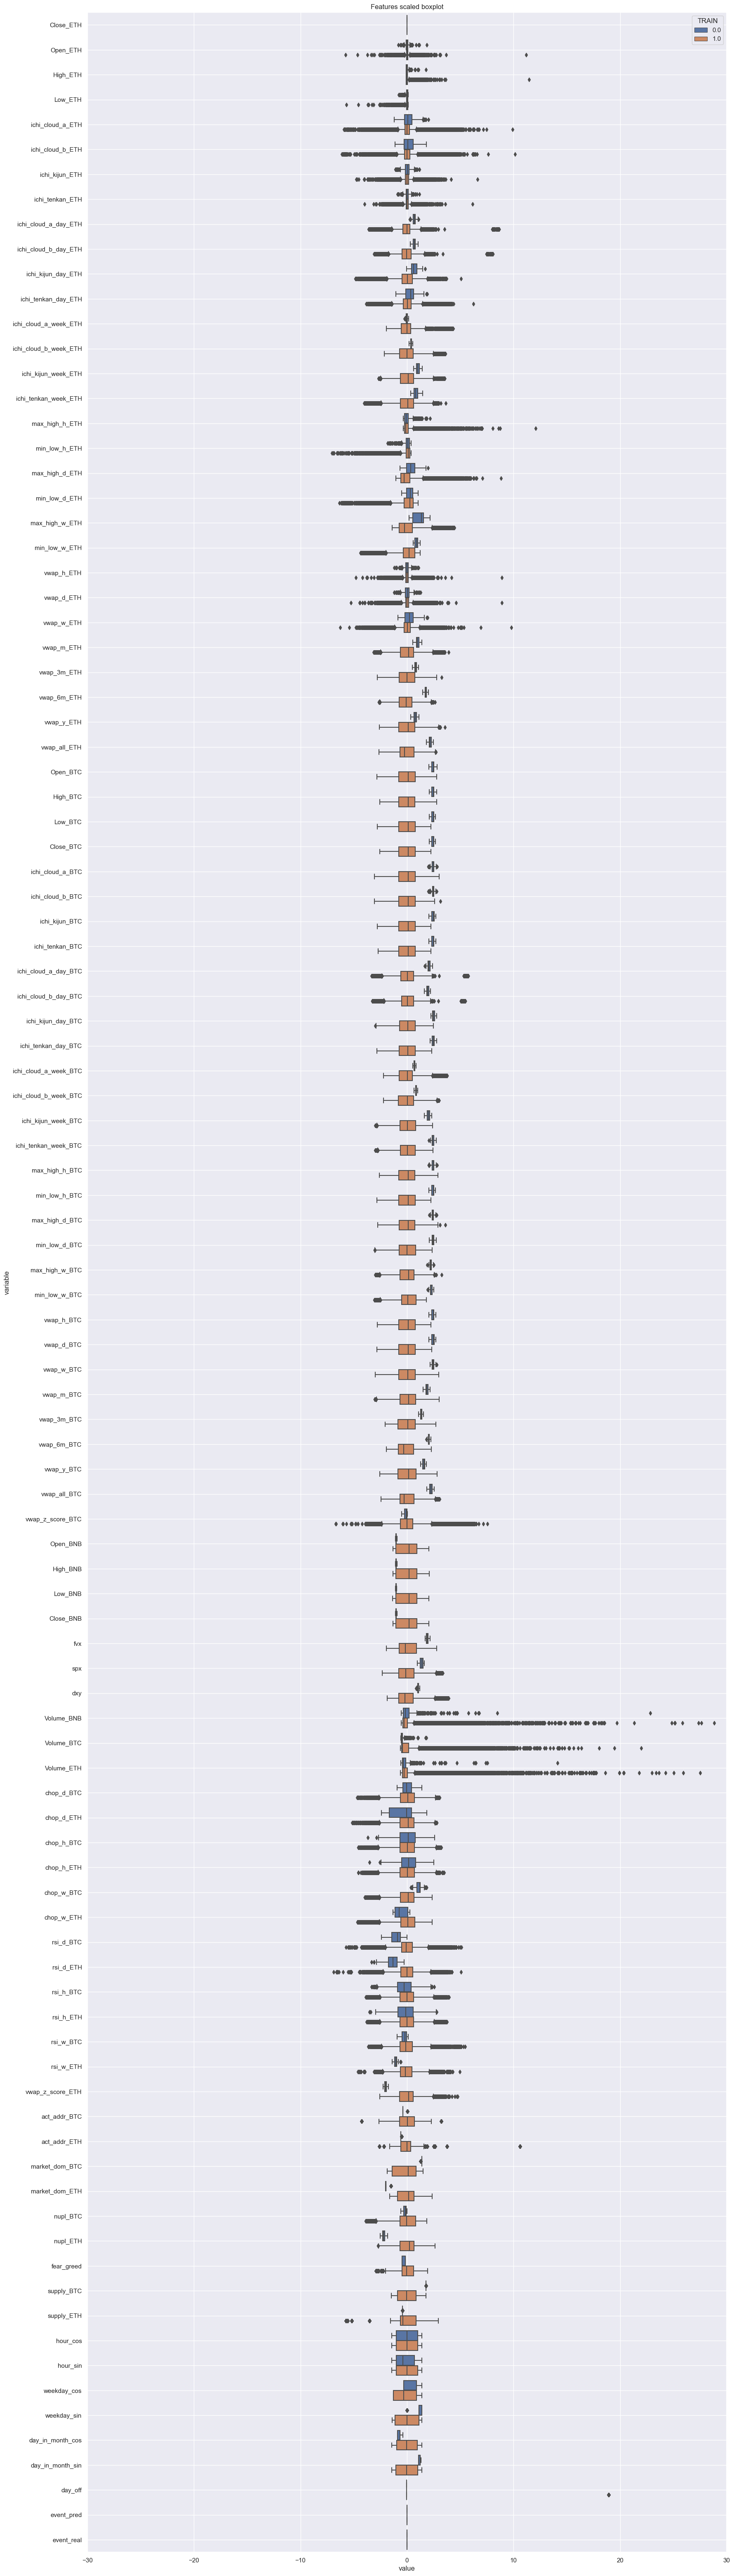

In [62]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<AxesSubplot: >

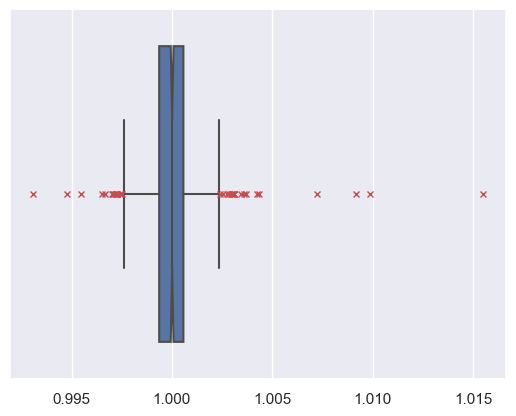

In [63]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


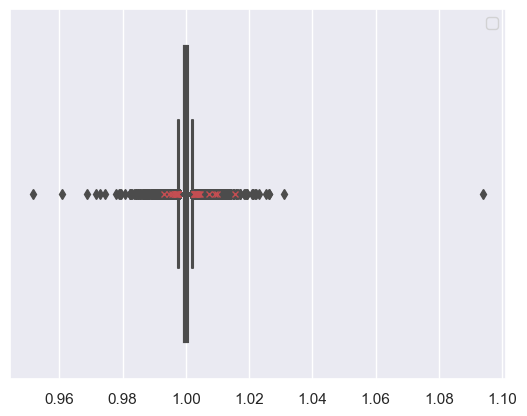

In [64]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

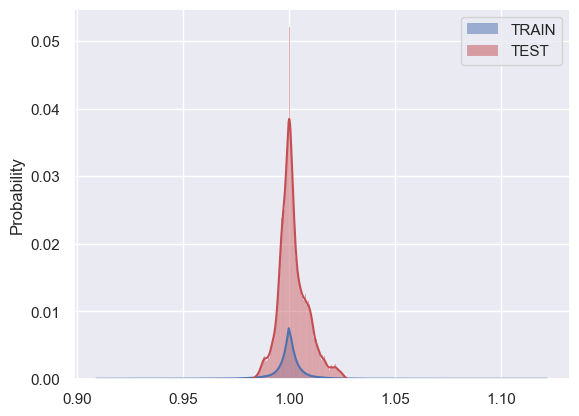

In [65]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [66]:
X_train_sca.shape

(80886, 72, 102)

In [67]:
X_train_sca[:,-1,:].shape

(80886, 102)

In [68]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.10652259],
       [-0.02875422],
       [-0.20202356],
       ...,
       [-0.14431936],
       [ 0.19765764],
       [-0.04066768]])

In [69]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(80886, 103)

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [72]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

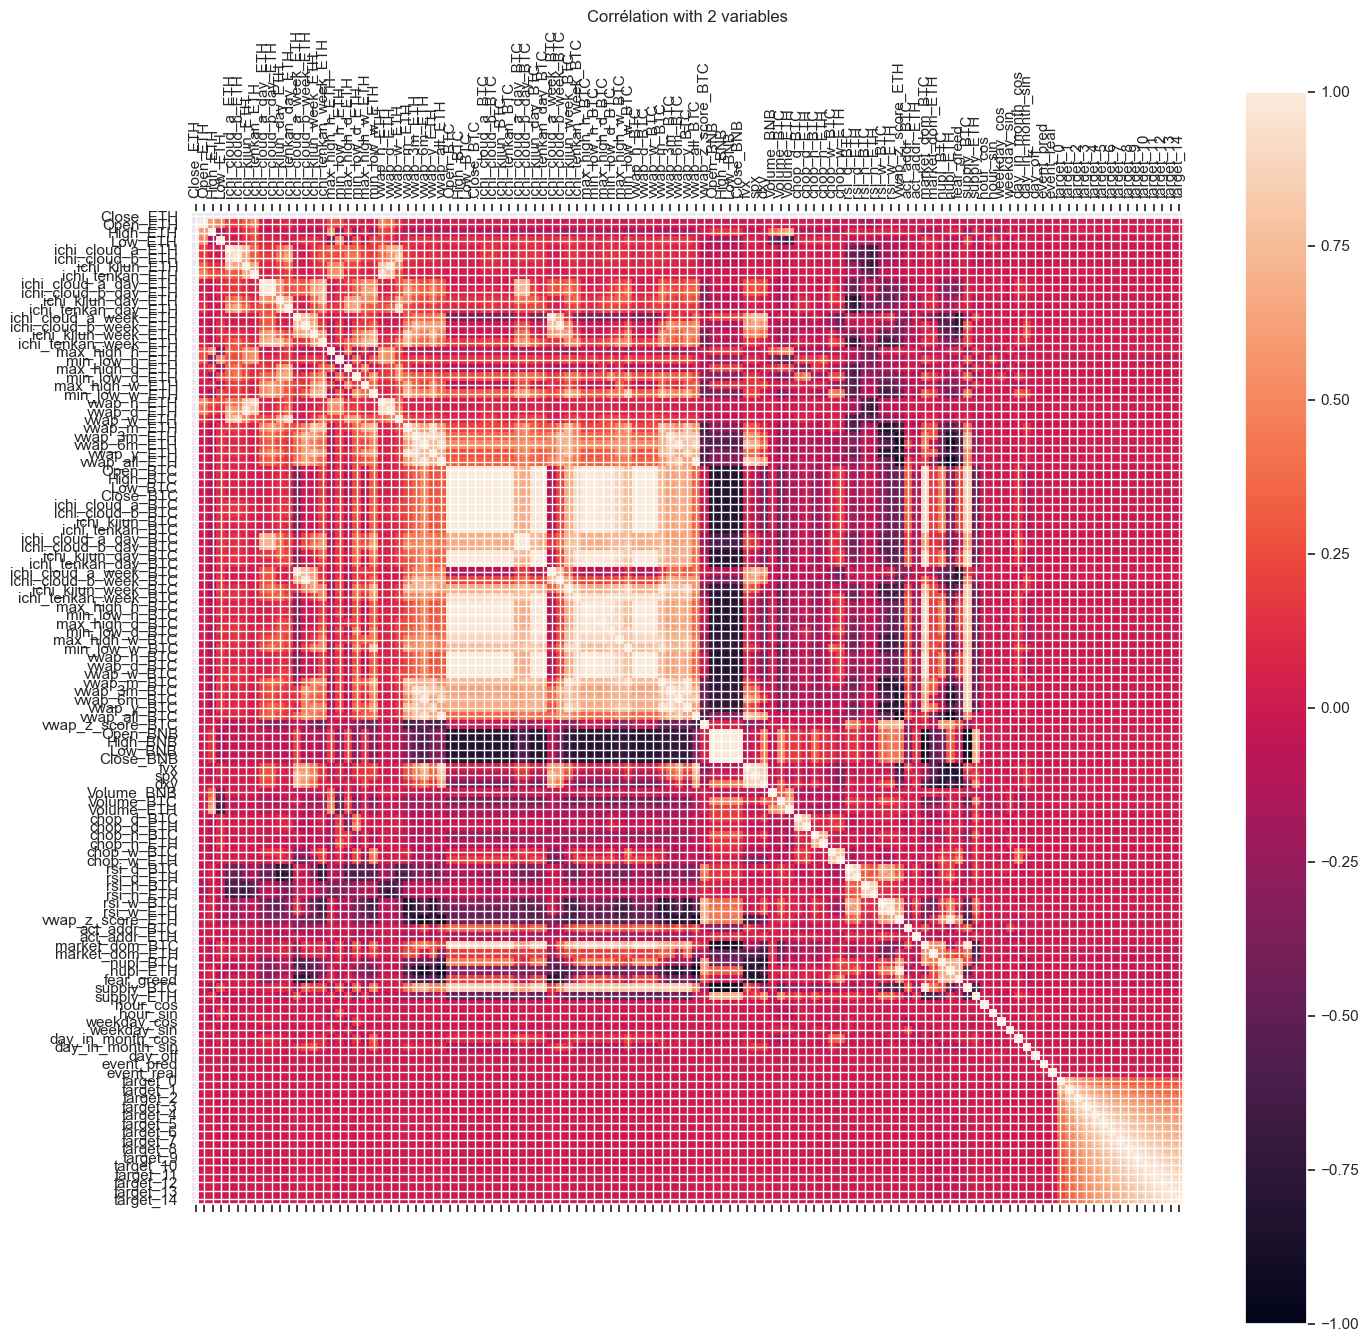

In [73]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


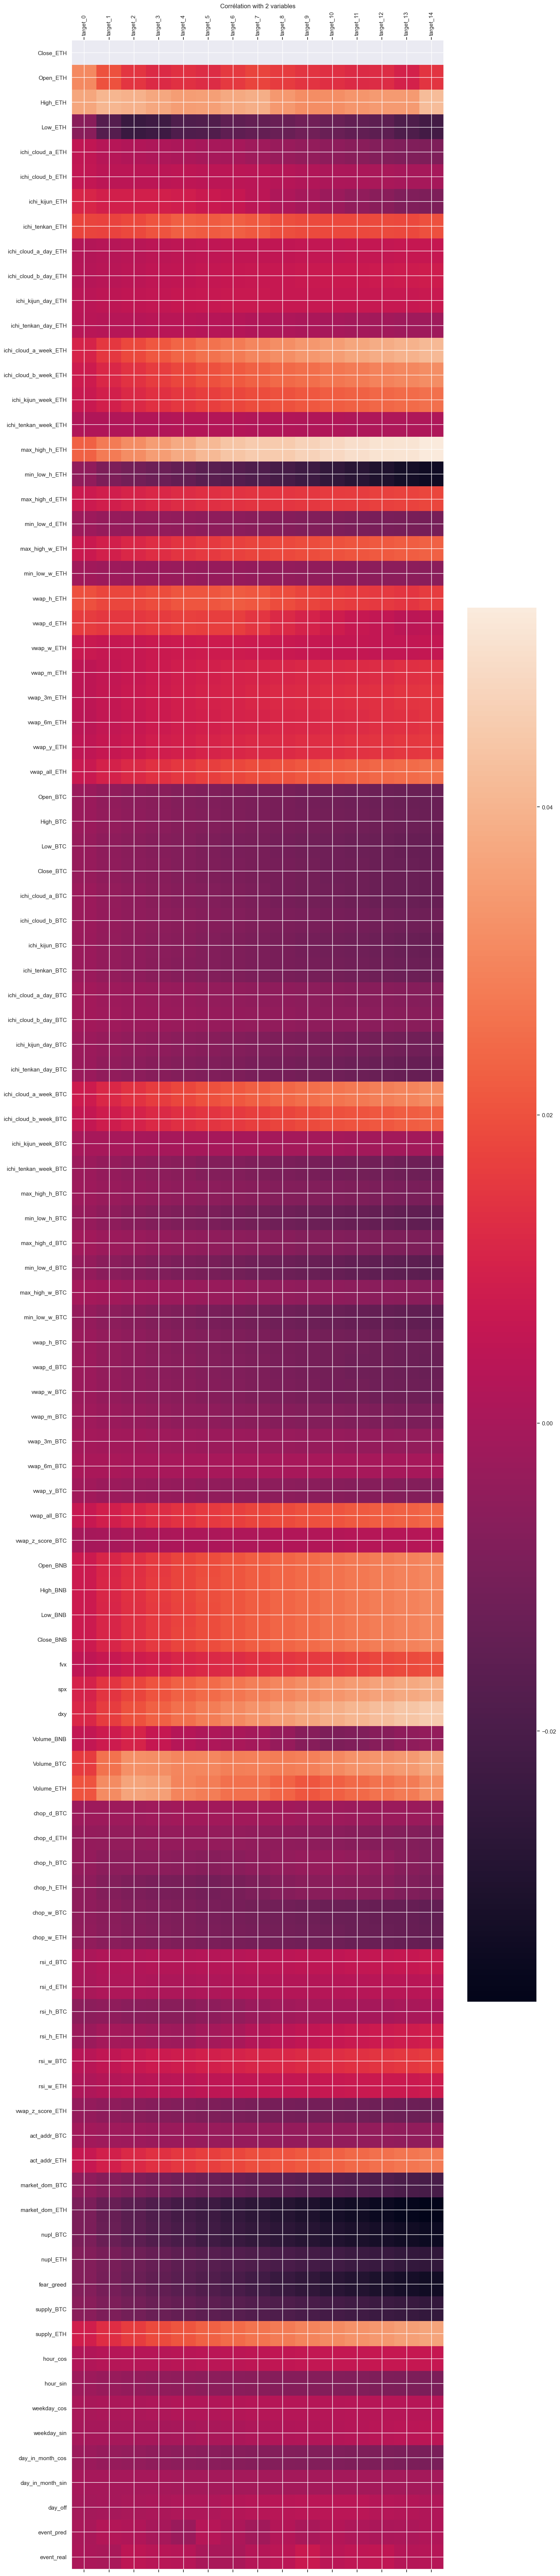

In [74]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


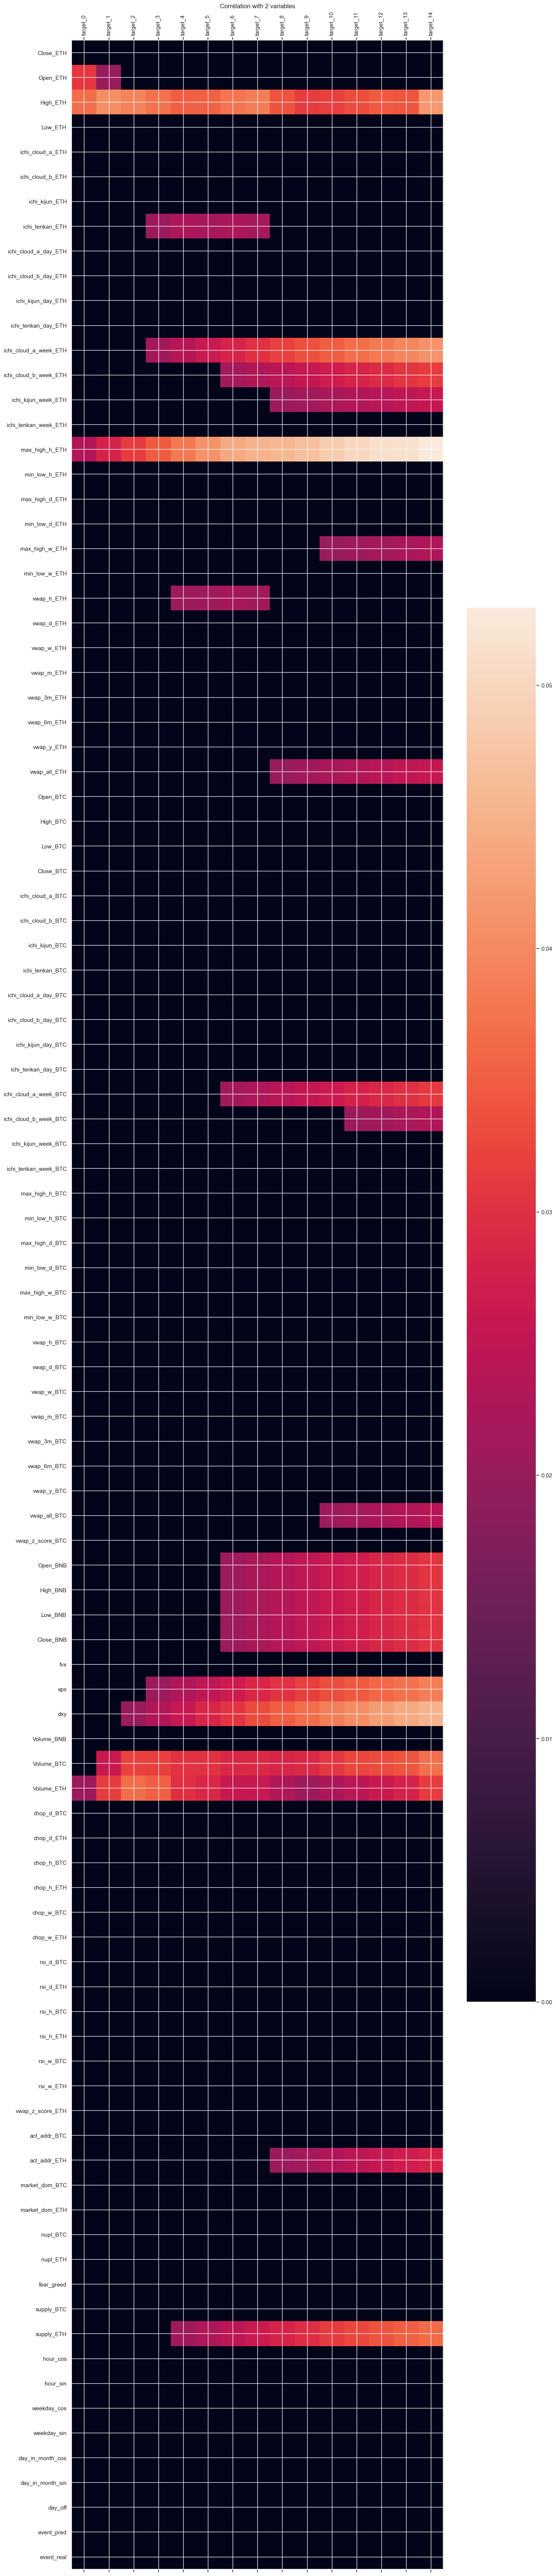

In [75]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [76]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

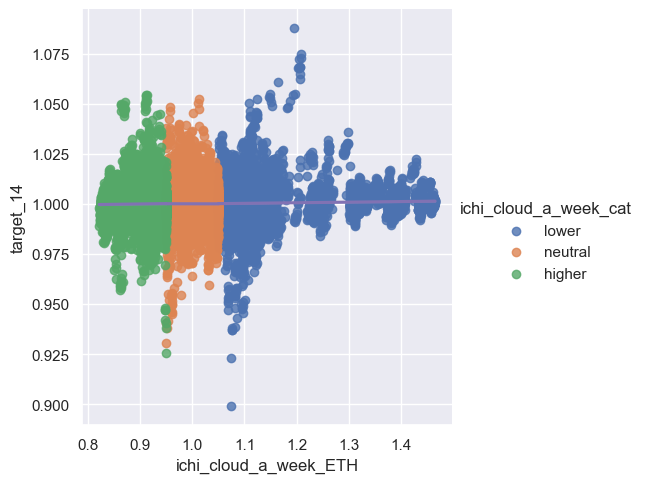

In [77]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

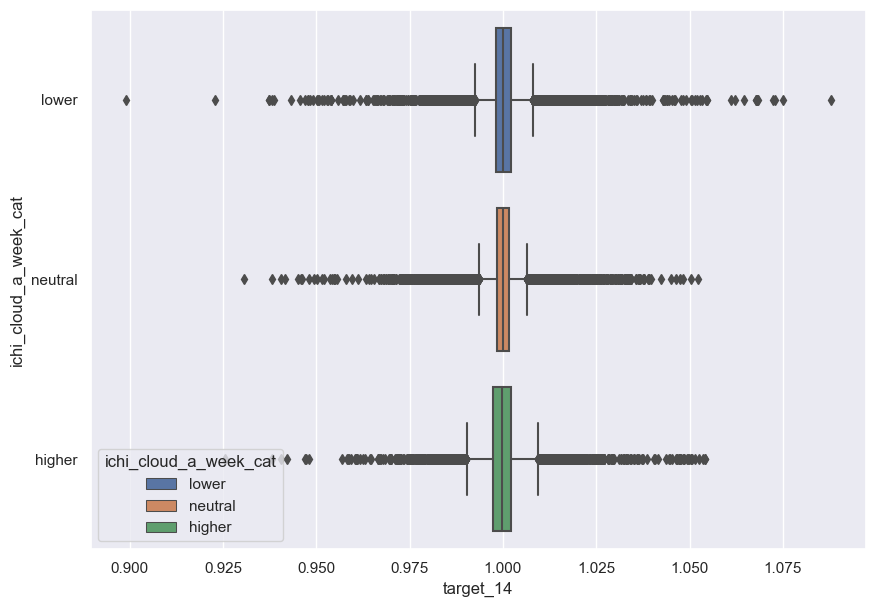

In [78]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [79]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


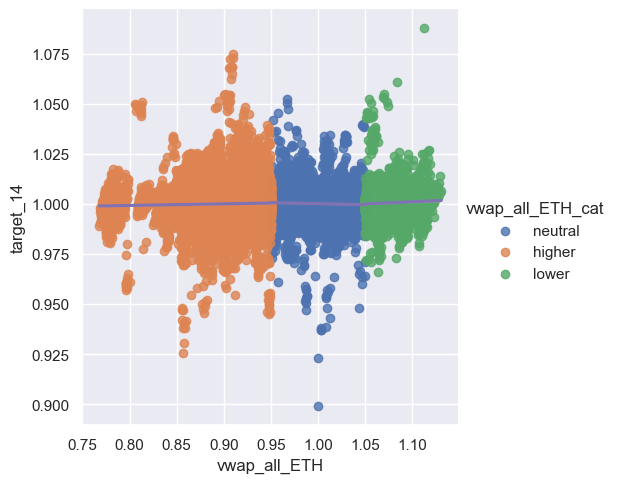

In [80]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

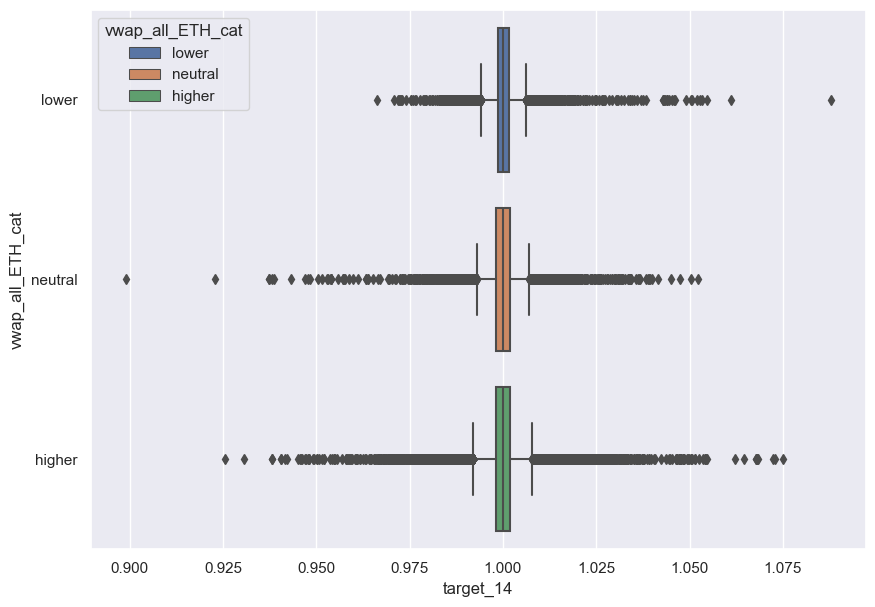

In [81]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

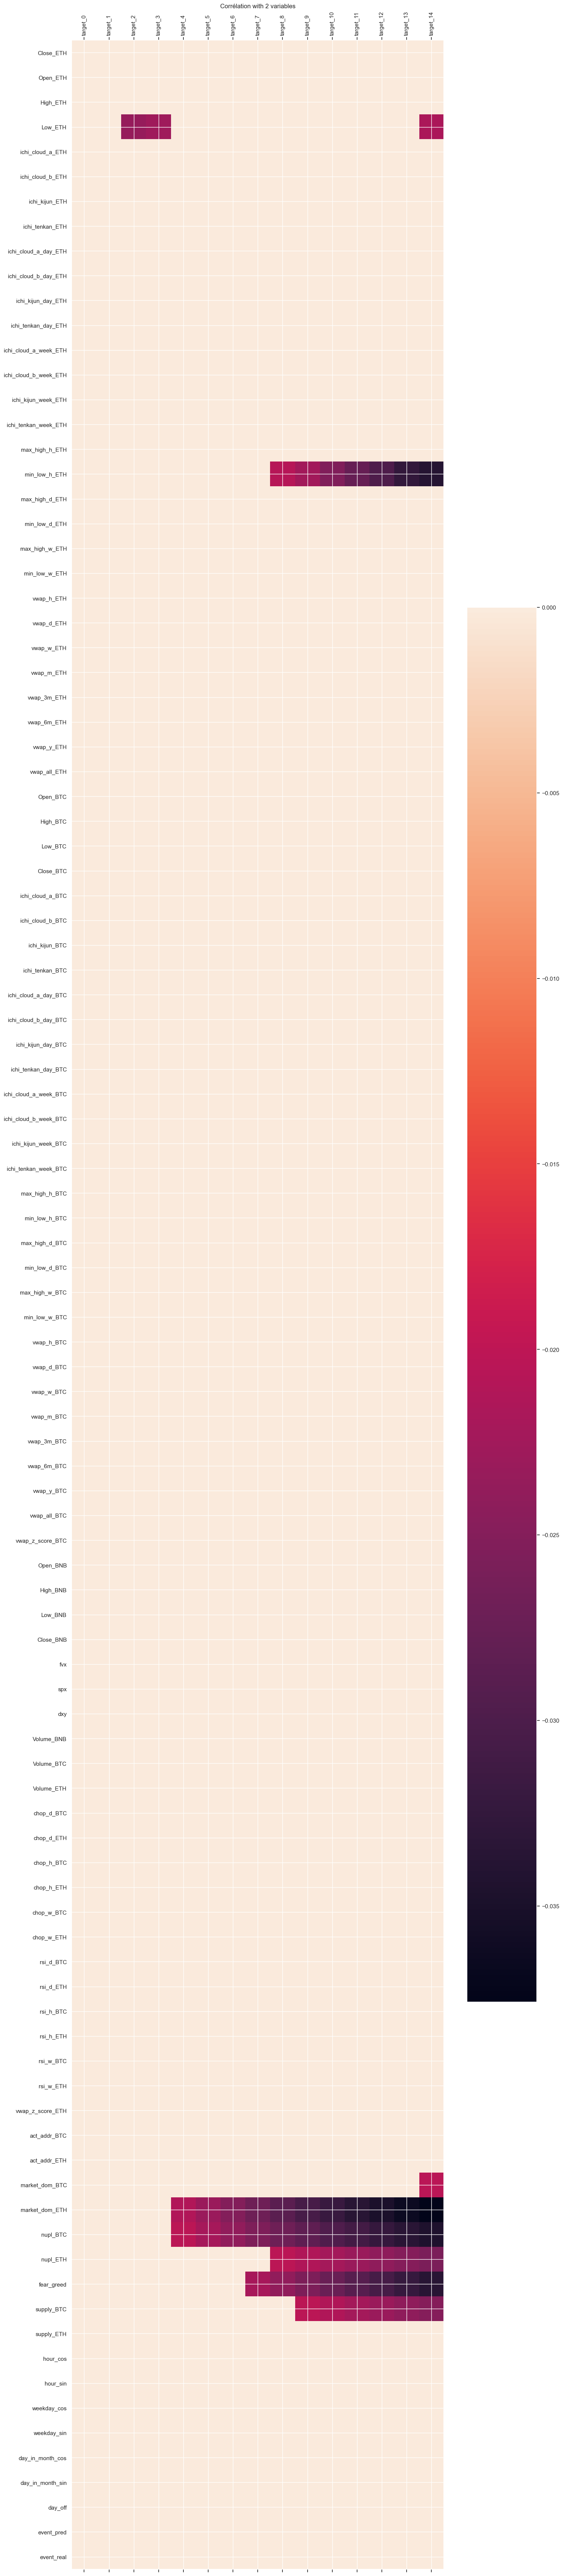

In [82]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

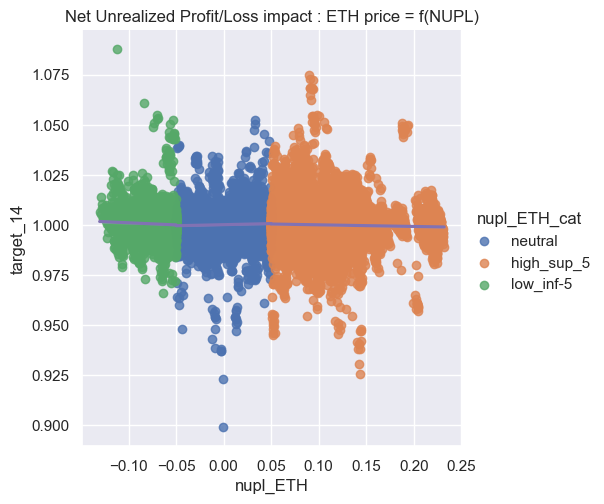

In [83]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

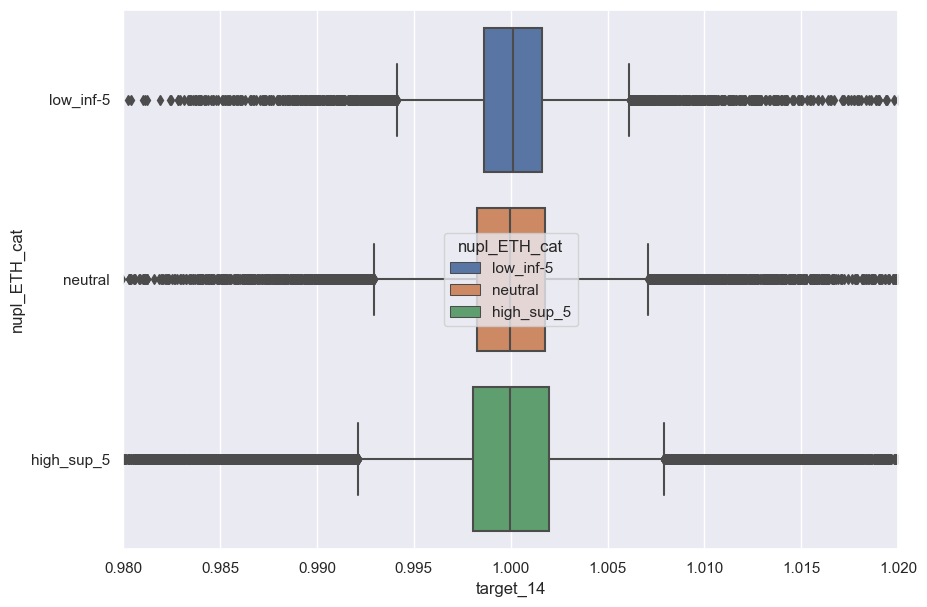

In [84]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [85]:
df["target_14"].describe()

count    80886.000000
mean         1.000073
std          0.005398
min          0.899006
25%          0.998171
50%          1.000006
75%          1.001885
max          1.087790
Name: target_14, dtype: float64

In [86]:
df["target_1"].describe()

count    80886.000000
mean         1.000010
std          0.002004
min          0.907143
25%          0.999288
50%          1.000000
75%          1.000727
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

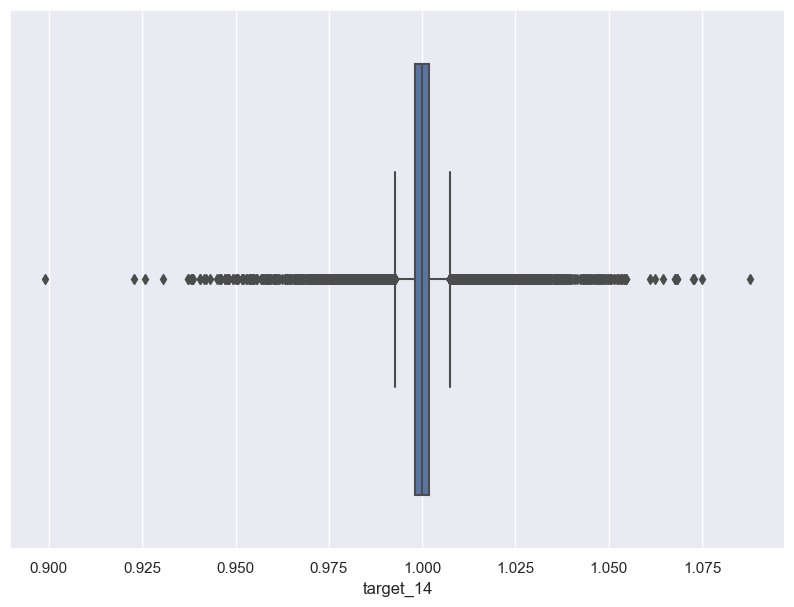

In [87]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [88]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99946702, 1.00028793, 1.00016541, ..., 0.99973657, 1.00024505,
        1.00047172],
       [1.00082135, 1.00069876, 1.00063747, ..., 1.00077844, 1.00100523,
        1.0012688 ],
       [0.99987751, 0.99981627, 0.9997489 , ..., 1.00018373, 1.00044708,
        1.00106565]])

In [89]:
y_train_sca

array([[ 0.10652259,  0.08749806, -0.10486111, ..., -0.03721832,
         0.02831062, -0.04567367],
       [-0.02875422, -0.22102486, -0.05199573, ..., -0.08791442,
        -0.16186466, -0.31187802],
       [-0.20202356, -0.0329817 , -0.15342403, ..., -0.14285891,
        -0.29288356, -0.36472636],
       ...,
       [-0.14431936,  0.06296619,  0.03202805, ..., -0.07625545,
         0.05213784,  0.1093734 ],
       [ 0.19765764,  0.166703  ,  0.15122568, ...,  0.18682352,
         0.2440896 ,  0.31064208],
       [-0.04066768, -0.0561323 , -0.07314338, ...,  0.03665541,
         0.10315327,  0.25934591]])

## Autoencoder

### Model creation

### Training

In [90]:
X_train_sca.shape

(80886, 72, 102)

In [91]:
3*3*3*10*35/3600

2.625

In [92]:
#tf.keras.optimizers.AdamW()

In [93]:
#tf.keras.optimizers.legacy.AdamW()

In [94]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5

epochs = 50 #100 #150 #6 #300
patience = 0 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in [128]: #[32, 64, 128]: #[104]: #
        for encoding_dim in [32]:#[16, 20, 32]:
            for dropout_autoenc in [0.25]: #[0.05, 0.15, 0.25]: #[0.25]:
                for seed in LIST_SEEDS:
                    # check already done ? 
                    #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                    plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                    path_jpg = os.path.join(path_data,
                        f"output_MSE autoencoder - {plt_name}.jpg")
                    if (MODE_TRAIN_AE == False):
                        print(f"BE CAREFUL ! training inactivated => no training done...")
                        continue
                    print(f"Training: {plt_name} ...")
                    # Init
                    tf.keras.backend.clear_session()
                    np.random.seed(seed)
                    random.seed(seed)
                    tf.random.set_seed(seed)
                    # Input dimension
                    input_dim = X_train.shape[-1]
                    # Reduced encoded input dimension
                    # 64/8/0.5
                    # Définir l'encodeur
                    encoder_inputs = keras.Input(shape=(None, input_dim))
                    encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                    #encoder = layers.LayerNormalization()(encoder)
                    #encoder = layers.Dense(encoding_dim, activation='relu')
                    encoder = layers.Dropout(dropout_autoenc)(encoder)
                    encoder_outputs = layers.Dense(encoding_dim)(encoder)
                    encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                    print(encoder_model.summary())
                    # Définir le décodeur
                    decoder_inputs = keras.Input(shape=(None, encoding_dim))
                    decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                    #decoder = layers.LayerNormalization()(decoder)
                    #decoder = layers.Dense(n_unit_enc, activation='relu')
                    decoder = layers.Dropout(dropout_autoenc)(decoder)
                    decoder_outputs = layers.Dense(input_dim)(decoder)
                    decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                    print(decoder_model.summary())
                    # Define complete autoencoder 
                    autoencoder_inputs = keras.Input(shape=(None, input_dim))
                    encoded = encoder_model(autoencoder_inputs)
                    decoded = decoder_model(encoded)
                    autoencoder = keras.Model(autoencoder_inputs, decoded)
                    # Compile : autoencoder
                    optim = tf.keras.optimizers.legacy.Adam()
                    #optim = tf.keras.optimizers.AdamW()
                    #optim = tf.keras.optimizers.Adam()
                    autoencoder.compile(optimizer=optim, loss="mse")
                    # earlystop 
                    es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                                    monitor='val_loss', mode='auto', restore_best_weights=True)
                    # Train
                    if patience == 0:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1)
                    else:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                            epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                            verbose=1, callbacks=[es])

                    plot_train_history(
                        autoenc_step_history,f"MSE autoencoder - {plt_name}",
                        saveFolder=path_data)
                    #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                    #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                                # save the best
                    mse_curr = np.min(autoenc_step_history.history['val_loss'])
                    print("MSE TEST : ", mse_curr)

                    if mse_curr_min == None:
                        seed_min = seed
                        autoenc_step_history_min = autoenc_step_history
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)
                    else:
                        if mse_curr < mse_curr_min:
                            seed_min = seed
                            autoenc_step_history_min = autoenc_step_history
                            mse_curr_min = mse_curr
                            n_unit_enc_min = n_unit_enc
                            encoding_dim_min = encoding_dim
                            dropout_autoenc_min = dropout_autoenc
                            print("Save autoencoder: ", path_mdl_autoencoder)
                            autoencoder.save(path_mdl_autoencoder)
                            print("Save encoder: ", path_mdl_encoder)
                            encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min

print("Load models...")
autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
print(autoencoder.summary())
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print(encoder_model.summary())
n_unit_enc = encoder_model.layers[1].units
dropout_autoenc = encoder_model.layers[2].rate
encoding_dim = encoder_model.layers[3].units
print(f"Model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

if MODE_TRAIN_AE:
    print(f"Best model : seed:{seed} / n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")
    plot_train_history(
        autoenc_step_history_min, 
        f"Best MSE autoencoder - {plt_name}",
        saveFolder=path_data,
    )

Load models...


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 32)          122400    
                                                                 
 model_1 (Functional)        (None, None, 102)         95590     
                                                                 
Total params: 217990 (851.52 KB)
Trainable params: 217990 (851.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                                 

In [95]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [96]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [97]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

2528/2528 [==============================] - 69s 27ms/step


(80886, 72, 102)

### Results

In [98]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

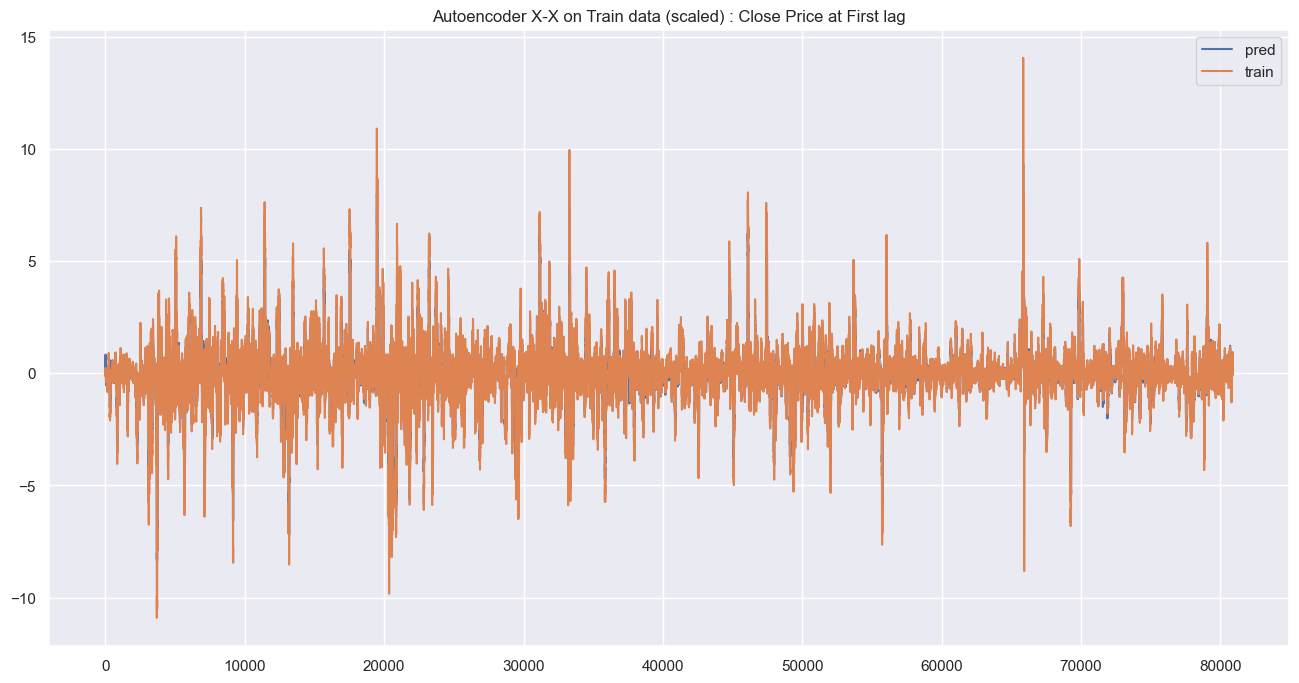

In [99]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [100]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(80886, 72, 102)
(80886, 72, 102)
(72, 102)
(1, 102)


In [101]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.202734  0.199851  0.196052  0.200397          0.201606   
lag_1    0.207134  0.204051  0.199022  0.206747          0.171848   
lag_2    0.208506  0.203863  0.199297  0.208045          0.167524   
lag_3    0.210315  0.204929  0.201169  0.209516          0.164768   
lag_4    0.211189  0.205344  0.201951  0.210264          0.163306   
...           ...       ...       ...       ...               ...   
lag_67   0.123018  0.131238  0.118644  0.126852          0.118873   
lag_68   0.120253  0.129169  0.116209  0.124392          0.118128   
lag_69   0.117404  0.126919  0.113644  0.121746          0.117364   
lag_70   0.114664  0.124519  0.111059  0.118926          0.116579   
lag_71   0.111570  0.122376  0.108240  0.116066          0.115809   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.189274        0.214968         0.210454   
lag_1           0.156000        0.205454         0.209833   
lag_2           0.152424        0.202380         0.206380   
lag_3           0.149790        0.200572         0.203302   
lag_4           0.148773        0.199078         0.200720   
...                  ...             ...              ...   
lag_67          0.124763        0.131713         0.127620   
lag_68          0.124159        0.130176         0.125847   
lag_69          0.123571        0.128585         0.124013   
lag_70          0.122978        0.126952         0.122119   
lag_71          0.122353        0.125265         0.119982   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.192226              0.162984  ...    0.175886  0.406851   
lag_1               0.164143              0.132605  ...    0.131803  0.277363   
lag_2               0.155659              0.127852  ...    0.109112  0.244158   
lag_3               0.150539              0.123881  ...    0.098328  0.232202   
lag_4               0.147937              0.122759  ...    0.093482  0.225350   
...                      ...                   ...  ...         ...       ...   
lag_67              0.143428              0.127978  ...    0.081336  0.203280   
lag_68              0.143466              0.128032  ...    0.081335  0.203259   
lag_69              0.143501              0.128076  ...    0.081345  0.203243   
lag_70              0.143527              0.128117  ...    0.081348  0.203220   
lag_71              0.143552              0.128157  ...    0.081350  0.203188   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.411385     0.371050     0.301686          0.263364   
lag_1   0.305899     0.265760     0.215036          0.164901   
lag_2   0.269971     0.234572     0.188461          0.146849   
lag_3   0.257997     0.219692     0.174004          0.137147   
lag_4   0.249677     0.211728     0.164164          0.133056   
...          ...          ...          ...               ...   
lag_67  0.213181     0.203429     0.141651          0.121558   
lag_68  0.213146     0.203425     0.141636          0.121531   
lag_69  0.213112     0.203424     0.141622          0.121505   
lag_70  0.213076     0.203415     0.141594          0.121479   
lag_71  0.213038     0.203405     0.141553          0.121450   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.314873  0.080946    0.227773    0.239244  
lag_1           0.172495  0.054131    0.104362    0.111622  
lag_2           0.143892  0.045359    0.070938    0.064596  
lag_3           0.128941  0.040335    0.060929    0.052767  
lag_4           0.121583  0.037705    0.057448    0.048271  
...                  ...       ...         ...         ...  
lag_67          0.116911  0.029480    0.048737    0.038217  
lag_68          0.116926  0.029452    0.048660    0.038204  
lag_69          0.116944  0.029427    0.048562    0.038190  
lag_70          0.116959  0.029401    0.048458    0.038177  
lag_71          0.116980  0.02937

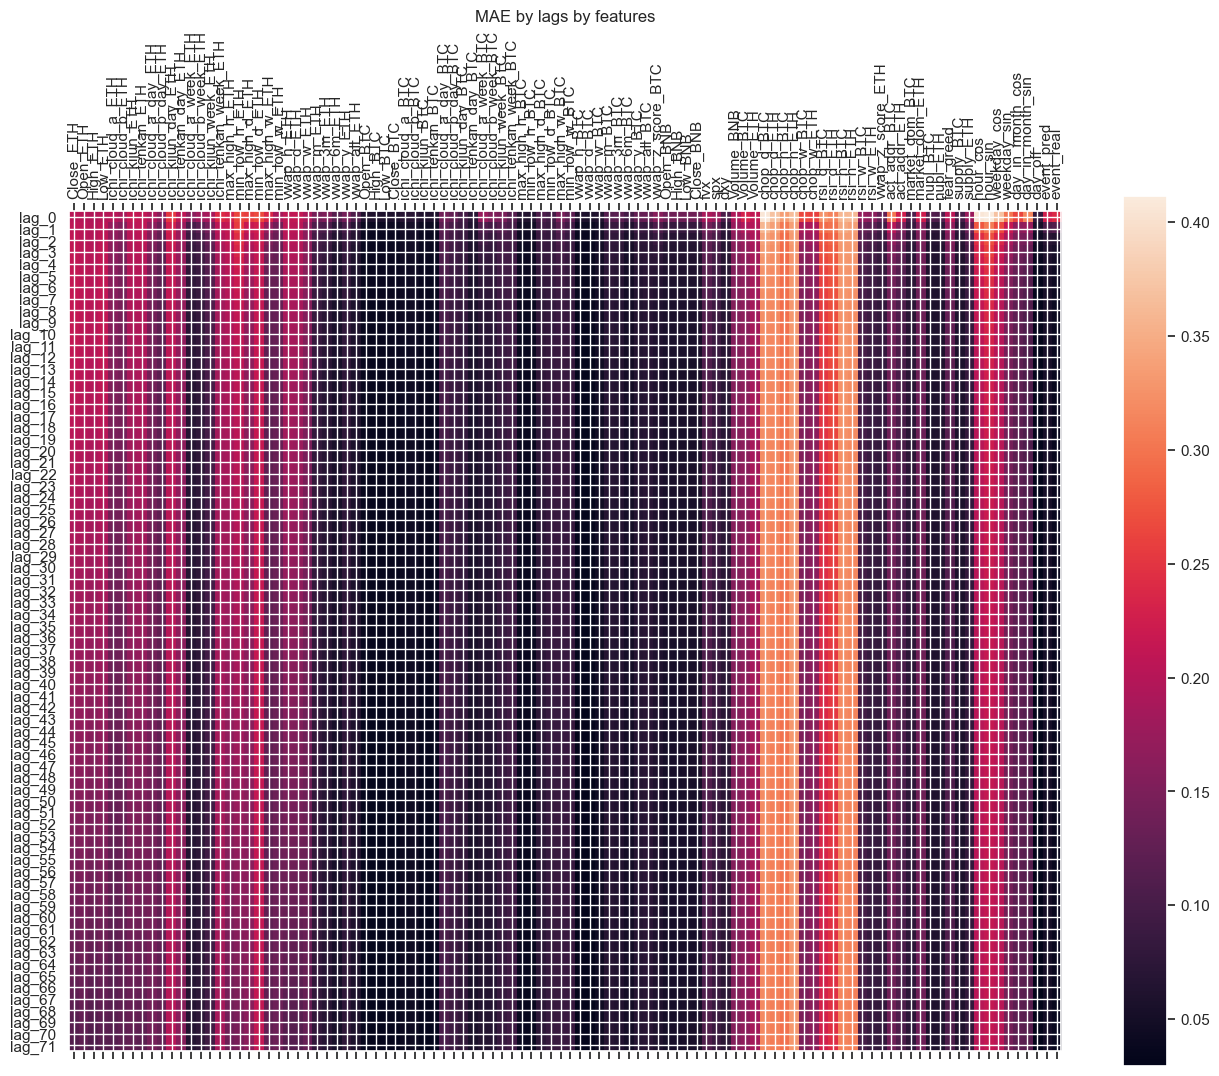

In [102]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

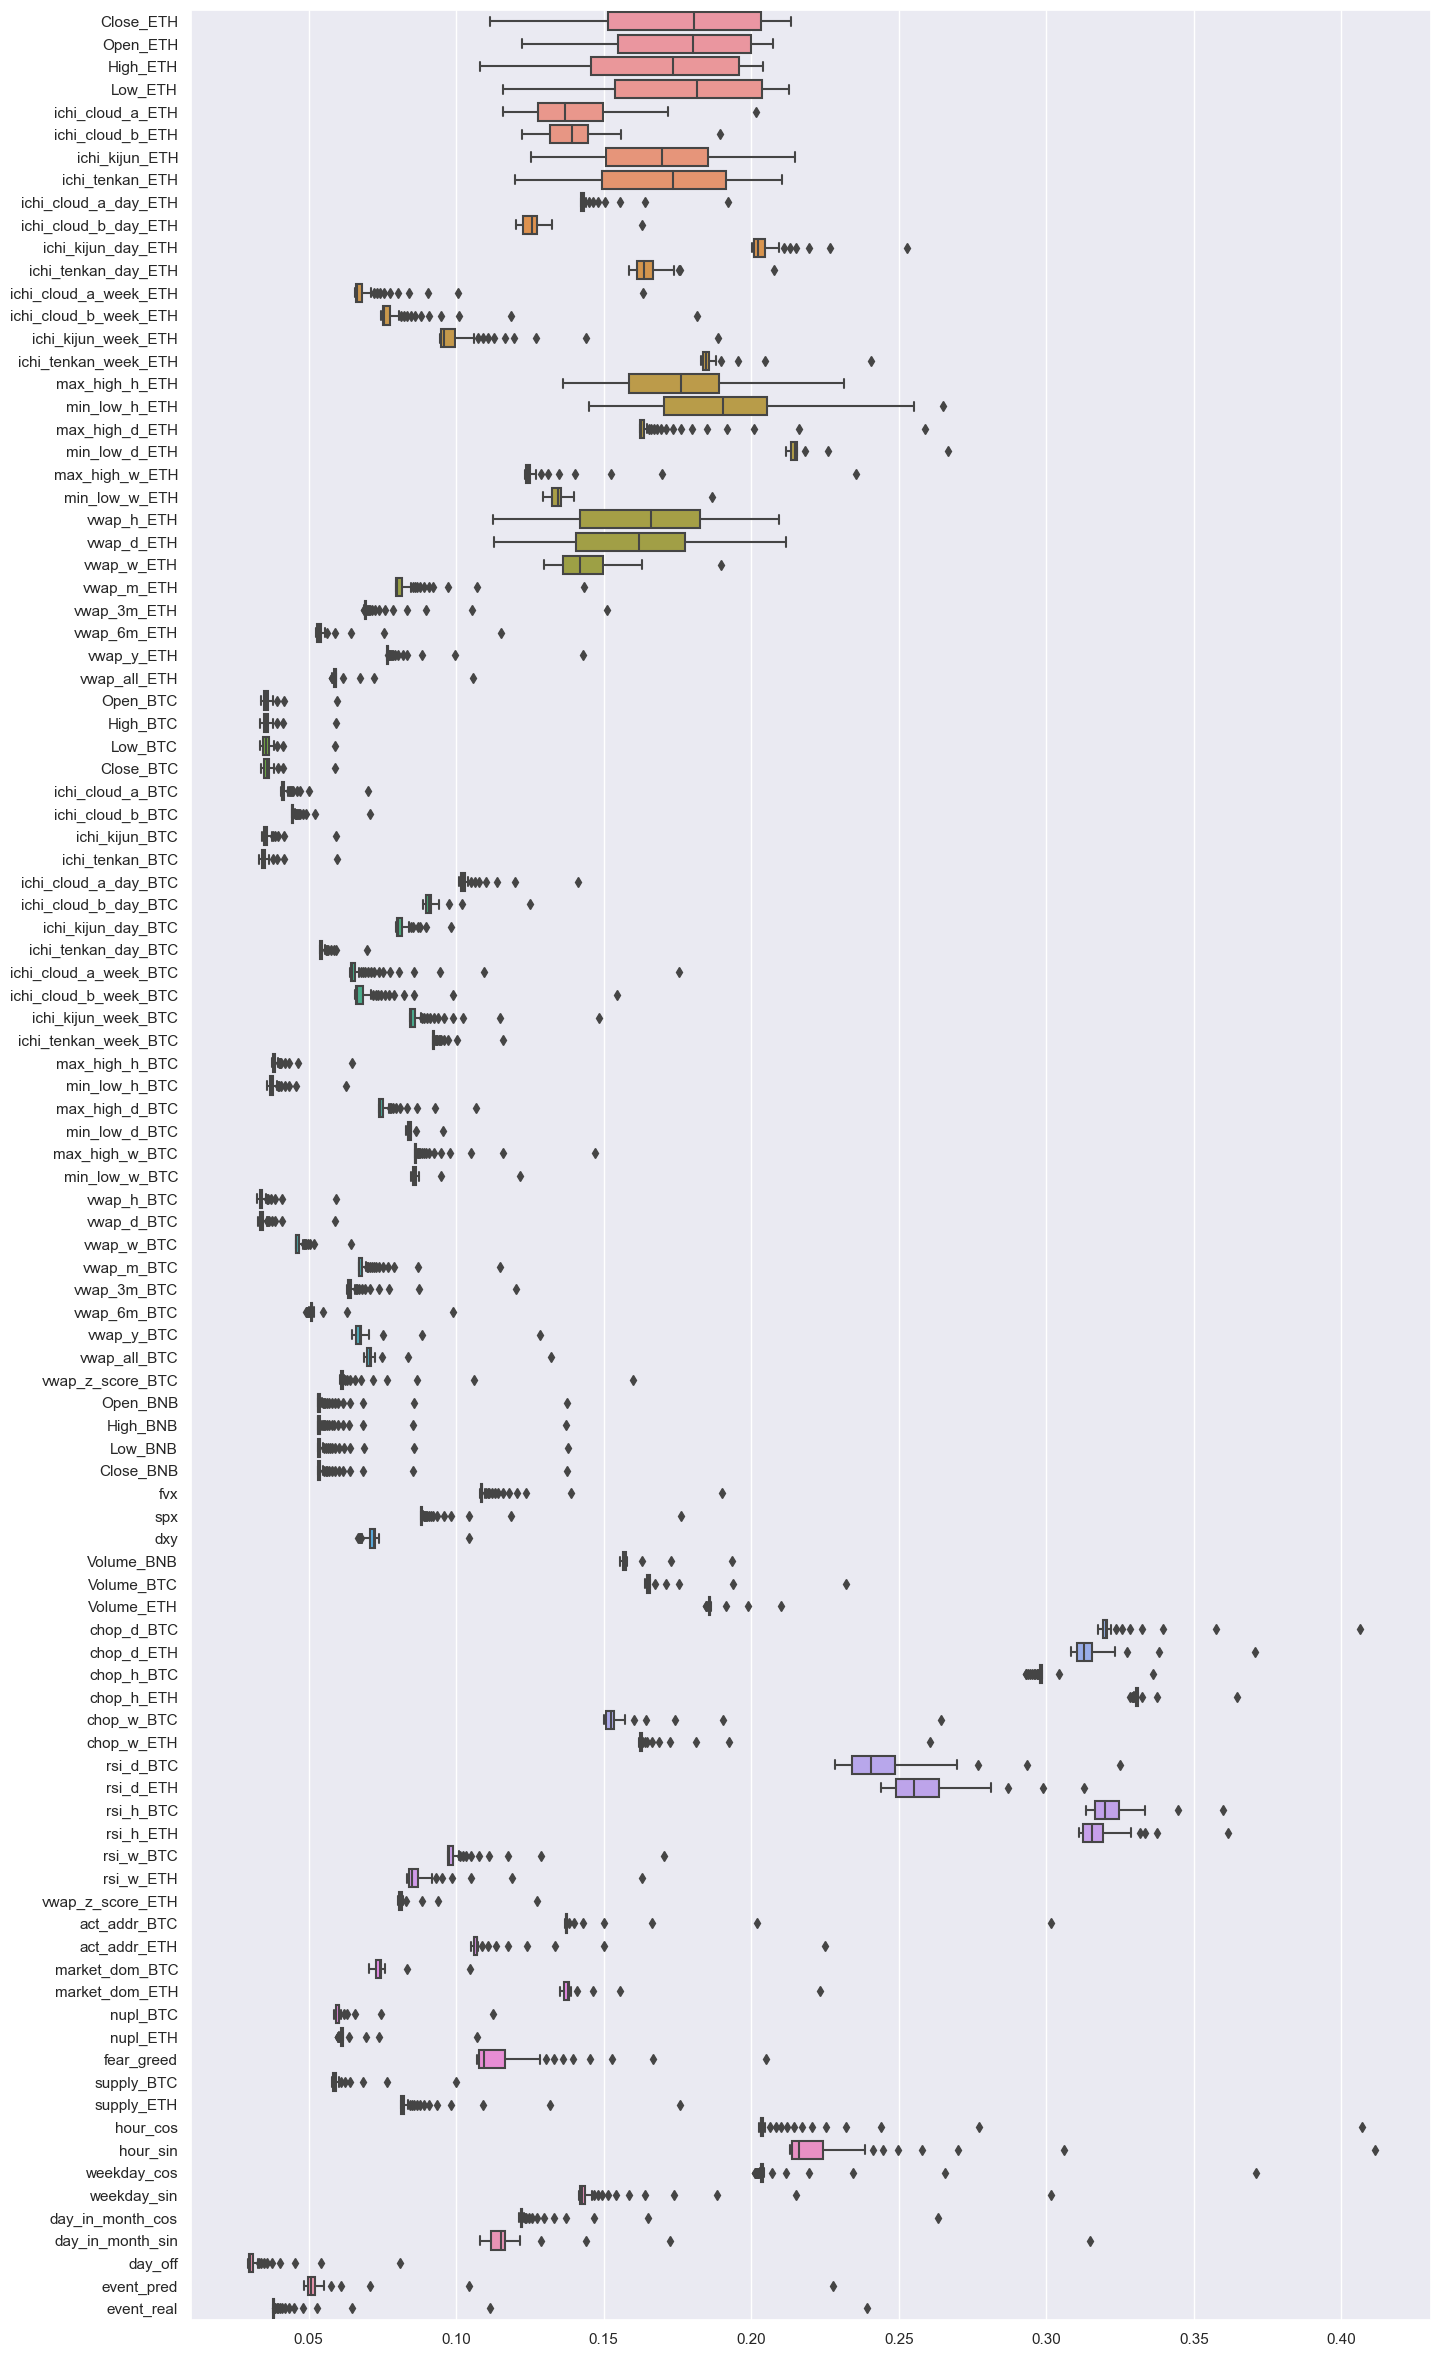

In [103]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [104]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.175503  0.175636  0.168395  0.176618          0.139573   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.138656        0.167876         0.169563              0.144239   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.125572  ...    0.085073  0.209484  0.224491     0.207366   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0     0.148006          0.125746           0.11813  0.03206    0.054488   

   event_real  
0    0.042997  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

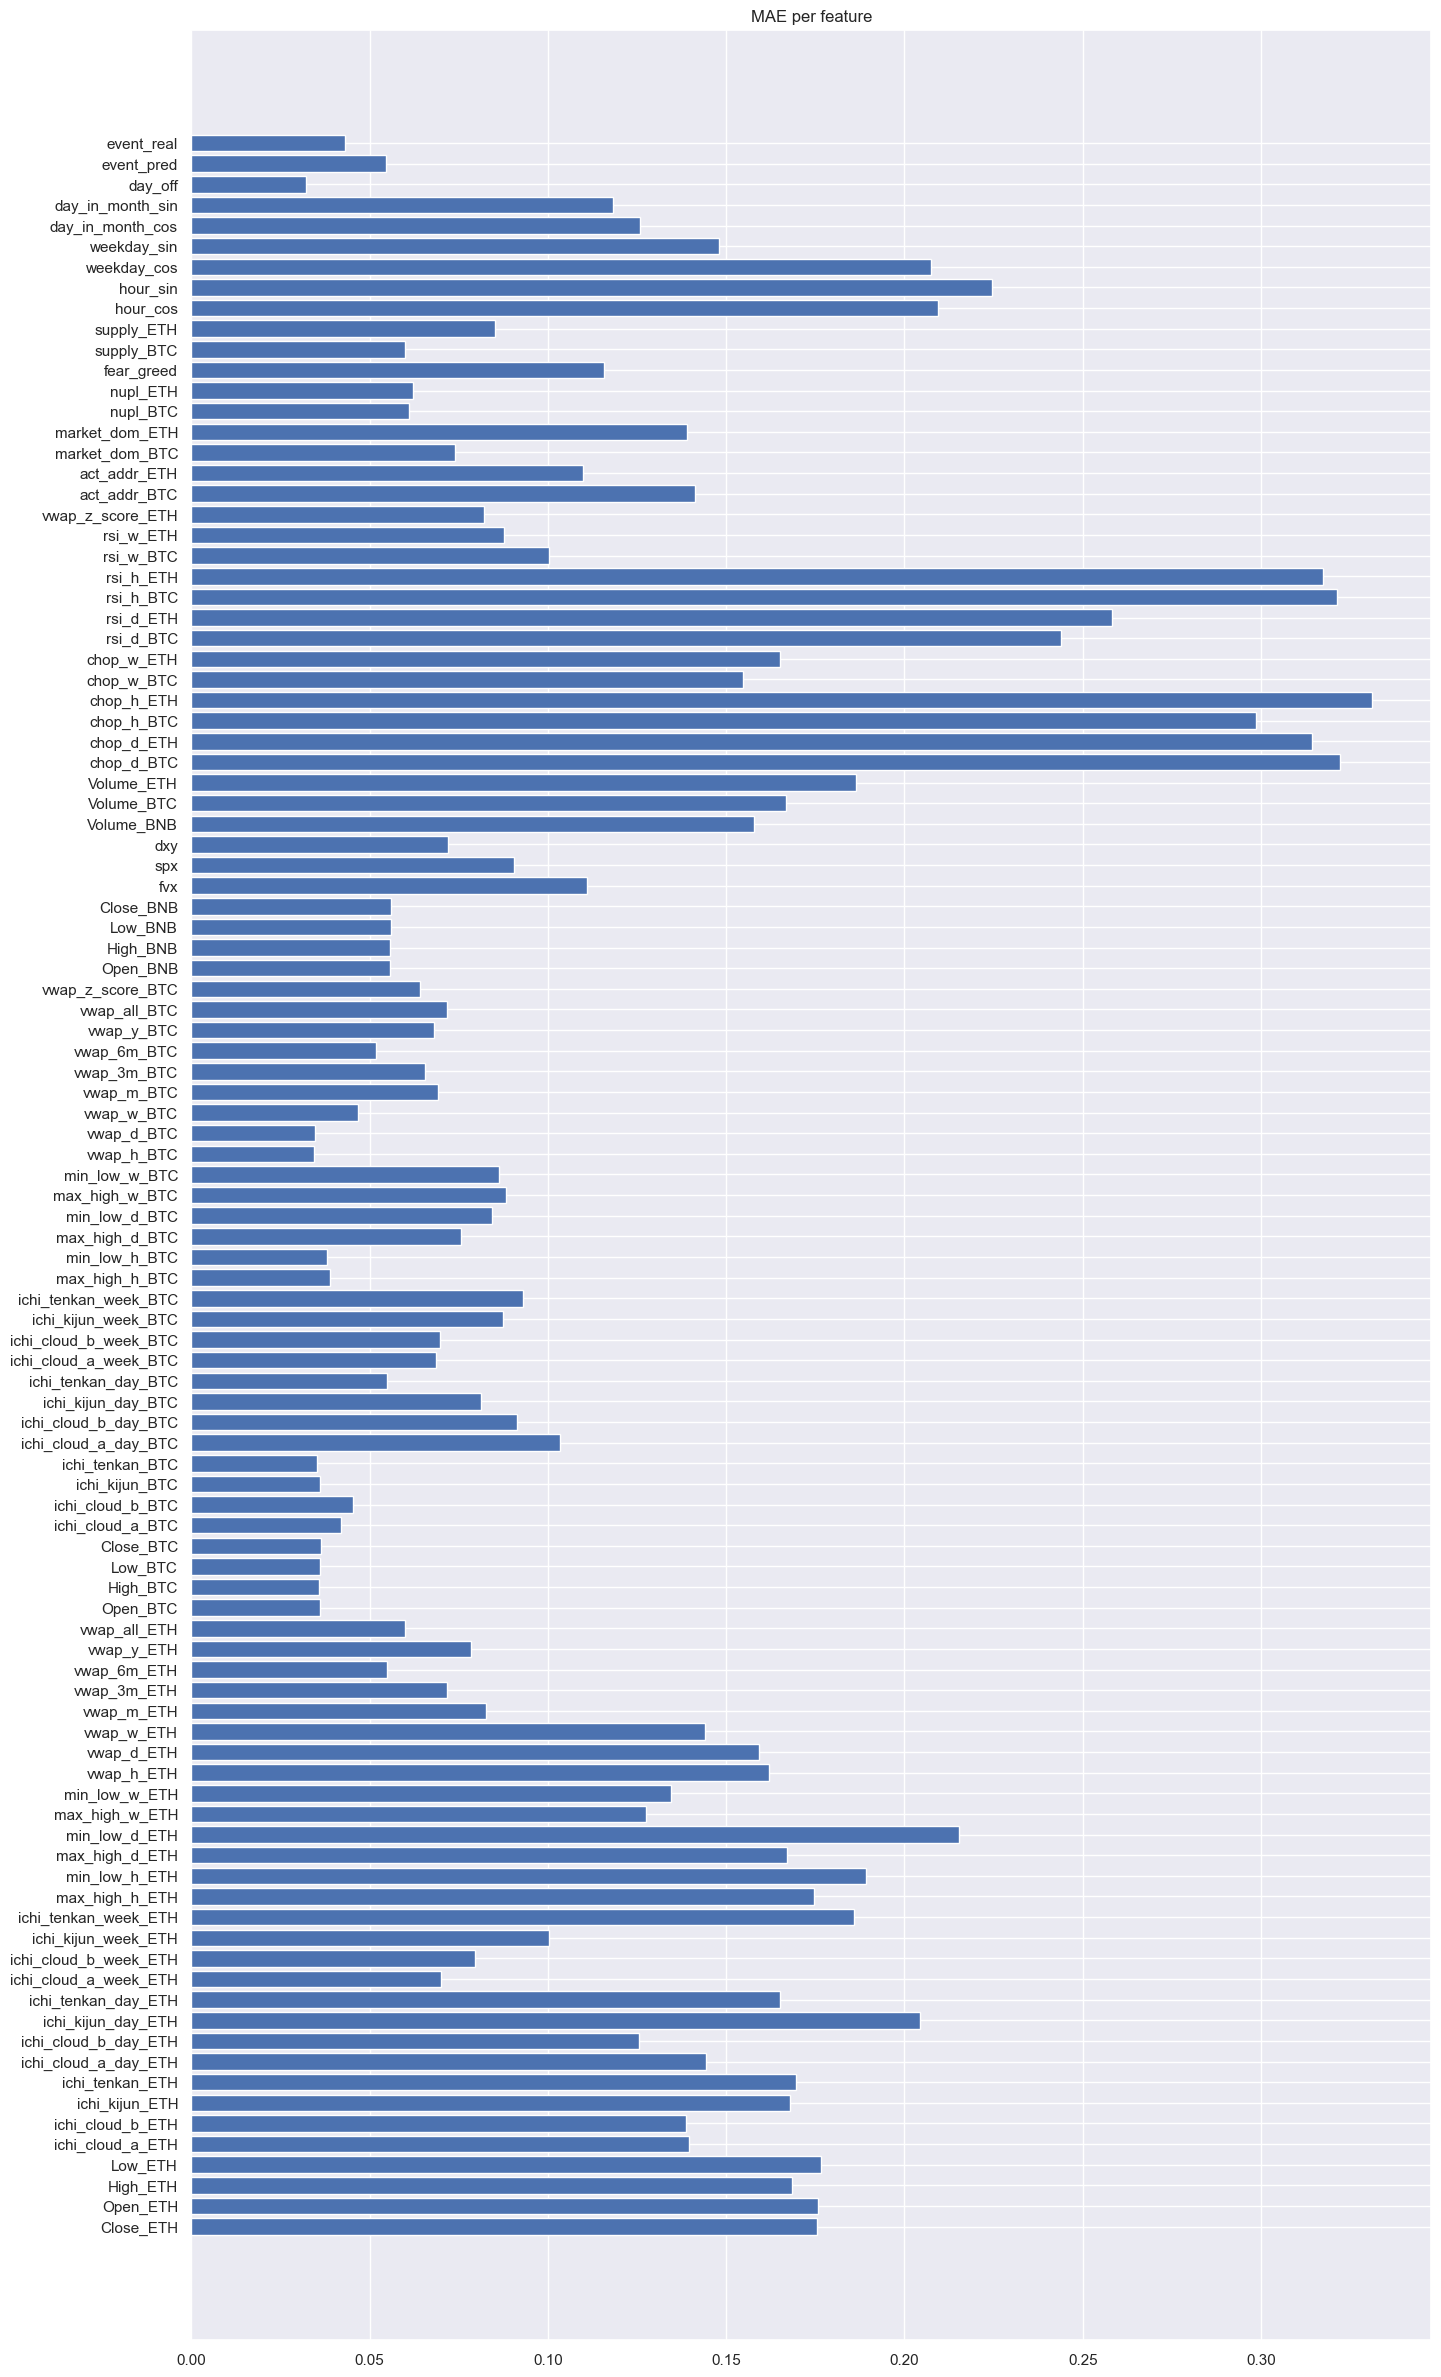

In [105]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [106]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(80886,)
(80886,)
[1196.32 1195.38 1194.55 ... 1634.29 1634.21 1634.95]
[1196.32 1195.38 1194.55]


In [107]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.999738 , 0.9994762, 0.9995486, ..., 0.999321 , 0.9999262,
       0.9993822], dtype=float32)

[1196.32 1195.38 1194.55 ... 1634.29 1634.21 1634.95]


[1201.50123694 1202.03891332 1202.30808914 ... 1634.1460982  1634.36405282
 1634.5710742 ]


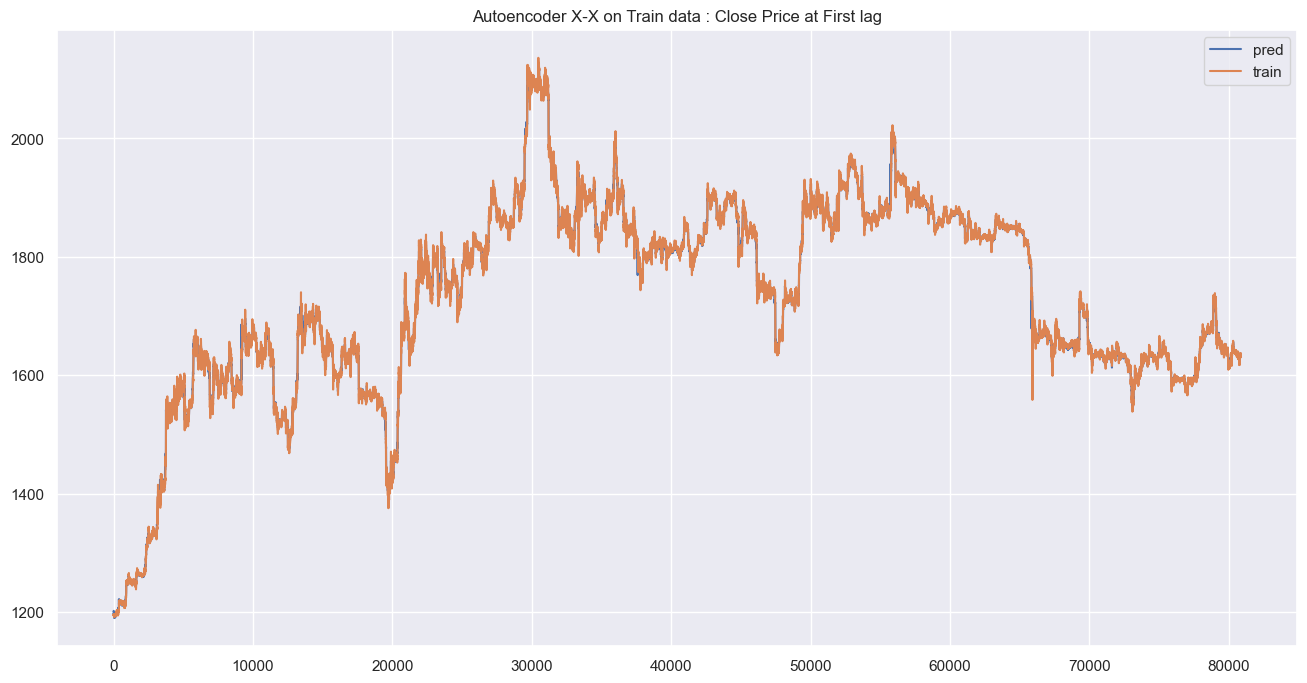

In [108]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [109]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

23/23 [==============================] - 1s 36ms/step


(730, 72, 102)

In [110]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-10-09 03:40:00'

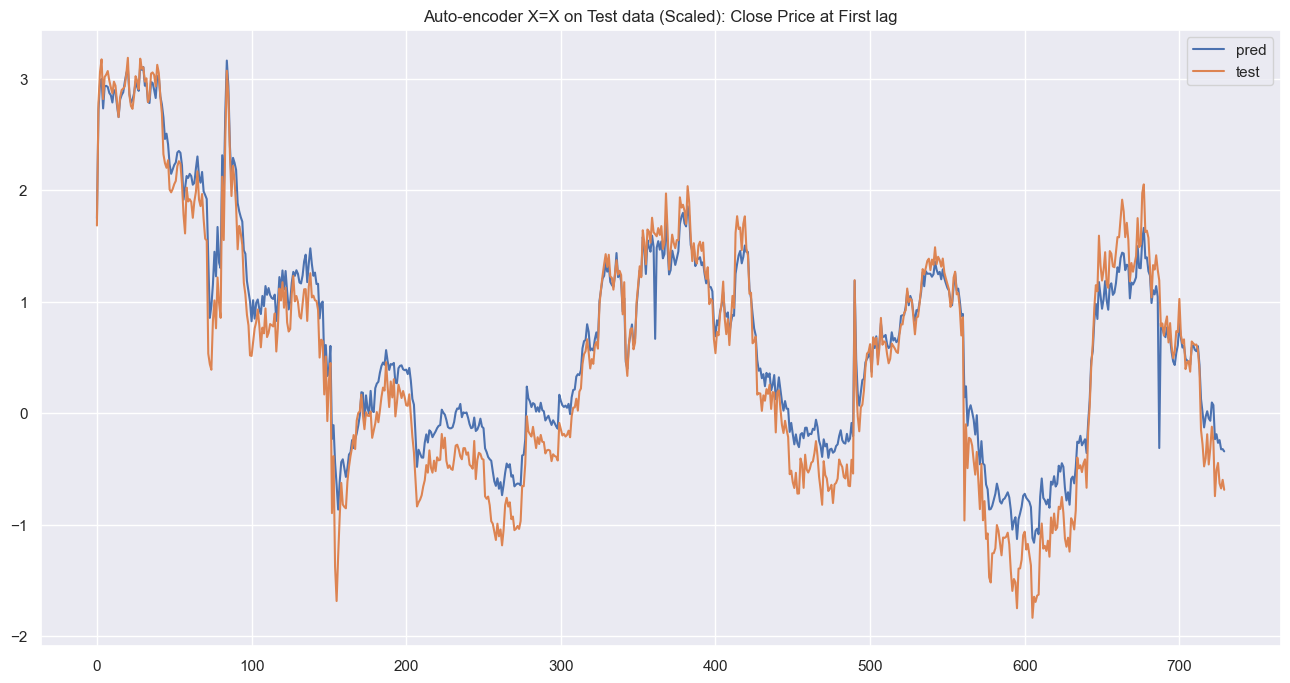

In [111]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [112]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1634.2  1633.93 1633.65 1634.31 1634.14 1634.28 1634.18 1634.7  1634.71]
X test pred :  [1635.06498817 1633.11575546 1632.2879069  1631.99293296 1633.02851105
 1633.19006633 1632.84286487 1632.81072963 1633.24156526]


[1634.2  1633.93 1633.65 1634.31 1634.14 1634.28 1634.18 1634.7  1634.71
 1634.07 1634.3  1633.57 1633.31 1632.6  1632.62 1632.91 1632.64 1633.09
 1632.6  1631.78 1632.05 1631.31 1630.66 1629.48 1629.17 1628.74 1628.54
 1628.81 1628.61 1629.25 1627.92 1629.74 1629.37 1629.17 1629.66 1629.48
 1629.47 1629.   1628.46 1628.08 1626.55 1625.57 1624.21 1620.36 1620.81
 1618.84 1620.9  1619.85 1621.01 1620.86 1620.73 1621.31 1621.04 1621.79
 1621.09 1620.99 1620.4  1615.02 1619.61 1617.4  1616.66 1615.11 1614.51
 1616.21 1616.69 1617.76 1616.69 1616.38 1615.88 1615.13 1611.52 1611.87
 1597.23 1593.38 1592.57 1597.   1594.58 1594.2  1594.3  1595.41 1595.59
 1596.49 1594.43 1594.64 1595.9  1597.6  1595.57 1594.48 1594.77 1594.02
 1591.8  1590.19 1593.78 1594.4  1593.58 1591.81 1589.08 1589.41 1590.65
 1586.94 1588.71 1587.26 1590.68 1589.94 1592.49 1592.45 1589.5  1589.36
 1589.2  1589.98 1587.13 1586.57 1588.32 1588.94 1589.9  1591.39 1589.99
 1591.13 1593.51 1594.98 1594.44 1593.75 1593.94 15

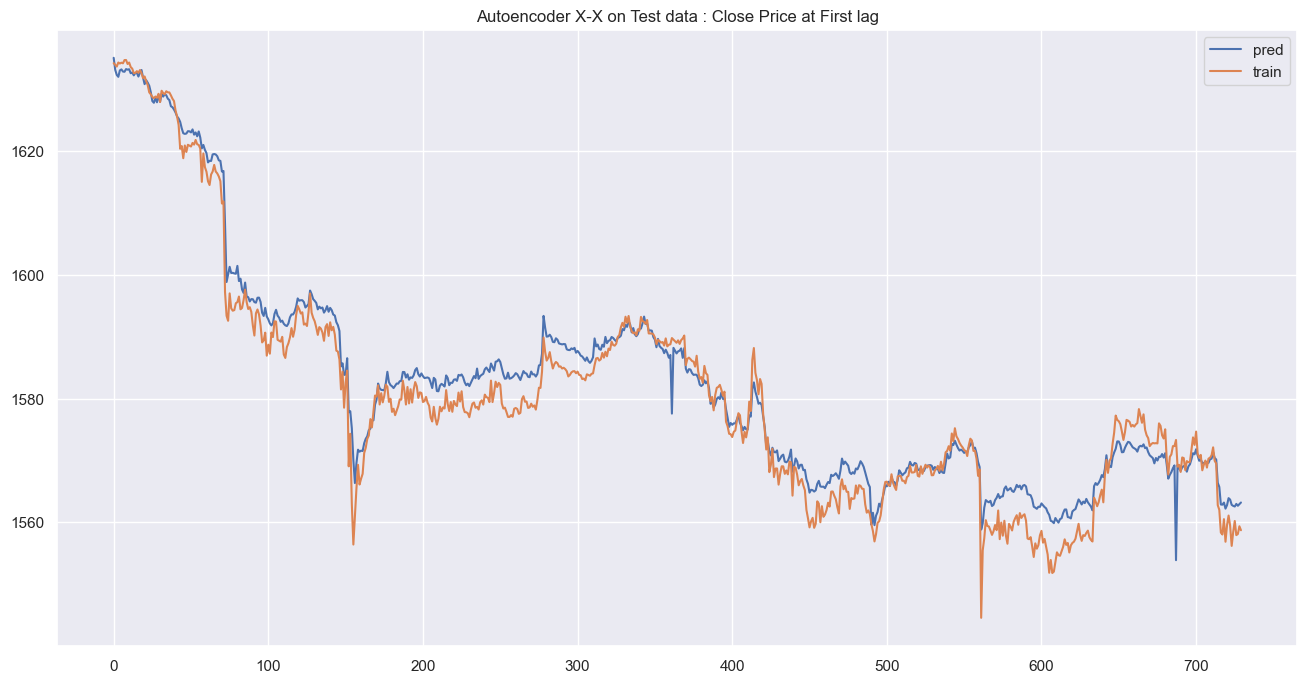

In [113]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [114]:
X_test_sca.shape

(730, 72, 102)

In [115]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.2788877703367389

In [116]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(730, 72, 102)
(730, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.202734  0.199851  0.196052  0.200397          0.201606   
lag_1    0.207134  0.204051  0.199022  0.206747          0.171848   
lag_2    0.208506  0.203863  0.199297  0.208045          0.167524   
lag_3    0.210315  0.204929  0.201169  0.209516          0.164768   
lag_4    0.211189  0.205344  0.201951  0.210264          0.163306   
...           ...       ...       ...       ...               ...   
lag_67   0.109560  0.121827  0.098943  0.123021          0.128647   
lag_68   0.104374  0.119318  0.094010  0.119973          0.127541   
lag_69   0.101623  0.115579  0.090031  0.117165          0.126568   
lag_70   0.099232  0.111650  0.086978  0.115265          0.125404   
lag_71   0.093824  0.111317  0.082700  0.112600          0.124380   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.189274        0.214968         0.210454   
lag_1           0.156000        0.205454         0.209833   
lag_2           0.152424        0.202380         0.206380   
lag_3           0.149790        0.200572         0.203302   
lag_4           0.148773        0.199078         0.200720   
...                  ...             ...              ...   
lag_67          0.124154        0.138756         0.128852   
lag_68          0.123806        0.135581         0.127535   
lag_69          0.123254        0.132832         0.126512   
lag_70          0.122902        0.130301         0.125599   
lag_71          0.122584        0.127047         0.123773   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.192226              0.162984  ...  0.406851  0.411385   
lag_1               0.164143              0.132605  ...  0.277363  0.305899   
lag_2               0.155659              0.127852  ...  0.244158  0.269971   
lag_3               0.150539              0.123881  ...  0.232202  0.257997   
lag_4               0.147937              0.122759  ...  0.225350  0.249677   
...                      ...                   ...  ...       ...       ...   
lag_67              0.146446              0.103749  ...  0.227606  0.223036   
lag_68              0.146758              0.103575  ...  0.227823  0.222638   
lag_69              0.147194              0.103577  ...  0.228012  0.222121   
lag_70              0.147517              0.103533  ...  0.228138  0.221608   
lag_71              0.147902              0.103531  ...  0.228299  0.221304   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.371050     0.301686          0.263364          0.314873   
lag_1      0.265760     0.215036          0.164901          0.172495   
lag_2      0.234572     0.188461          0.146849          0.143892   
lag_3      0.219692     0.174004          0.137147          0.128941   
lag_4      0.211728     0.164164          0.133056          0.121583   
...             ...          ...               ...               ...   
lag_67     0.180565     0.379907          0.226382          0.140059   
lag_68     0.180280     0.380525          0.226900          0.140443   
lag_69     0.179925     0.381010          0.227306          0.140826   
lag_70     0.179573     0.381557          0.227596          0.141266   
lag_71     0.179390     0.382158          0.227930          0.141609   

         day_off  event_pred  event_real  dataset  
lag_0   0.080946    0.227773    0.239244    TRAIN  
lag_1   0.054131    0.104362    0.111622    TRAIN  
lag_2   0.045359    0.070938    0.064596    TRAIN  
lag_3   0.040335    0.060929    0.052767    TRAIN  
lag_4   0.037705    0.057448    0.048271    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.022515    0.095539    0.086109     TEST  
lag_68  0.022526    0.095673    0.085931     TEST  
lag_69  0.022505    0.095837    0.085644     TEST  
lag_70  0.022500    0.096065    0.085426     TEST  
lag_71  0.022512    0.096231    0.085207     TEST  

[144 ro

In [117]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.181568  0.182796  0.172443  0.187162          0.151645   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.146325        0.186174          0.18305              0.119041   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0               0.11869  ...    0.284266  0.230552  0.238397     0.199313   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0     0.368151          0.210401          0.131244  0.03473     0.09043   

   event_real  
0    0.091948  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

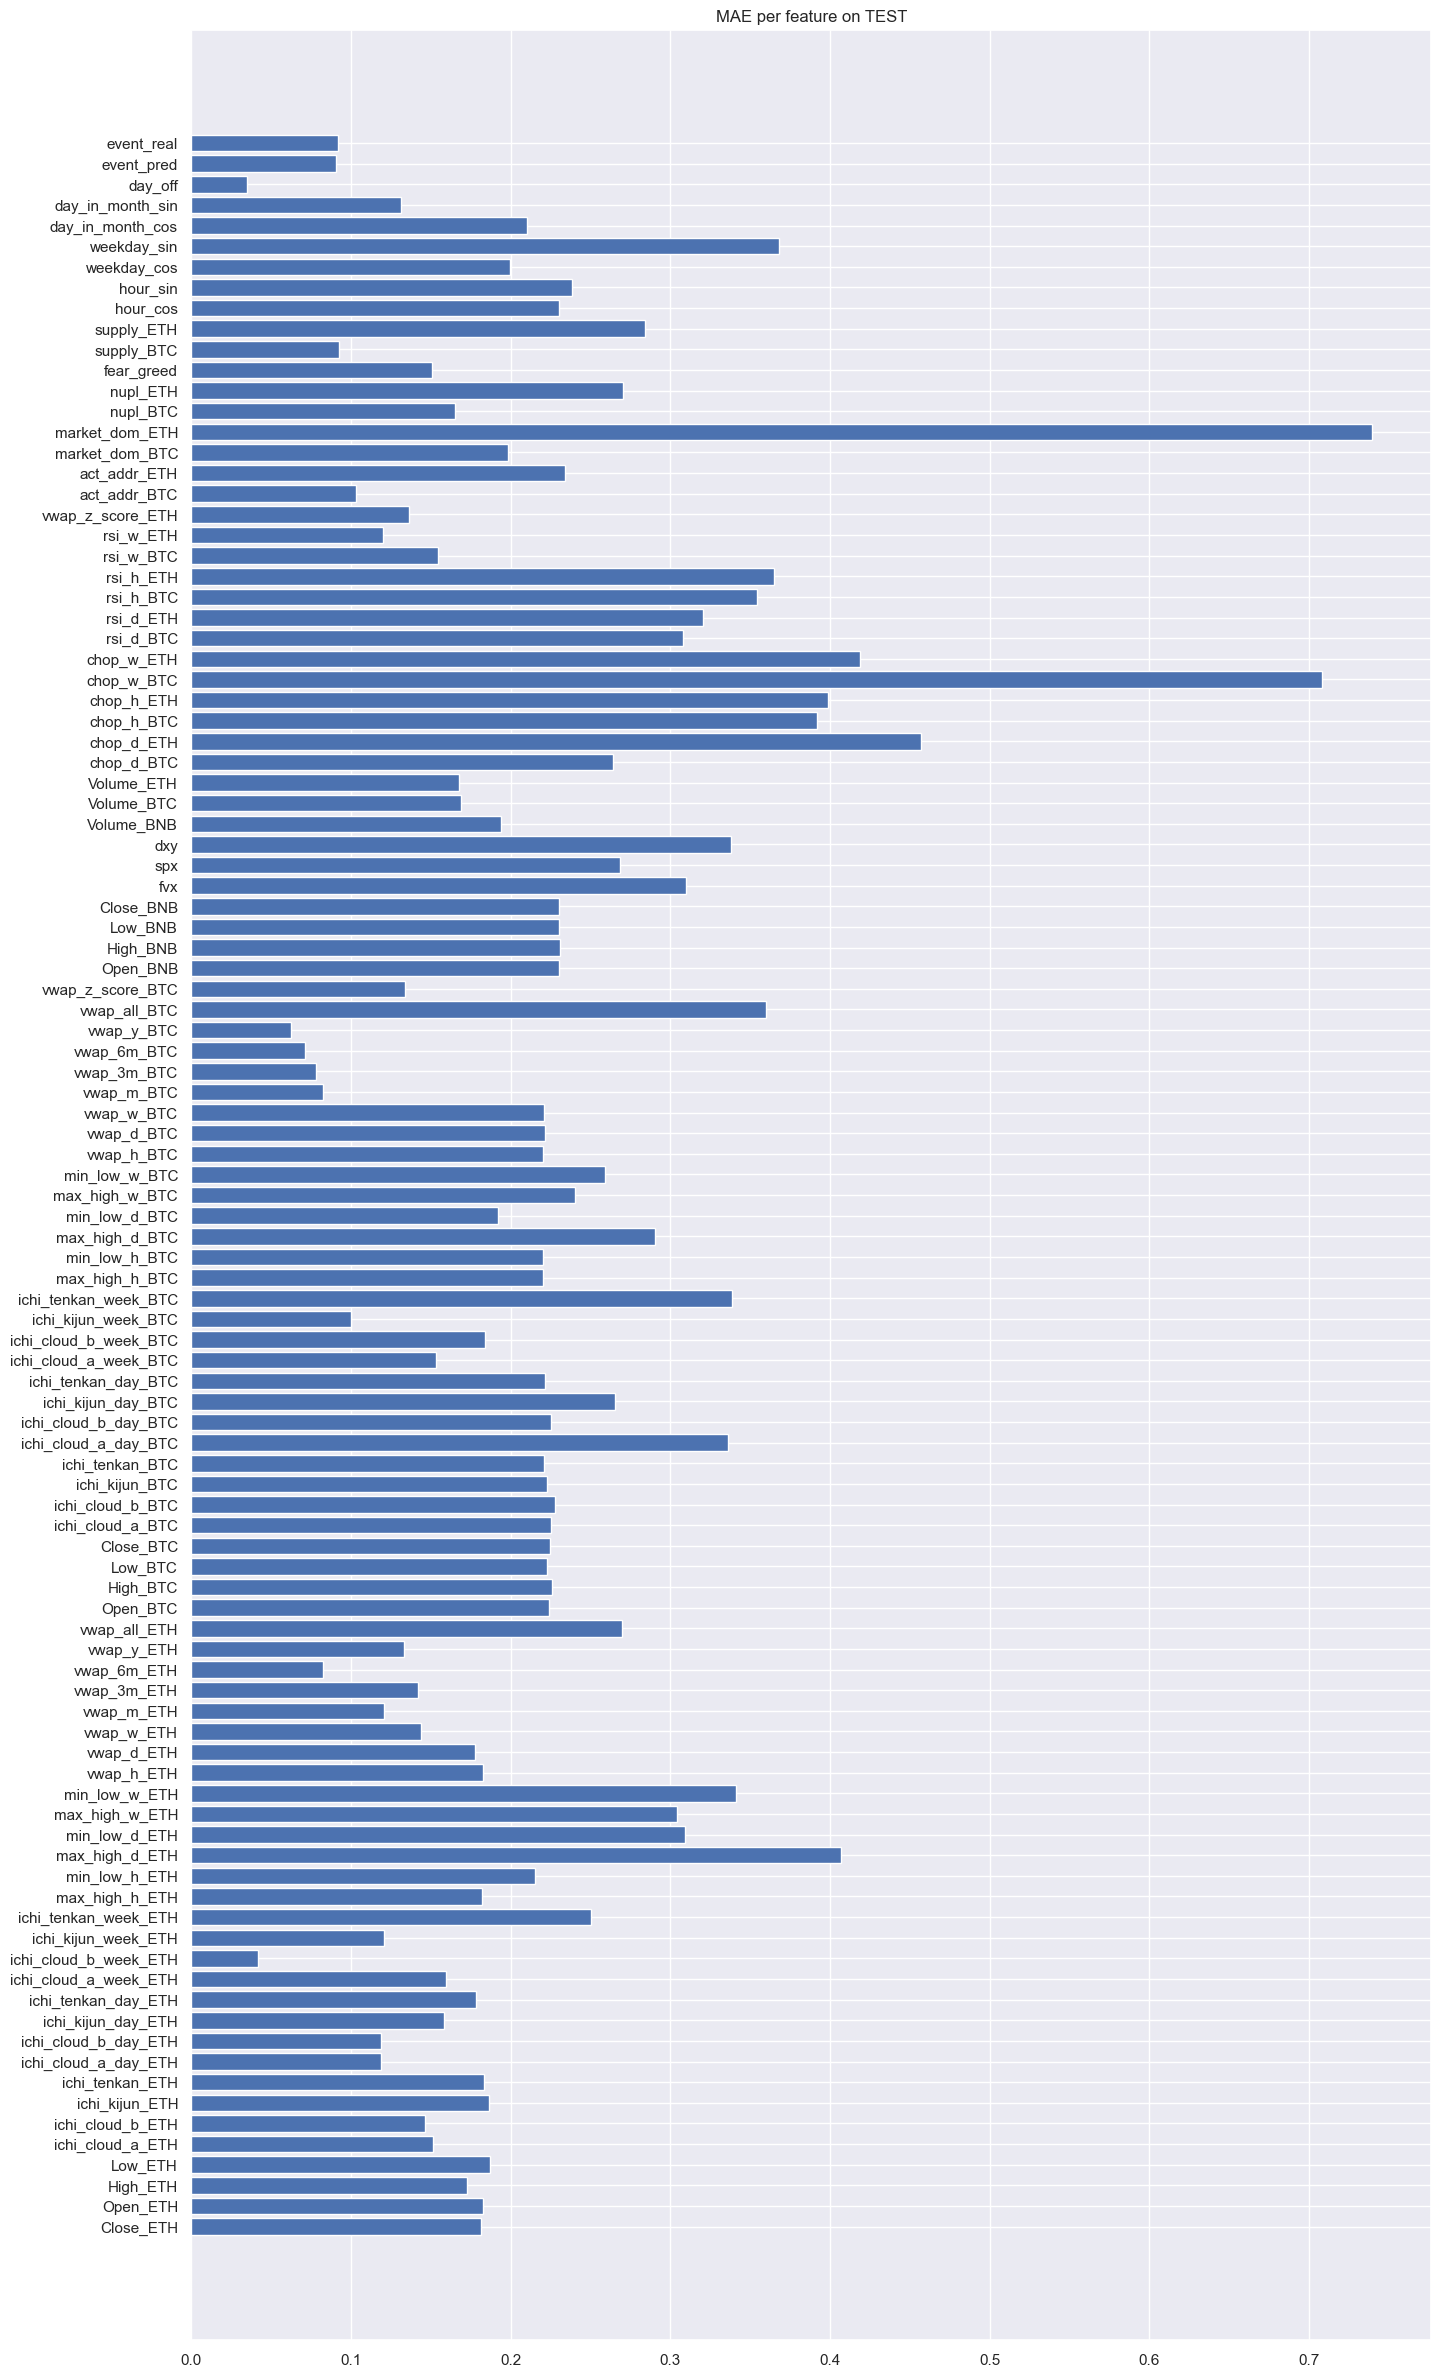

In [118]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [119]:
df_mae_ae_test_feat.values[0]

array([0.18156792, 0.18279576, 0.17244305, 0.18716201, 0.15164505,
       0.14632508, 0.18617407, 0.18304976, 0.11904121, 0.1186898 ,
       0.15806404, 0.17819135, 0.1592976 , 0.04149488, 0.12057841,
       0.25008881, 0.18222514, 0.2152307 , 0.40659768, 0.30902903,
       0.30399393, 0.3413549 , 0.18242579, 0.17777514, 0.1437519 ,
       0.12066823, 0.14208151, 0.08242087, 0.13293781, 0.26981994,
       0.2243106 , 0.22581462, 0.22280278, 0.22441472, 0.22547512,
       0.22791955, 0.22252396, 0.22100568, 0.33607721, 0.22505718,
       0.26514206, 0.22133281, 0.15320682, 0.18361871, 0.10017676,
       0.33840049, 0.22045782, 0.22043015, 0.29042051, 0.19180828,
       0.24019246, 0.25913944, 0.22039326, 0.22145825, 0.22077323,
       0.08262896, 0.07795011, 0.07107734, 0.06216345, 0.36022643,
       0.13377177, 0.23049176, 0.23100999, 0.23021653, 0.23058164,
       0.30966185, 0.26834322, 0.33822996, 0.19387782, 0.16903424,
       0.16769795, 0.26427731, 0.457091  , 0.39211382, 0.39902

In [120]:
2/df_mae_ae_test_feat.values[0].sum()

0.08835133194551113

In [121]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.202734
1       TRAIN   Close_ETH  0.207134
2       TRAIN   Close_ETH  0.208506
3       TRAIN   Close_ETH  0.210315
4       TRAIN   Close_ETH  0.211189
...       ...         ...       ...
14683    TEST  event_real  0.086109
14684    TEST  event_real  0.085931
14685    TEST  event_real  0.085644
14686    TEST  event_real  0.085426
14687    TEST  event_real  0.085207

[14688 rows x 3 columns]

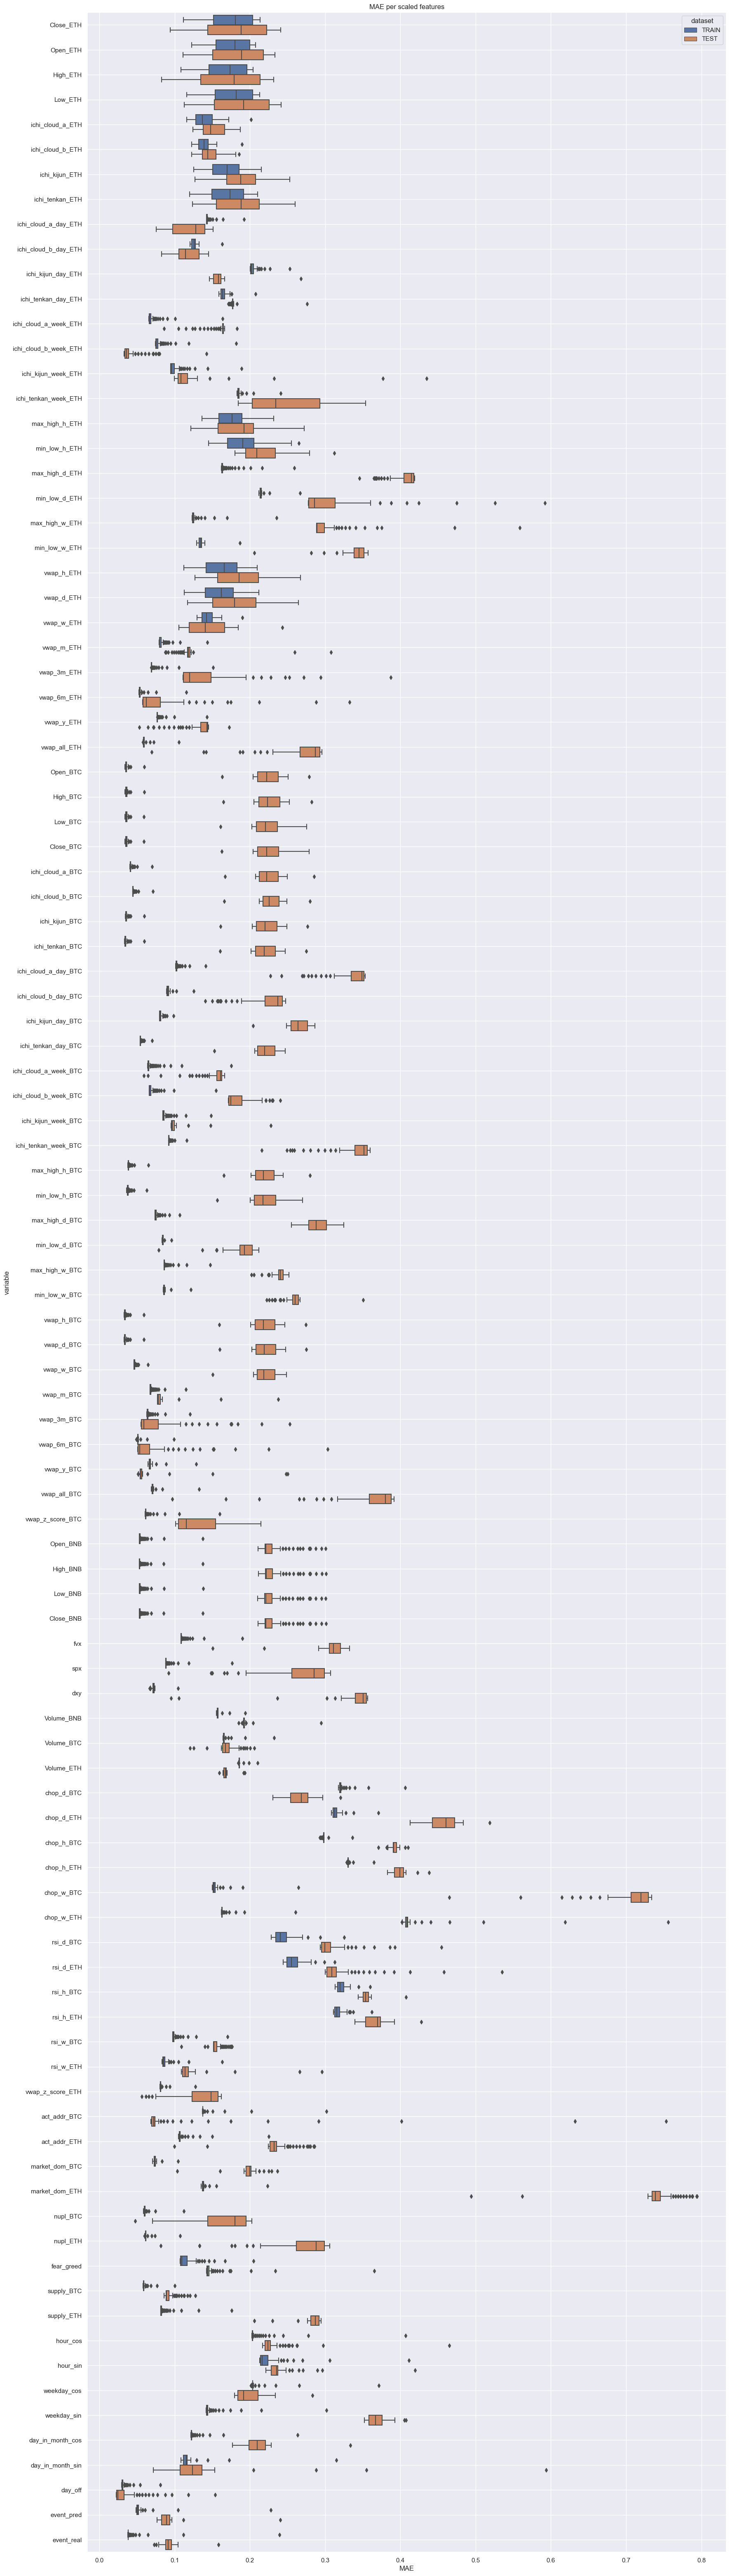

In [122]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [123]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(80886, 72, 102)
(80886, 72, 102)
(72, 102)
(730, 72, 102)
(730, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [124]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.062205  0.061471  0.057569  0.061188          0.041126   
0   0.055182  0.055115  0.048867  0.058537          0.036349   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.039381        0.055155         0.055079              0.038186   
0          0.037342        0.058030         0.053653              0.020816   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.028537  ...  0.059123  0.066340     0.058245     0.033008   
0              0.018468  ...  0.081125  0.086129     0.054531     0.163647   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0          0.025543          0.021852  0.011077    0.012590    0.012681   
0          0.073487          0.032587  0.004800    0.115063    0.240679   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

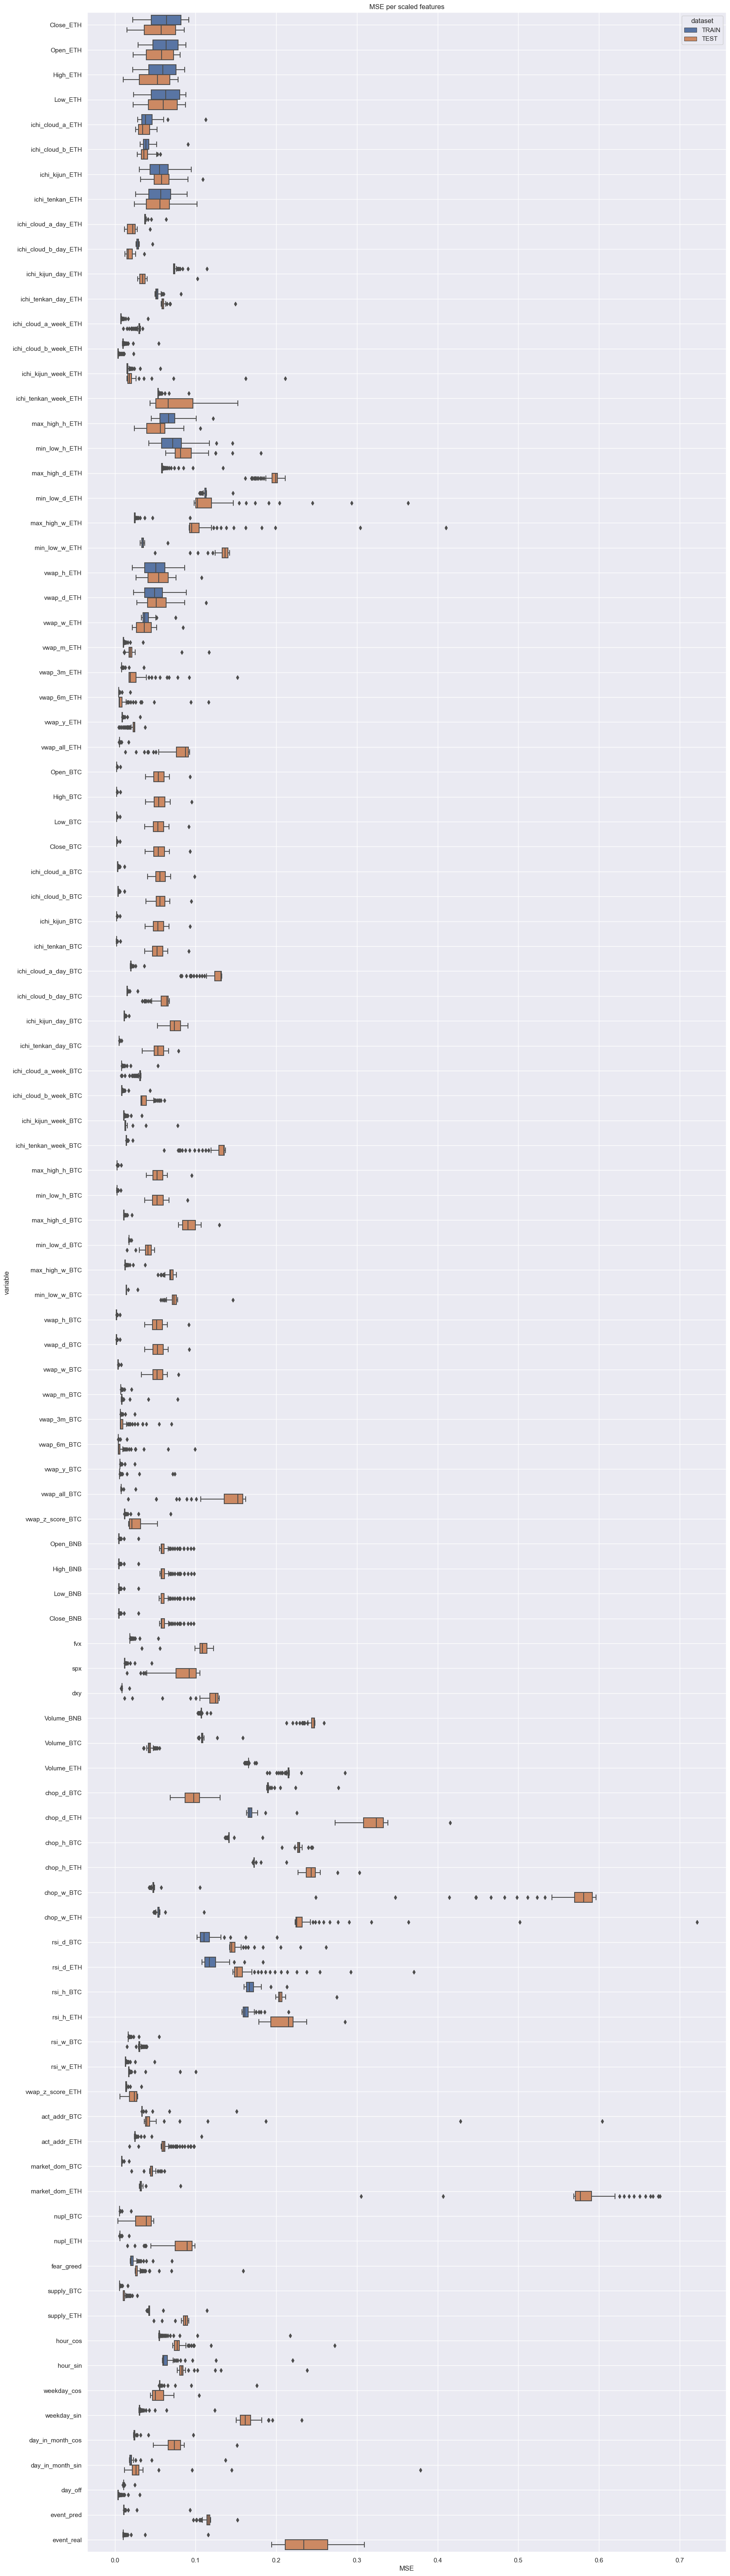

In [125]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

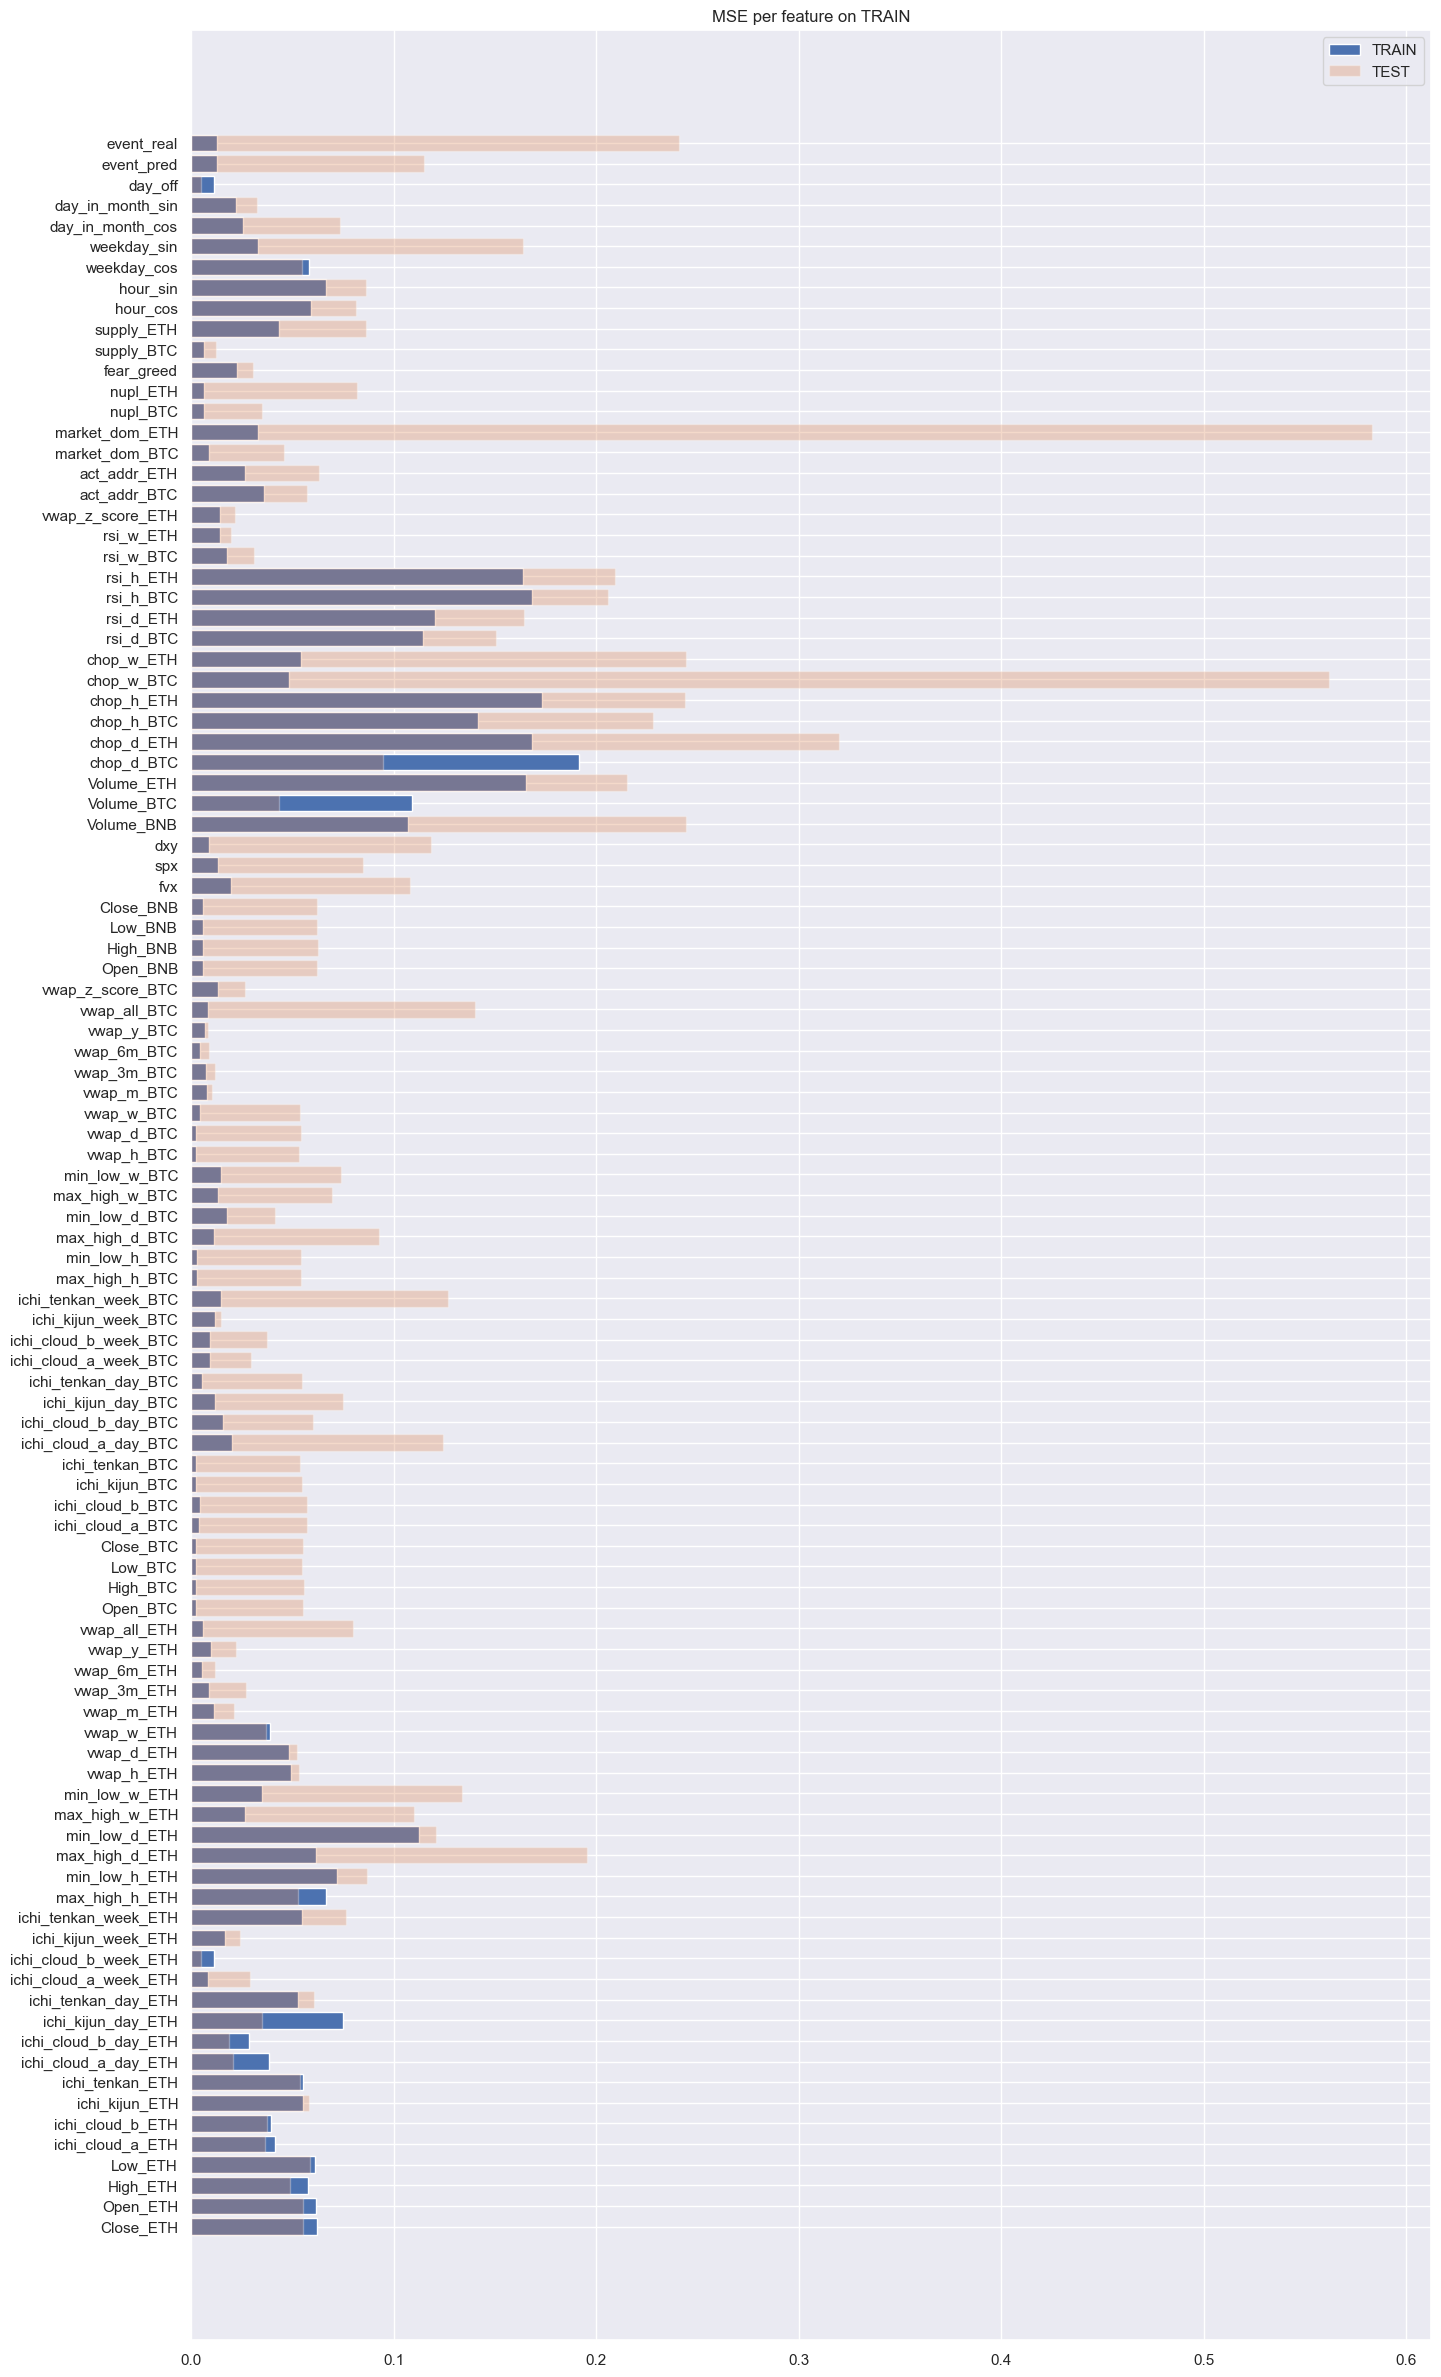

In [126]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [127]:
encoder_model.layers[3].get_weights()

[array([[ 0.04869558, -0.74089915, -0.3464099 , ...,  0.09943452,
         -0.06512702, -0.0468666 ],
        [-0.10919259, -0.3231579 , -0.35992002, ..., -0.03049878,
          0.00433715, -0.32388708],
        [-0.14290585,  0.01806482, -0.14917865, ..., -0.42760968,
         -0.592642  , -0.72575027],
        ...,
        [ 0.48615026,  0.22899216,  0.32962134, ...,  0.1492363 ,
         -0.295968  , -0.6468628 ],
        [ 1.1781462 , -0.8138317 , -0.06237093, ..., -0.707739  ,
          0.263591  , -0.12662731],
        [ 0.09023854, -0.04878111,  0.00868495, ..., -0.10868675,
          0.19603086, -0.10904731]], dtype=float32),
 array([ 0.02910413, -0.15568243, -0.3349044 , -0.43098983,  0.26935938,
        -0.18914023,  0.10248115,  0.19338296, -0.04095006, -0.01773897,
         0.19345436, -0.24964643, -0.02048169,  0.16057073, -0.09229496,
        -0.1645601 ,  0.369534  , -0.10497433, -0.18912236, -0.07812049,
        -0.01364618,  0.33430725,  0.29266664,  0.13750711, -0.254

## Prediction Models

### LSTM all features

In [128]:
X_train_sca.shape

(80886, 72, 102)

In [129]:
X_train_sca.shape[-1]

102

In [130]:
X_train_sca.shape[-2:]

(72, 102)

In [131]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    patience = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=patience,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [132]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [133]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

2528/2528 [==============================] - 33s 13ms/step


(80886, 72, 32)

In [134]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

23/23 [==============================] - 0s 17ms/step


(730, 72, 32)

In [135]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [136]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [137]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [138]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((80886, 72, 36), (730, 72, 36))

#### Correlations

In [139]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



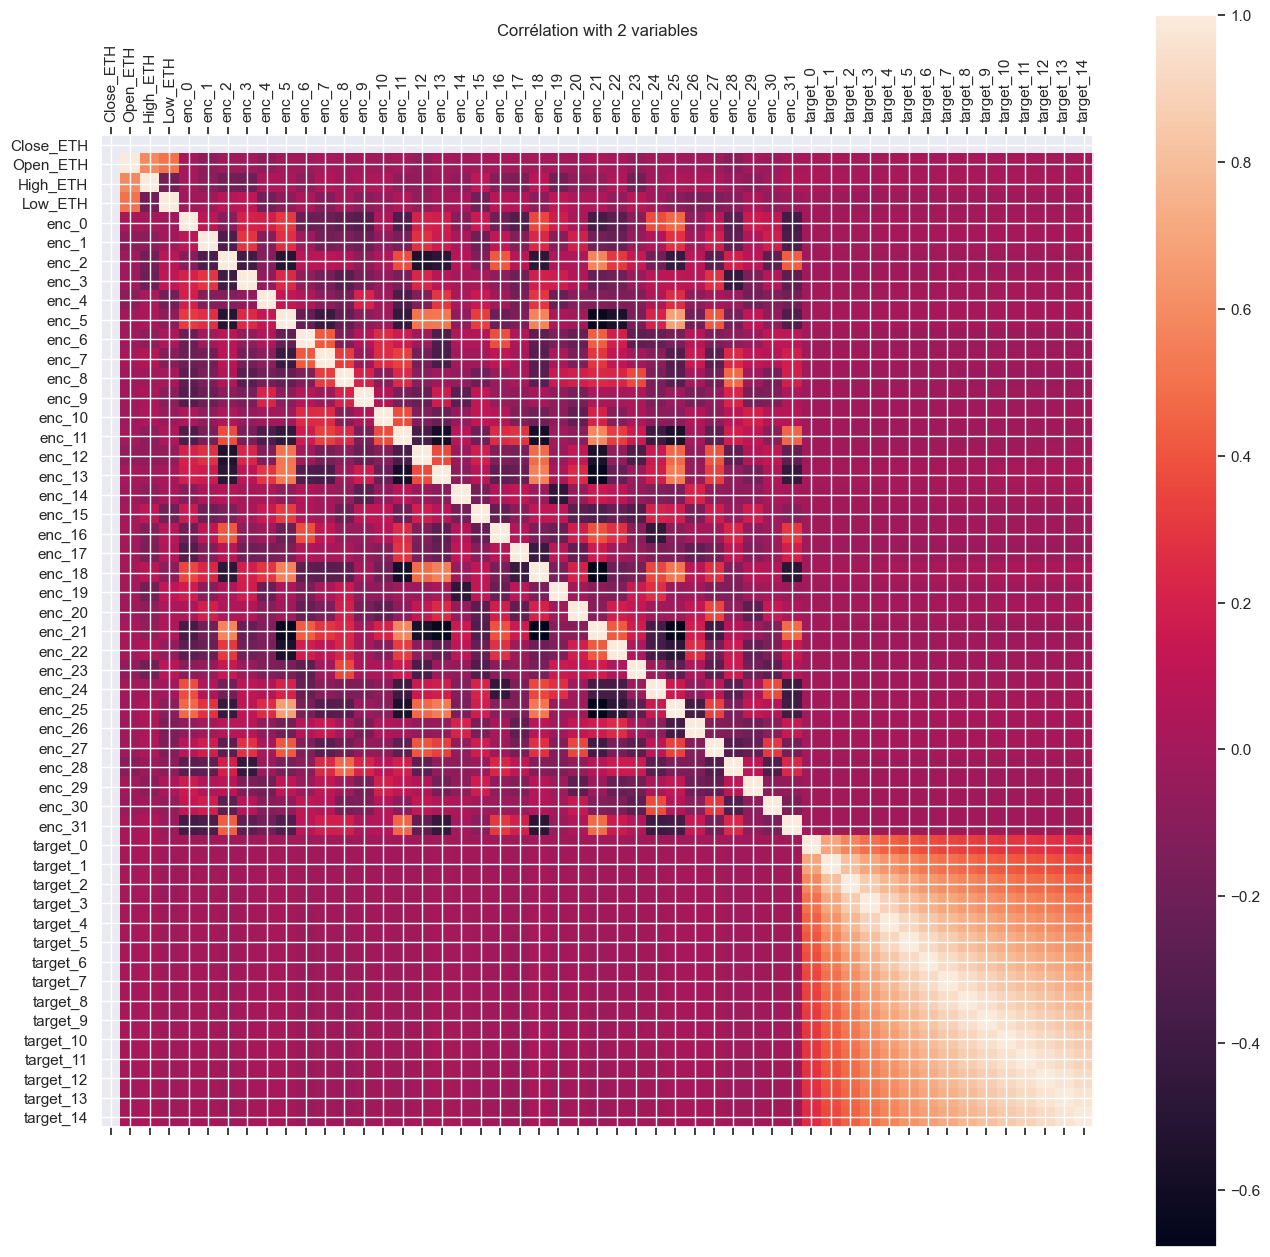

In [140]:
fig = plot_corr(corr_matrix_min)

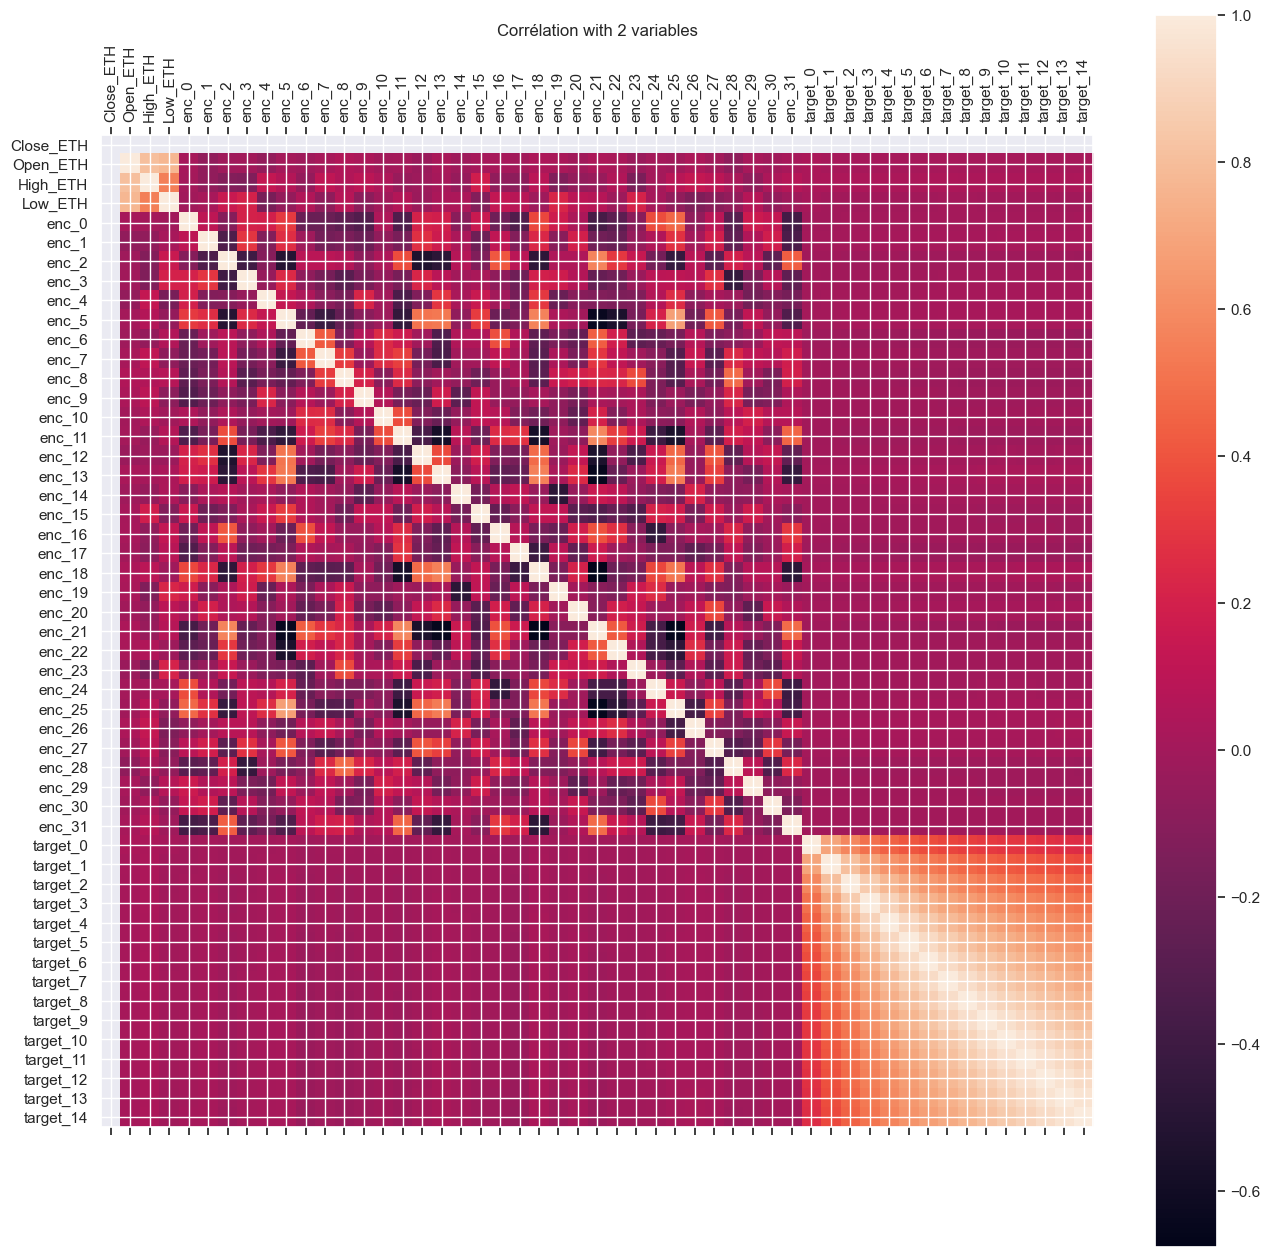

In [141]:
fig = plot_corr(corr_matrix_max) 

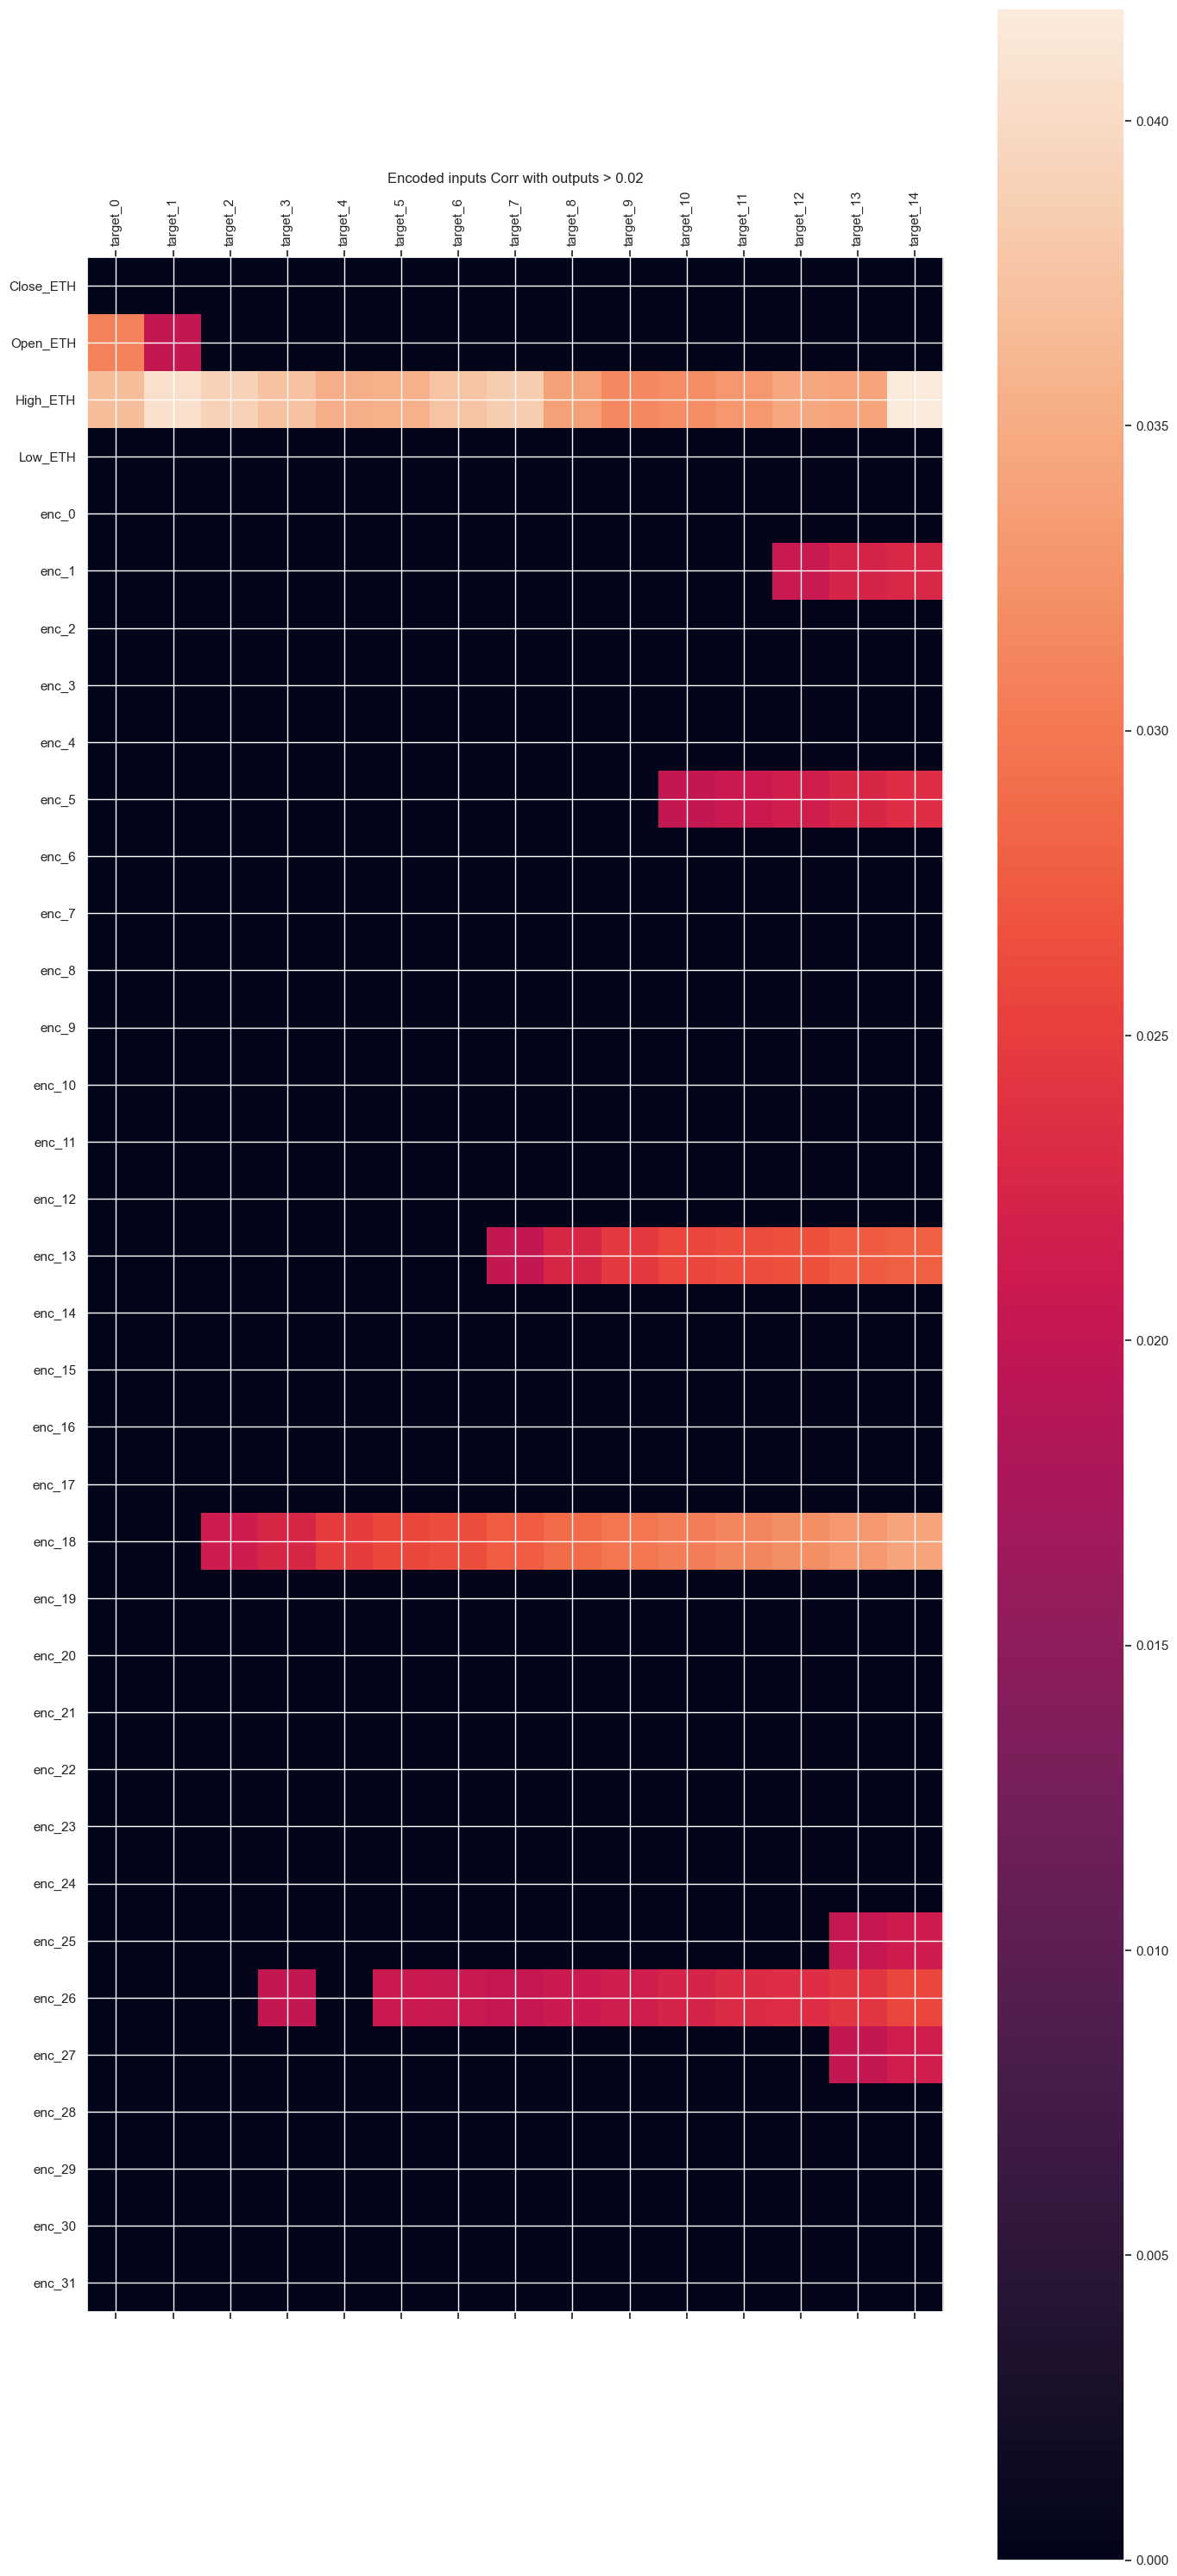

In [142]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

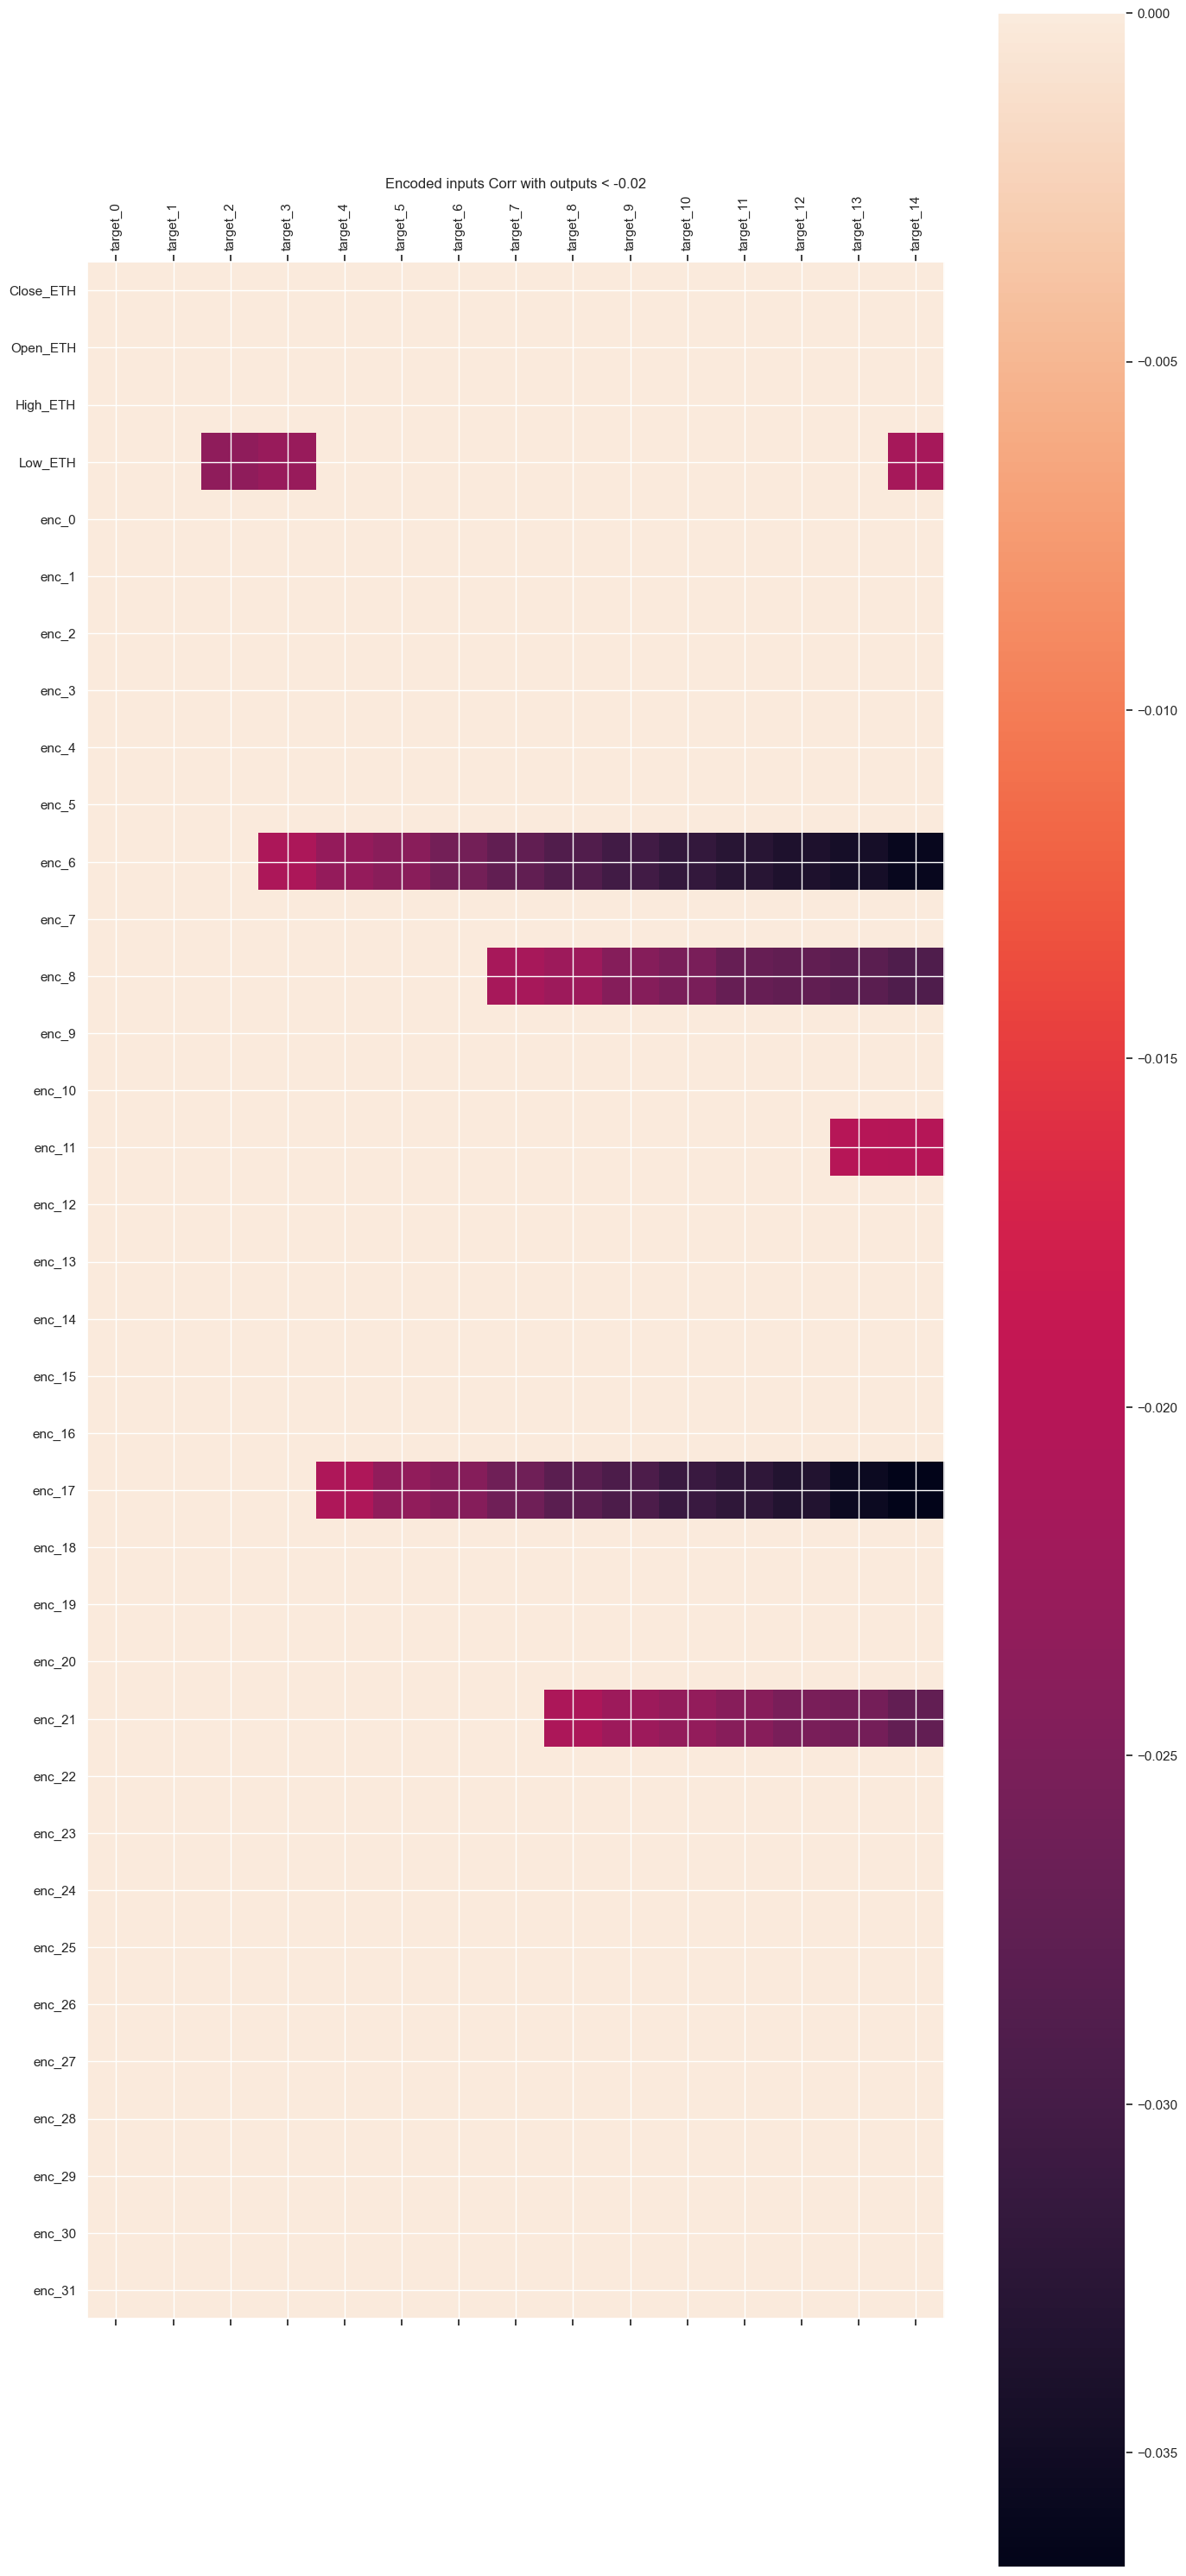

In [143]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [144]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [145]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [146]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [147]:
MODE_AUTO_SELECT

0

In [148]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
nb encoded features:  32


In [149]:
X_train_.shape

(80886, 72, 36)

In [150]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [151]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [152]:
X_train_.shape

(80886, 72, 36)

#### Train

In [153]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 50#30
patience = 0#10
#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)

mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in [128]: #[32, 64, 128]: #[128]: #
        for dropout_rate in  [0.25]: #[0.05, 0.15, 0.25]: #[0.1]:
            for seed in LIST_SEEDS:
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.AdamW()
                if patience is not None:
                    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                    verbose=1, patience=patience,
                                                    restore_best_weights=True)
                # create model
                multi_step_model = tf.keras.models.Sequential()
                multi_step_model.add(
                    tf.keras.layers.LSTM(
                        n_units,
                        return_sequences=False,
                        input_shape=X_train_.shape[-2:],
                        #kernel_regularizer=reg,
                        #bias_regularizer=reg,
                    )
                )
                multi_step_model.add(tf.keras.layers.LayerNormalization())
                multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
                #multi_step_model.add(tf.keras.layers.BatchNormalization())
                multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
                # compile
                multi_step_model.compile(optimizer=optim, loss='mse')
                # fitting
                if patience == 0:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1,
                    )
                else:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1, 
                        callbacks=[es],
                    )
                # eval
                mse_curr = np.min(multi_step_history.history['val_loss'])
                print("MSE TEST : ", mse_curr)

                # plot MSE
                name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                plot_train_history(
                    multi_step_history,
                    f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                    saveFolder="data",
                )

                # save the best
                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate

                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_units_min = n_units
                        dropout_rate_min = dropout_rate
                        print("Save model: ", path_mdl_predict_autoenc_lstm)
                        multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

    
print("Load model: ", path_mdl_predict_autoenc_lstm)
multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
n_units = multi_step_model.layers[0].units#32
dropout_rate = multi_step_model.layers[2].rate#0.25
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm


Best model: n_units=128 / dropout= 0.25
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               84480     
                                                                 
 layer_normalization (Layer  (None, 128)               256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
Total params: 86671 (338.56 KB)
Trainable params: 86671 (338.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [154]:
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=128 / dropout= 0.25


In [155]:
np.min(y_train)

0.8990060972444147

In [156]:
np.max(y_train)

1.087790104524251

#### Results

##### Save mdl

In [157]:
X_train_.shape

(80886, 72, 36)

##### Predict

In [158]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

23/23 [==============================] - 0s 19ms/step


##### Plots

In [159]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(80895,)
(80895,)


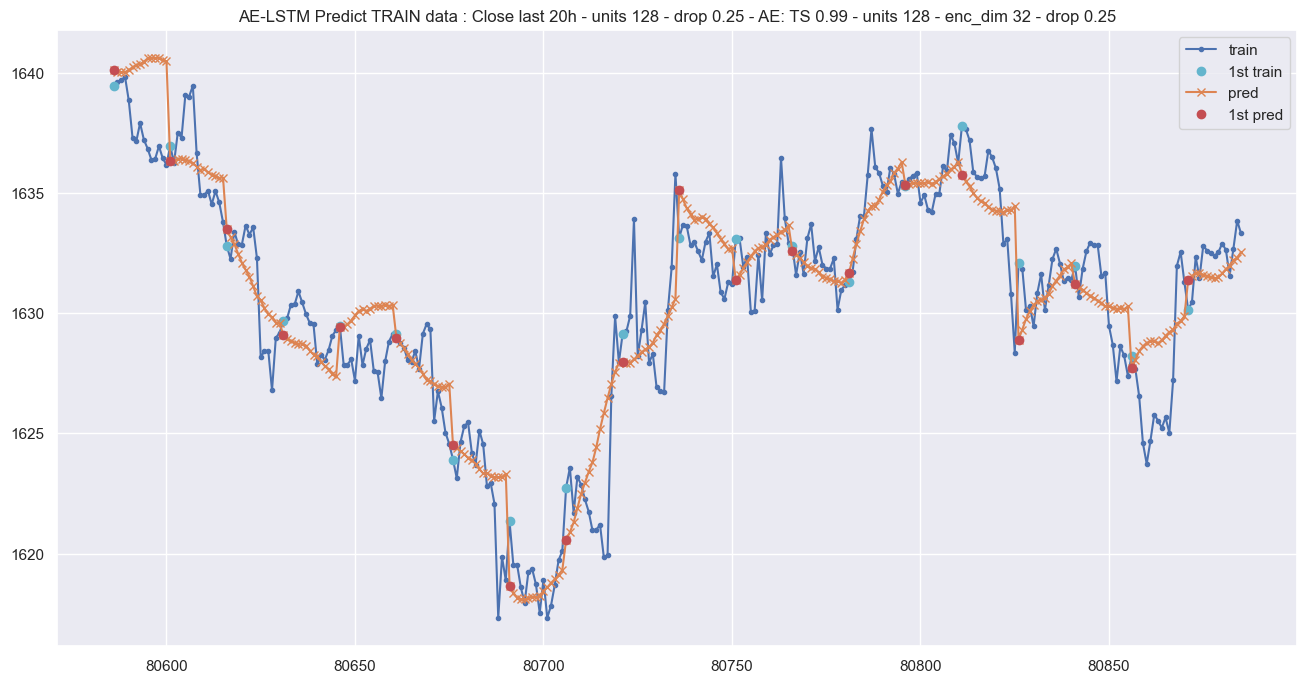

In [160]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

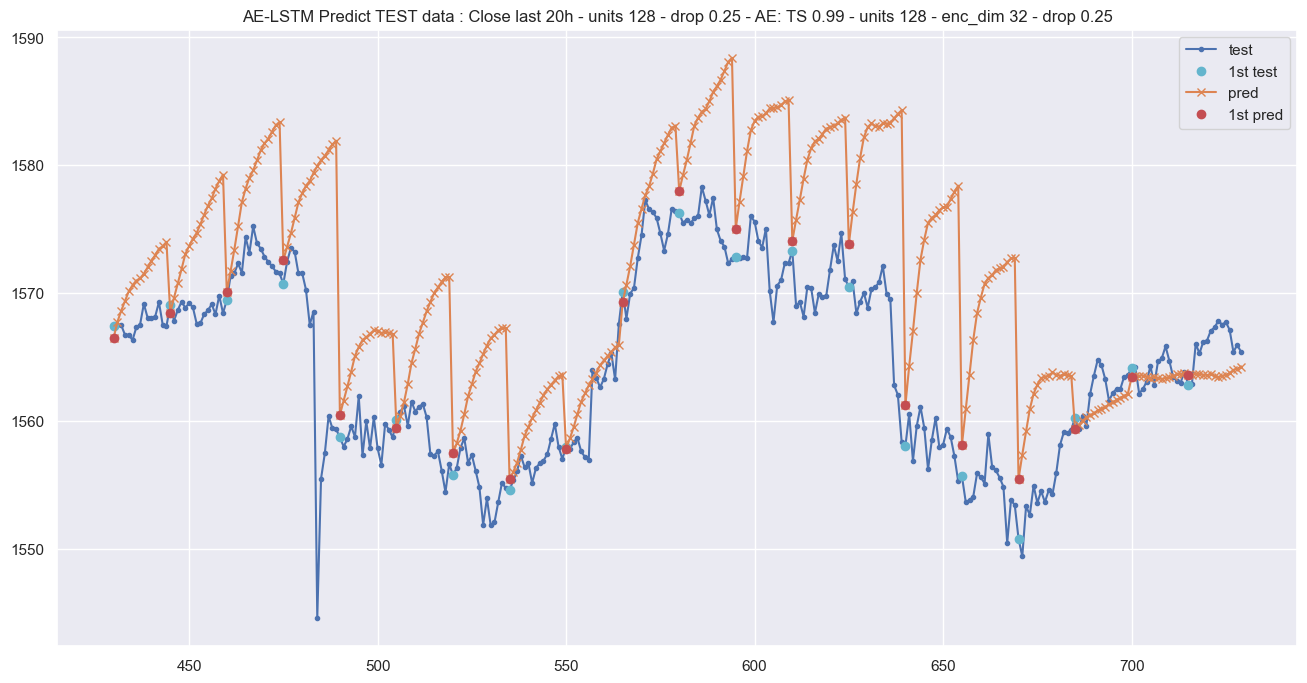

In [161]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

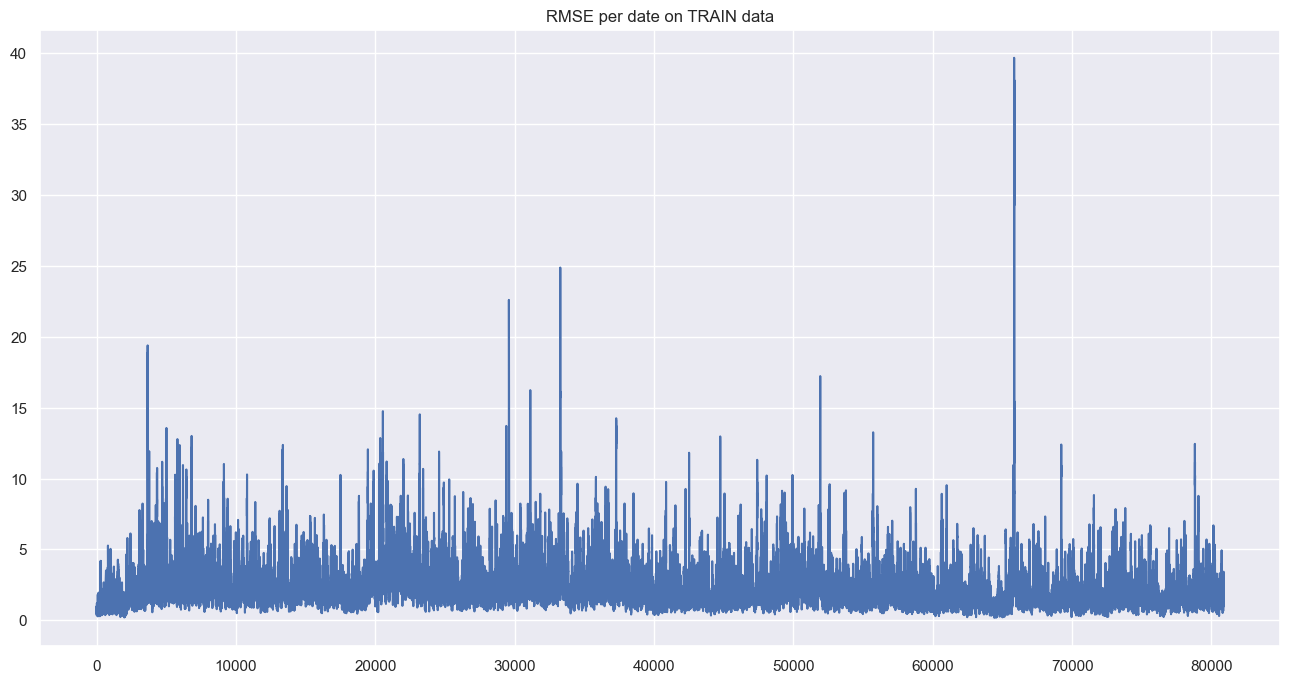

In [162]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

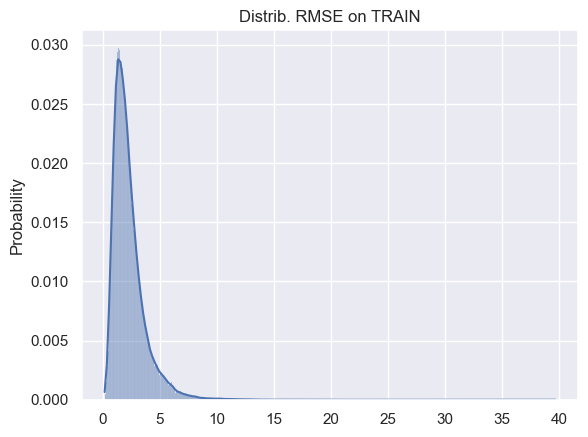

In [163]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 2.31')

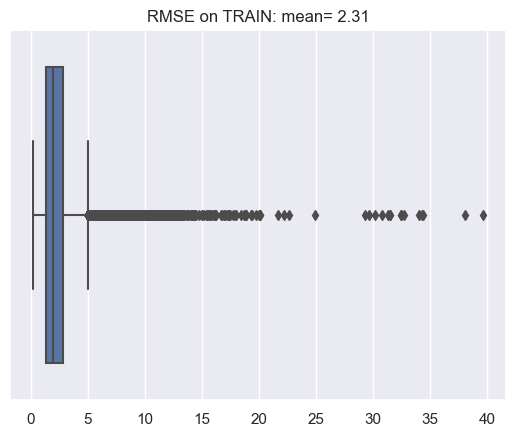

In [164]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

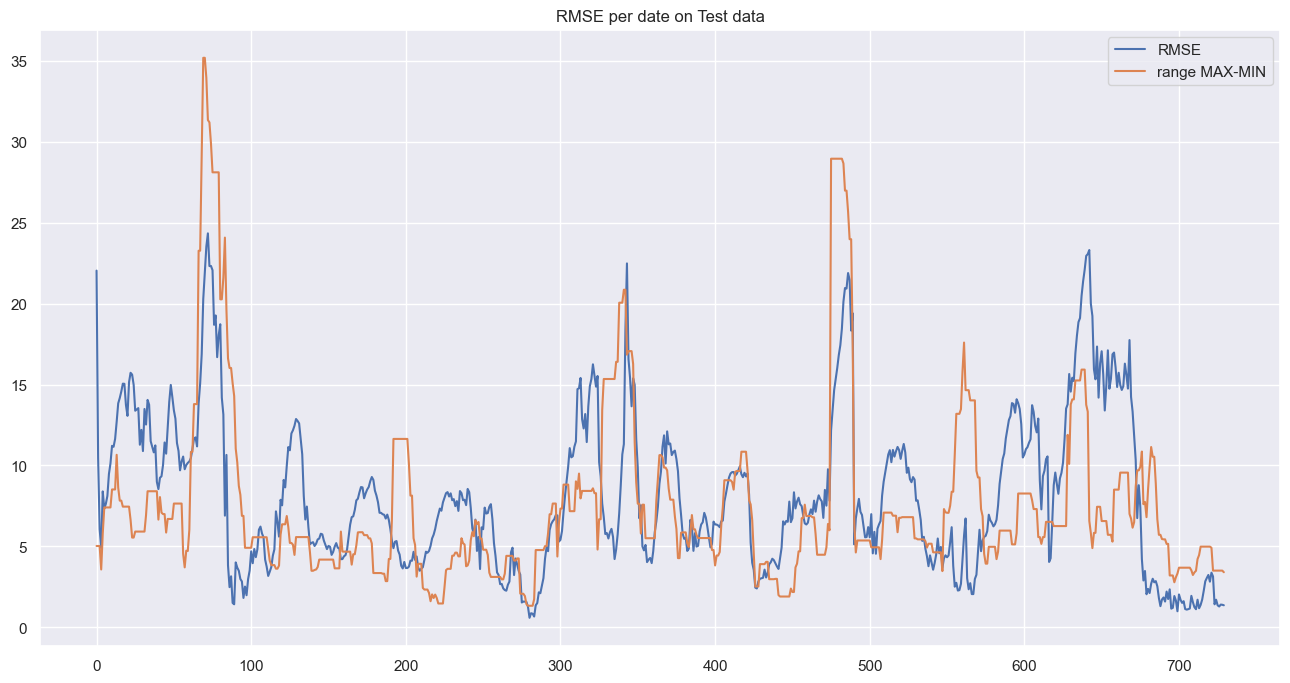

In [165]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [166]:
np.mean(arr_range)

7.58316438356165

<AxesSubplot: ylabel='Probability'>

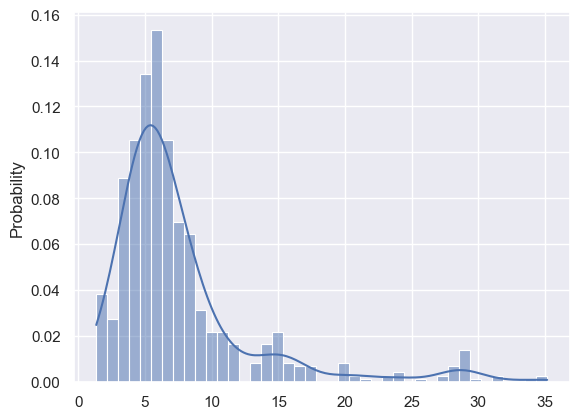

In [167]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [168]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

6.556277958292434

<AxesSubplot: ylabel='Probability'>

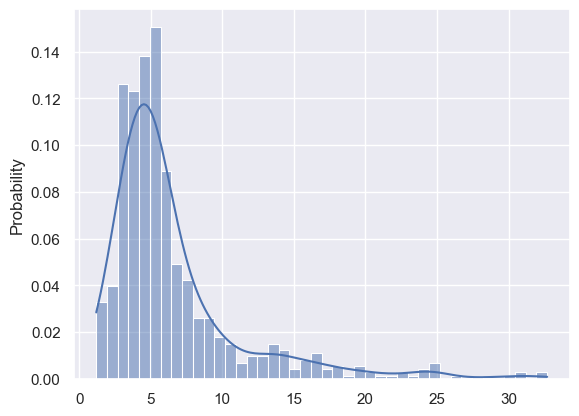

In [169]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

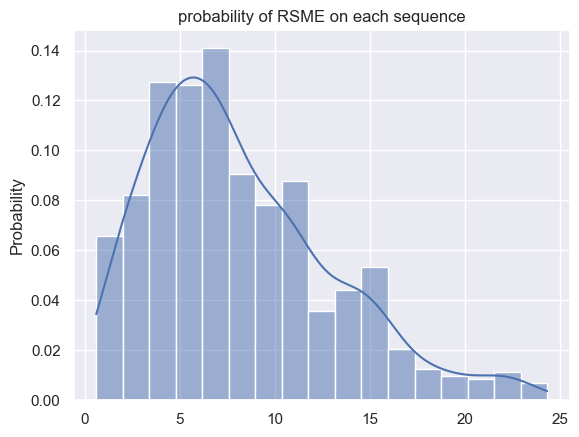

In [170]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 37.91582191780825)

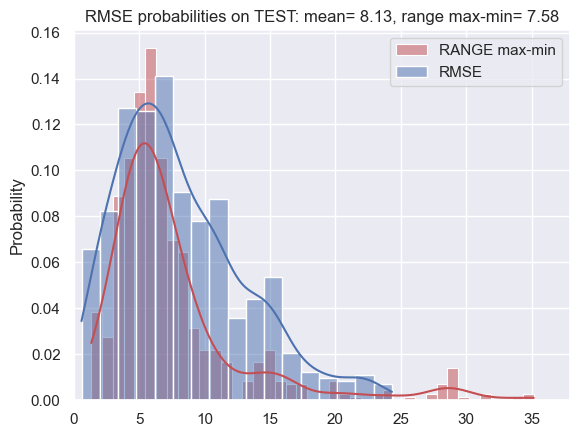

In [171]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 40.65254433147481)

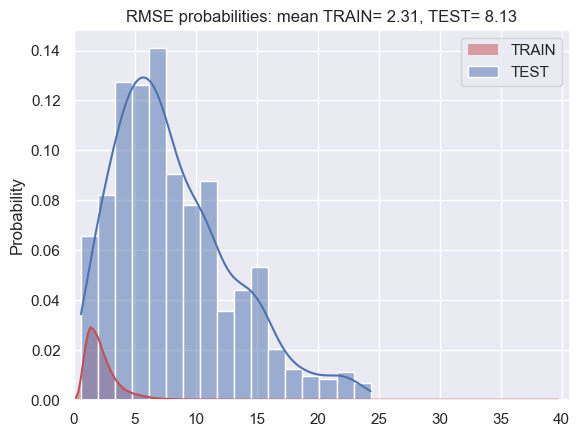

In [172]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 8.13')

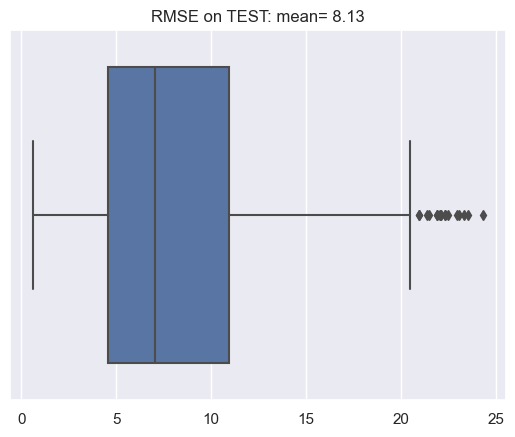

In [173]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [174]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1567.3  1567.82 1567.53 1567.72 1567.11 1565.38 1565.93 1565.41 1564.64
 1564.31 1565.48 1565.04 1566.4  1566.31 1565.47]
[1566.68236399 1566.6637767  1566.6691007  1566.58643863 1566.56673051
 1566.54412687 1566.63360738 1566.59531196 1566.5854112  1566.68787479
 1566.87253343 1567.0608348  1567.34870426 1567.4903039  1567.67262745]


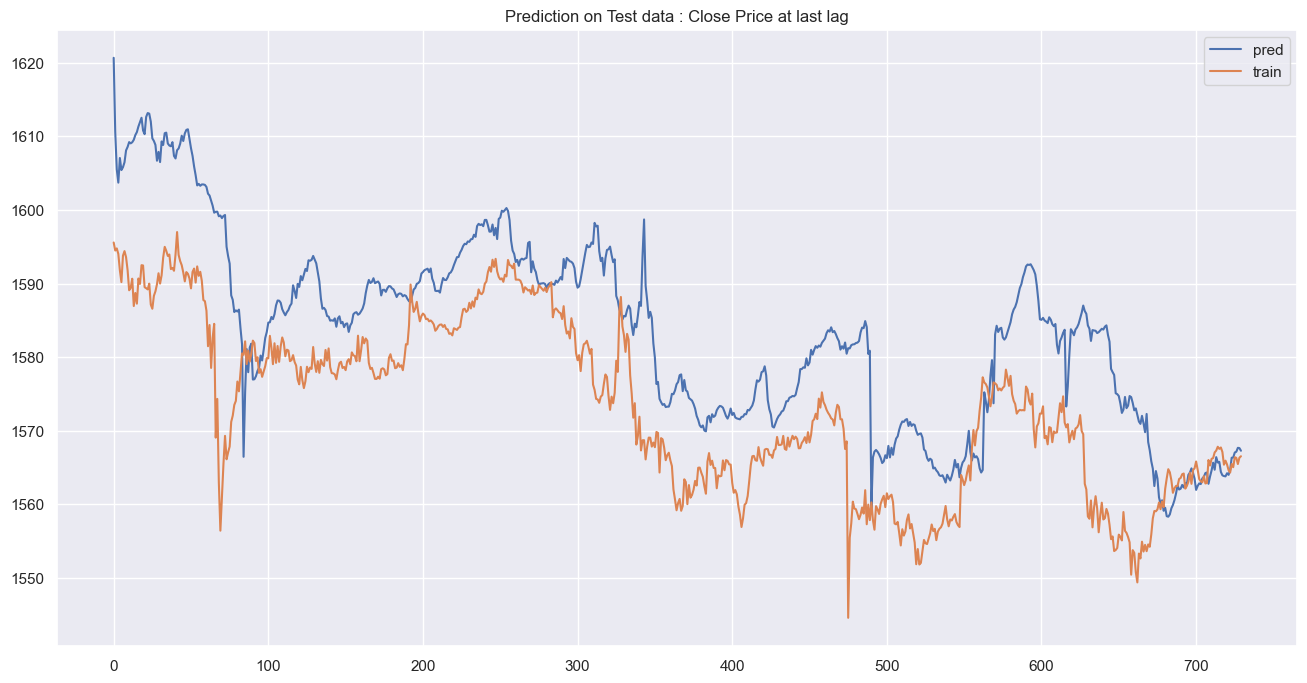

In [175]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

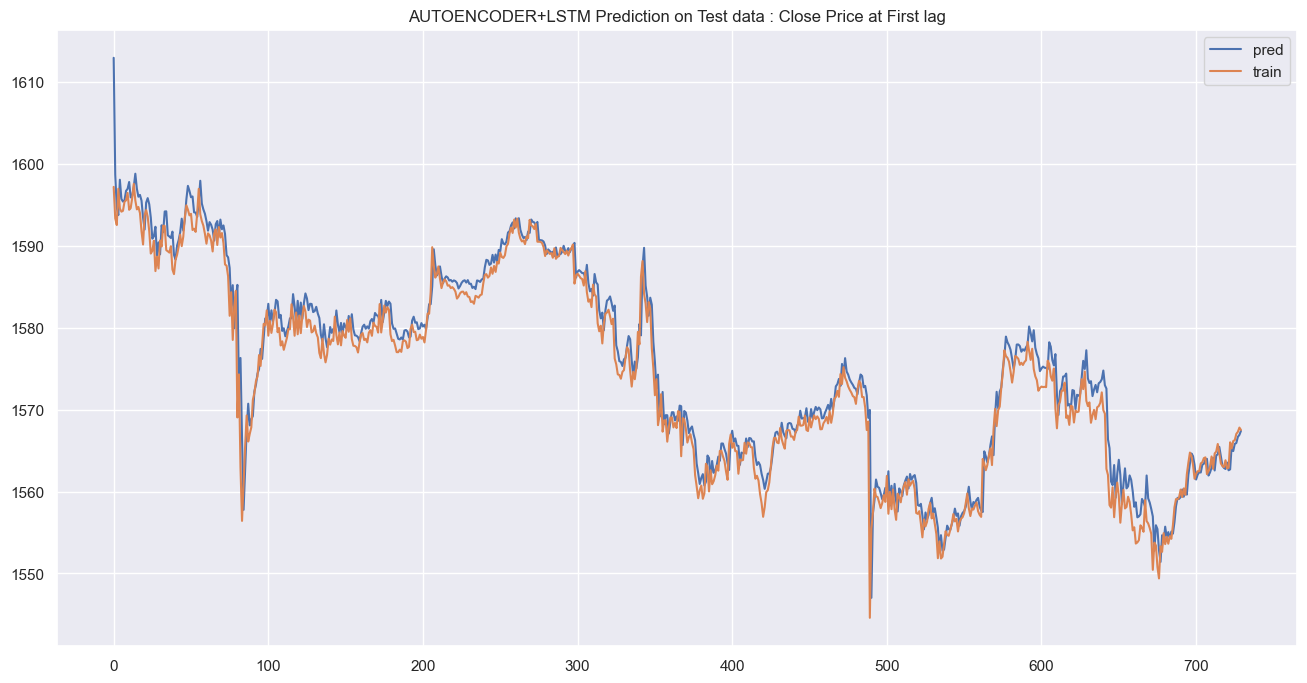

In [176]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

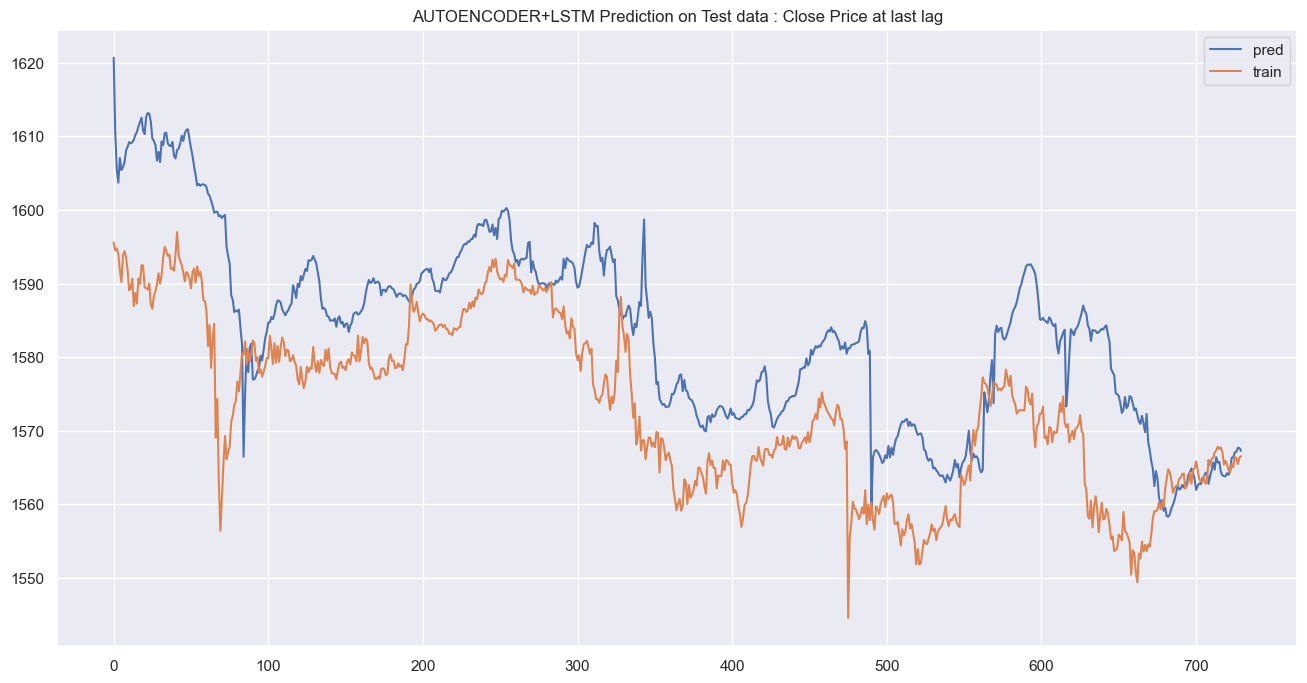

In [177]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [178]:
X_test_sca.shape

(730, 72, 102)

In [179]:
df_feat["Close_ETH"].iloc[-1]

1565.01

In [180]:
df_feat["Close_ETH"].iloc[-1]

1565.01

In [181]:
len(list_i_enc_select)

32

In [182]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1553.77 1553.41 1550.78 1549.39 1553.31 1552.64 1554.92 1553.58 1554.49
 1553.63 1554.55 1554.23 1555.89 1558.09 1559.09 1559.05 1559.31 1560.25
 1559.33 1560.39 1559.61 1562.11 1563.53 1564.77 1564.35 1563.26 1561.56
 1562.18 1562.49 1562.48 1563.44 1563.58 1564.09 1564.18 1562.13 1562.49
 1563.07 1564.29 1562.78 1564.66 1564.89 1565.82 1564.7  1563.44 1563.13
 1562.99 1563.83 1562.83 1562.9  1566.02 1565.27 1566.18 1566.28 1567.05
 1567.3  1567.82 1567.53 1567.72 1567.11 1565.38 1565.93 1565.41 1564.64
 1564.31 1565.48 1565.04 1566.4  1566.31 1565.47 1566.33 1566.53 1565.01]
X_last[0,:,0] after divide by price:
[0.99281794 0.99258791 0.99090741 0.99001923 0.99252401 0.9920959
 0.99355276 0.99269653 0.993278   0.99272848 0.99331634 0.99311187
 0.99417256 0.9955783  0.99621728 0.99619172 0.99635785 0.99695849
 0.99637063 0.99704794 0.99654954 0.99814698 0.99905432 0.99984665
 0.99957828 0.9988818  0.99779554 0.9981917  0.99838979 0.9983834
 0.998

In [183]:
X_last_encoded_sca.shape

(1, 72, 32)

In [184]:
list_i_enc_select

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [185]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 32)

In [186]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [187]:
X_train_.shape

(80886, 72, 36)

In [188]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
81785  1697066700000   1566.40   1567.23  1565.73    1566.31    571.5351   
81786  1697067000000   1566.32   1566.32  1565.35    1565.47    360.1248   
81787  1697067300000   1565.47   1566.33  1565.47    1566.33    143.9279   
81788  1697067600000   1566.32   1566.53  1566.13    1566.53    103.8286   
81789  1697067900000   1566.52   1566.91  1565.01    1565.01    277.3852   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1731.033372       1730.612087   
1      2023-01-01 00:05:00       1731.033372       1730.612087   
2      2023-01-01 00:10:00       1731.033372       1730.612087   
3      2023-01-01 00:15:00       1731.033372       1730.612087   
4      2023-01-01 00:20:00       1731.033372       1730.612087   
...                    ...               ...               ...   
81785  2023-10-11 23:25:00       1563.022500       1557.790000   
81786  2023-10-11 23:30:00       1563.390000       1557.900000   
81787  2023-10-11 23:35:00       1563.637500       1557.900000   
81788  2023-10-11 23:40:00       1563.850000       1557.900000   
81789  2023-10-11 23:45:00       1563.862500       1557.900000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
81785        1565.845  ...         NaN            NaN           NaN   
81786        1565.845  ...         NaN            NaN           NaN   
81787        1565.845  ...         NaN            NaN           NaN   
81788        1565.845  ...         NaN            NaN           NaN   
81789        1565.945  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
81785               NaN         0.0               NaN         0.0      0.0   
81786               NaN         0.0               NaN         0.0      0.0   
81787               NaN         0.0               NaN         0.0      0.0   
81788               NaN         0.0               NaN         0.0      0.0   
81789               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
81785                  NaN  False  
81786                  NaN  False  
81787                  NaN  False  
81788                  NaN  False  
81789                  NaN  False  

[81790 rows x 136 columns]

In [189]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [190]:
y_last_pred_unscaled

array([[0.9998352 , 0.9997976 , 0.999747  , 0.9996652 , 0.99958706,
        0.9994856 , 0.9994072 , 0.99933755, 0.99920386, 0.9991633 ,
        0.99914765, 0.99915415, 0.99924755, 0.9992828 , 0.9993736 ]],
      dtype=float32)

In [191]:
df_feat["Close_ETH"].iloc[-1]

1565.01

In [192]:
y_last_pred_raw

array([[1564.7521, 1564.6932, 1564.614 , 1564.4861, 1564.3638, 1564.205 ,
        1564.0823, 1563.9733, 1563.764 , 1563.7006, 1563.676 , 1563.6863,
        1563.8324, 1563.8876, 1564.0297]], dtype=float32)

In [193]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [194]:
list_pred

[1564.4861,
 1564.3638,
 1564.205,
 1564.0823,
 1563.9733,
 1563.764,
 1563.7006,
 1563.676,
 1563.6863,
 1563.8324,
 1563.8876,
 1564.0297]

In [195]:
save_list(list_pred, path_save_pred_vals)

In [196]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [197]:
list_pred_reload

[1564.4861,
 1564.3638,
 1564.205,
 1564.0823,
 1563.9733,
 1563.764,
 1563.7006,
 1563.676,
 1563.6863,
 1563.8324,
 1563.8876,
 1564.0297]